# **A Linguistic Comparison Between Human- and AI-generated European Portuguese Content**

# <span style="color: #FF69B4;">1. Libraries</span>

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import Counter, defaultdict
from typing import Optional

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display, HTML
%matplotlib inline

# NLP - Tokenization, Stopwords, Stemming
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Topic Modeling
import gensim
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Machine Learning
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    precision_recall_fscore_support
)
from mlxtend.plotting import plot_confusion_matrix
import joblib

# Statistical Tests
from scipy.stats import wilcoxon, chi2_contingency, pearsonr, spearmanr

# LIWC and SAGE Analysis
import liwc  
import sage

# LLM APIs and Tools
from dotenv import load_dotenv, find_dotenv
import os
import time
from tqdm import tqdm
from openai import OpenAI
from llama_api_client import LlamaAPIClient
from groq import Groq
from mistralai import Mistral

# Warnings
import warnings
warnings.filterwarnings("ignore")

# <span style="color: #FF69B4;">2.  Load and Explore Data</span>

**Dataset Source:** https://latamt.ieeer9.org/index.php/transactions/article/view/8547

**Article Metadata:**
- Publication Date: 14 March 2024
- Dataset Creation: 2023

**Dataset Description:**
- 31,721 real news 
- 31,543 fake news 
- Columns: Text, Source, URL

**Unreliable Sources (Fake News):**
- Bombeiros 24, Direita Política, Lusojornal2015, Lusopt.com, Lusopt.eu, Lusopt.pt, Semanário Extra, Magazine Lusa, Partilhei.com, Tuga Press, Polígrafo Fact Check, Observador Fact Check, Público Fact Check.

**Reliable Sources (Real News):**
- SIC Notícias, Diário de Notícias Expresso, Jornal de Notícias, Jornal SOL, Polígrafo Fact Check, Observador Fact Check, Público Fact Check.

## 2.1 Reading Data 

In [4]:
df_real = pd.read_excel("Final_real_dataset.xlsx")

In [5]:
df_fake = pd.read_excel("Final_fake_dataset.xlsx")

In [6]:
df_fake_control = pd.read_excel("Final_fake_dataset.xlsx")

In [7]:
df_real.head()

Text  \
0  “O SNS tem hoje cerca de 4300 médicos especial...   
1  "Não tinha de me pronunciar nem ter conhecimen...   
2  “Nós temos, em Portugal, quase um milhão de pe...   
3  Já defendo o referendo sobre a eutanásia há qu...   
4  “Tenho uma regra de não comentar no exterior a...   

                                             Source  \
0                 Manuel Pizarro, ministro da Saúde   
1  Marcelo Rebelo de Sousa, Presidente da República   
2                Luís Montenegro, presidente do PSD   
3                Luís Montenegro, presidente do PSD   
4                  António Costa, primeiro-ministro   

                                                 URL  
0  https://www.publico.pt/2022/12/09/sociedade/no...  
1  https://www.publico.pt/2023/03/03/politica/not...  
2  https://www.publico.pt/2022/08/19/politica/not...  
3  https://www.publico.pt/2022/12/06/politica/not...  
4  https://www.publico.pt/2022/06/30/politica/not...

In [8]:
df_fake.head()

Text Source  \
0  Filomena Cautela apanhada a conduzir com Alcoo...    NaN   
1  António Costa fará de tudo para se manter no p...    NaN   
2  Os portugueses andam a ser enganados há muito ...    NaN   
3  Pablo Iglesias (extrema-esquerda espanhola) su...    NaN   
4  Actor Jon Voight, pai de Angelina Jolie, arras...    NaN   

                                                 URL  
0  https://www.direitapolitica.com/filomena-caute...  
1  https://www.direitapolitica.com/antonio-costa-...  
2  https://www.direitapolitica.com/os-portugueses...  
3  https://www.direitapolitica.com/pablo-iglesias...  
4  https://www.direitapolitica.com/actor-jon-voig...

## 2.2 Exploratory Data Analysis (EDA)

### 2.2.1 Data Visualization

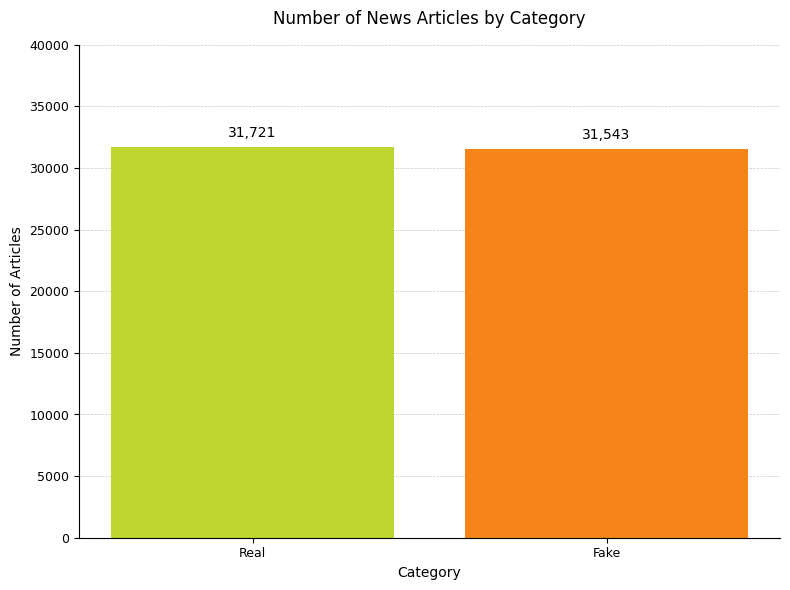

In [9]:
# Visualize the number of news articles by category (Real vs Fake)

# Create category DataFrame
counts = pd.DataFrame({
    'Category': ['Real'] * len(df_real) + ['Fake'] * len(df_fake)
})

# Count values
value_counts = counts['Category'].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(value_counts.index, value_counts.values, color=['#BED62F', '#f58518'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# Styling
ax.set_title("Number of News Articles by Category", fontsize=12, pad=15)
ax.set_ylabel("Number of Articles", fontsize=10)
ax.set_xlabel("Category", fontsize=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_ylim(0, 40000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

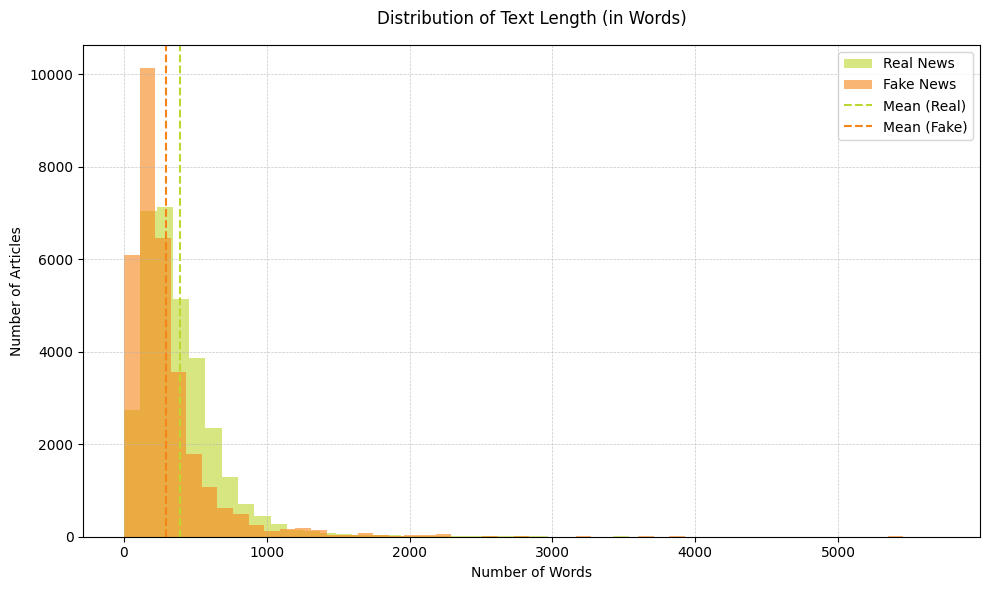

In [10]:
# Calculate word count for each article in both categories

df_real['Word_Count'] = df_real['Text'].fillna("").apply(lambda x: len(str(x).split()))
df_fake['Word_Count'] = df_fake['Text'].fillna("").apply(lambda x: len(str(x).split()))

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df_real['Word_Count'], bins=50, alpha=0.6, label='Real News', color='#BED62F')
plt.hist(df_fake['Word_Count'], bins=50, alpha=0.6, label='Fake News', color='#f58518')

# Add vertical lines for means
plt.axvline(df_real['Word_Count'].mean(), color='#BED62F', linestyle='--', linewidth=1.5, label='Mean (Real)')
plt.axvline(df_fake['Word_Count'].mean(), color='#f58518', linestyle='--', linewidth=1.5, label='Mean (Fake)')

# Styling
plt.title("Distribution of Text Length (in Words)", fontsize=12, pad=15)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
print(f"Mean number of words - Real News: {df_real['Word_Count'].mean():.2f}")
print(f"Mean number of words - Fake News: {df_fake['Word_Count'].mean():.2f}")

Mean number of words - Real News: 392.81
Mean number of words - Fake News: 297.93


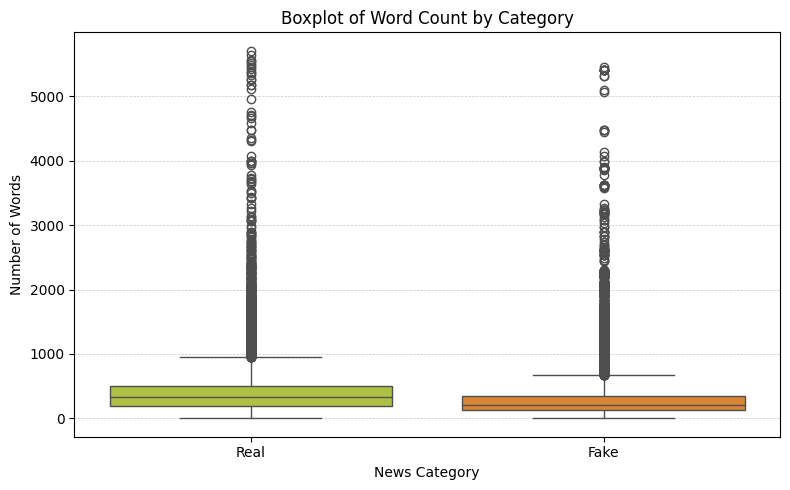

In [12]:
# Visualize the distribution of word count per category using boxplot

combined_df = pd.DataFrame({
    'Word_Count': pd.concat([df_real['Word_Count'], df_fake['Word_Count']]),
    'Category': ['Real'] * len(df_real) + ['Fake'] * len(df_fake)
})

plt.figure(figsize=(8, 5))
sns.boxplot(x='Category', y='Word_Count', data=combined_df, palette=['#BED62F', '#f58518'])

plt.title("Boxplot of Word Count by Category", fontsize=12)
plt.ylabel("Number of Words", fontsize=10)
plt.xlabel("News Category", fontsize=10)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

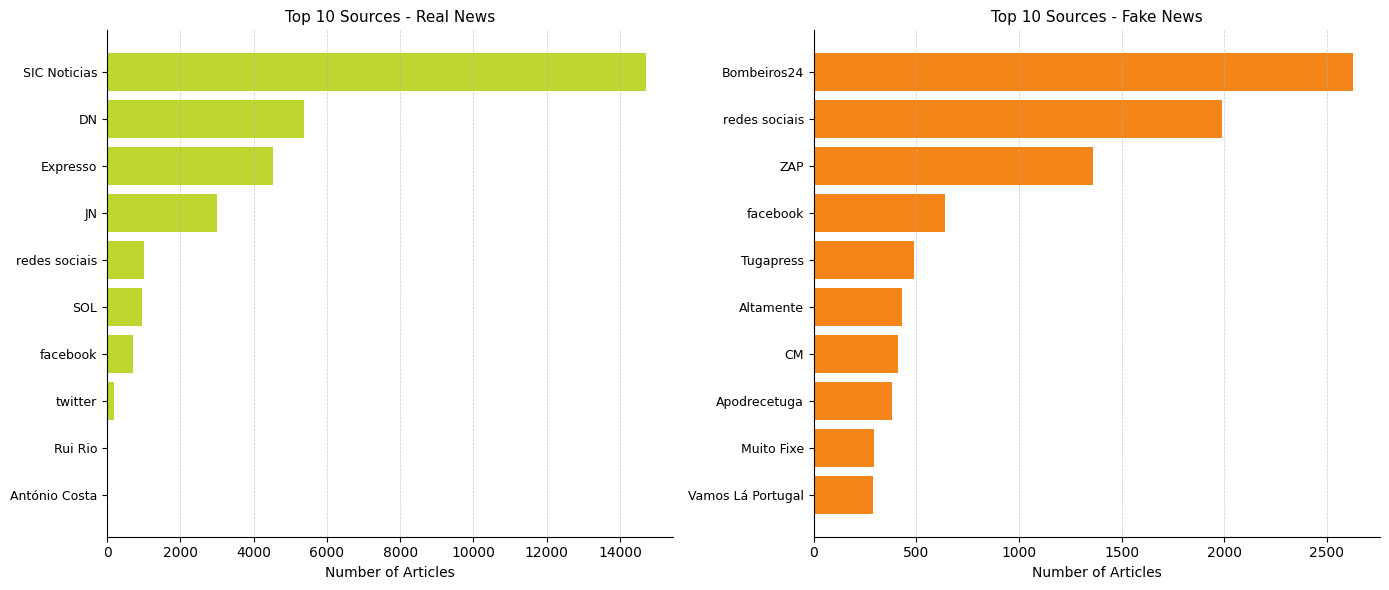

In [13]:
# Get top 10 news sources for each category

top_real_sources = df_real['Source'].value_counts().nlargest(10)
top_fake_sources = df_fake['Source'].value_counts().nlargest(10)

# Plot side-by-side horizontal bar charts
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Real News
axs[0].barh(top_real_sources.index[::-1], top_real_sources.values[::-1], color='#BED62F')
axs[0].set_title("Top 10 Sources - Real News", fontsize=11)
axs[0].set_xlabel("Number of Articles", fontsize=10)
axs[0].tick_params(axis='y', labelsize=9)

# Fake News
axs[1].barh(top_fake_sources.index[::-1], top_fake_sources.values[::-1], color='#f58518')
axs[1].set_title("Top 10 Sources - Fake News", fontsize=11)
axs[1].set_xlabel("Number of Articles", fontsize=10)
axs[1].tick_params(axis='y', labelsize=9)

# Styling
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

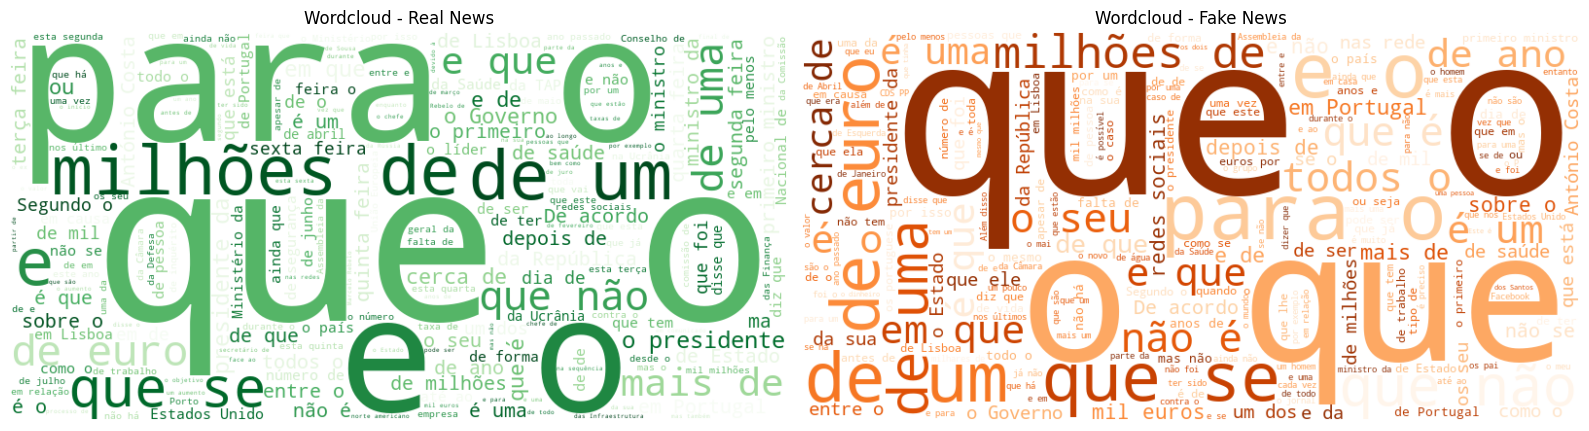

In [14]:
# Generate and display word clouds for Real and Fake News

# Concatenate all text into one string per category
real_text = " ".join(df_real['Text'].dropna().astype(str))
fake_text = " ".join(df_fake['Text'].dropna().astype(str))

# Generate word clouds
wordcloud_real = WordCloud(width=800, height=400, background_color='white',
                           colormap='Greens', max_words=200).generate(real_text)

wordcloud_fake = WordCloud(width=800, height=400, background_color='white',
                           colormap='Oranges', max_words=200).generate(fake_text)

# Plot side-by-side
plt.figure(figsize=(16, 8))

# Real News
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud - Real News", fontsize=12)

# Fake News
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud - Fake News", fontsize=12)

plt.tight_layout()
plt.show()

In [15]:
# Cleanup: remove auxiliary column
df_real.drop(columns='Word_Count', inplace=True)
df_fake.drop(columns='Word_Count', inplace=True)

### 2.2.2 Data Cleaning

#### Datatypes

To ensure consistency and avoid issues related to generic "object" types, all textual columns ("Text", "Source", and "URL") were explicitly converted to the "string" data type for each dataset.

In [16]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31721 entries, 0 to 31720
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    31720 non-null  object
 1   Source  30761 non-null  object
 2   URL     31721 non-null  object
dtypes: object(3)
memory usage: 743.6+ KB


In [17]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31543 entries, 0 to 31542
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    31520 non-null  object
 1   Source  19479 non-null  object
 2   URL     31543 non-null  object
dtypes: object(3)
memory usage: 739.4+ KB


In [18]:
df_fake_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31543 entries, 0 to 31542
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    31520 non-null  object
 1   Source  19479 non-null  object
 2   URL     31543 non-null  object
dtypes: object(3)
memory usage: 739.4+ KB


In [19]:
df_real['Text'] = df_real['Text'].astype("string")
df_real['Source'] = df_real['Source'].astype("string")
df_real['URL'] = df_real['URL'].astype("string")

In [20]:
df_fake['Text'] = df_fake['Text'].astype("string")
df_fake['Source'] = df_fake['Source'].astype("string")
df_fake['URL'] = df_fake['URL'].astype("string")

In [21]:
df_fake_control['Text'] = df_fake_control['Text'].astype("string")
df_fake_control['Source'] = df_fake_control['Source'].astype("string")
df_fake_control['URL'] = df_fake_control['URL'].astype("string")

#### Missing Values

To ensure data quality, all rows with missing values in the Text or Source columns in df_real will be removed, as both elements are essential to confirm that the texts were written by humans. For df_fake, only rows with missing values in the Text column will be excluded, since the publication dates will be used in this case to ensure minimal AI presence.

In [22]:
df_real.isna().sum()

Text        1
Source    960
URL         0
dtype: int64

In [23]:
df_fake.isna().sum()

Text         23
Source    12064
URL           0
dtype: int64

In [24]:
# Remove missing values
df_real = df_real.dropna()
df_fake = df_fake.dropna(subset=['Text'])

In [25]:
df_real.isna().sum()

Text      0
Source    0
URL       0
dtype: int64

In [26]:
df_fake.isna().sum()

Text          0
Source    12043
URL           0
dtype: int64

In [27]:
# Check if any of the specified columns contain the word "NONE"
columns_to_check = ["Text", "Source"]

# Filter rows where any of the selected columns contain the exact word "NONE"
none_values_real = df_real[df_real[columns_to_check].apply(lambda x: x.astype(str).str.strip().eq("NONE")).any(axis=1)]

# Display the filtered rows
none_values_real

Text Source  \
15     Resultado de uma candidatura ao Mestrado Integ...   NONE   
44     Em declarações à TSF, a 27 de Julho, o deputad...   NONE   
71     “O rendimento per capita português cresceu mai...   NONE   
93     Segundo o PSD, o transporte de órgãos para tra...   NONE   
13096                                               NONE     JN   
13137                                               NONE     JN   
13168                                               NONE     JN   
13175                                               NONE     JN   
13192                                               NONE     JN   
13200                                               NONE     JN   
13283                                               NONE     JN   
13287                                               NONE     JN   
13379                                               NONE     JN   
13512                                               NONE     JN   
13634                                               NONE     JN   
13652                                               NONE     JN   
13764                                               NONE     JN   
13797                                               NONE     JN   
13925                                               NONE     JN   
13964                                               NONE     JN   
14076                                               NONE     JN   
14126                                               NONE     JN   
14250                                               NONE     JN   
14390                                               NONE     JN   
14418                                               NONE     JN   
14477                                               NONE     JN   
14536                                               NONE     JN   
14715                                               NONE     JN   
14941                                               NONE     JN   
15032                                               NONE     JN   
15073                                               NONE     JN   
15156                                               NONE     JN   
15183                                               NONE     JN   
15299                                               NONE     JN   
15395                                               NONE     JN   
15402                                               NONE     JN   
15628                                               NONE     JN   
15636                                               NONE     JN   
15659                                               NONE     JN   
15677                                               NONE     JN   
15691                                               NONE     JN   
15740                                               NONE     JN   
15744                                               NONE     JN   
15938                                               NONE     JN   

                                                     URL  
15     https://www.publico.pt/2022/09/27/sociedade/no...  
44     https://www.publico.pt/2021/07/31/politica/not...  
71     https://www.publico.pt/2019/09/28/politica/not...  
93     https://www.publico.pt/2021/08/06/sociedade/no...  
13096  https://www.jn.pt/5086662319/tudo-o-que-precis...  
13137  https://www.jn.pt/4751962412/mar-profundo-corr...  
13168  https://www.jn.pt/4146574347/nuvem-de-particul...  
13175  https://www.jn.pt/3318954586/memorias-de-135-a...  
13192  https://www.jn.pt/4367483676/criptomoedas-o-qu...  
13200  https://www.jn.pt/3107194064/mais-dinheiro-mai...  
13283  https://www.jn.pt/3377077800/a-importancia-dos...  
13287  https://www.jn.pt/5556116477/novo-aeroporto-de...  
13379  https://www.jn.pt/2546254251/subida-de-juros-g...  
13512  https://www.jn.pt/6708598628/marcelo-e-a-viage...  
13634  https://www.jn.pt/7928769882/tudo-o-que-precis...  
13652  https://www.jn.pt/6173678530/saiba-quais-as-es...  
13764  https://www.jn.pt/54245903

In [28]:
# Check if any of the specified columns contain the word "NONE"
columns_to_check = ["Text"]

# Filter rows where any of the selected columns contain the exact word "NONE"
none_values_fake = df_fake[df_fake[columns_to_check].apply(lambda x: x.astype(str).str.strip().eq("NONE")).any(axis=1)]
none_values_fake

Empty DataFrame
Columns: [Text, Source, URL]
Index: []

In [29]:
# Define the columns to check for the word "NONE"
columns_to_check = ["Text", "Source"]

# Function to remove rows where any of the selected columns contain "NONE"
def remove_none_rows(df):
    mask = df[columns_to_check].apply(lambda col: col.astype(str).str.strip().eq("NONE")).any(axis=1)
    return df[~mask].reset_index(drop=True)

# Apply the function to both datasets
df_real = remove_none_rows(df_real)

In [30]:
# Check if any of the specified columns contain the word "NONE"
columns_to_check = ["Text", "Source", "URL"]

# Filter rows where any of the selected columns contain the exact word "NONE"
none_values_real = df_real[df_real[columns_to_check].apply(lambda x: x.astype(str).str.strip().eq("NONE")).any(axis=1)]
none_values_fake = df_fake[df_fake[columns_to_check].apply(lambda x: x.astype(str).str.strip().eq("NONE")).any(axis=1)]
# Display the filtered rows
none_values_real

Empty DataFrame
Columns: [Text, Source, URL]
Index: []

In [31]:
none_values_fake

Empty DataFrame
Columns: [Text, Source, URL]
Index: []

#### Source Column Normalization

In [32]:
df_real['Source'].value_counts()

Source
SIC Noticias                                                                                                                        14718
DN                                                                                                                                   5369
Expresso                                                                                                                             4537
JN                                                                                                                                   2949
redes sociais                                                                                                                        1020
                                                                                                                                    ...  
— António Costa,  primeiro-ministro,   debate quinzenal  18 abril 2018                                                                  1
— Utilizador do Facebook,  

In [33]:
df_fake['Source'].value_counts()

Source
Bombeiros24                                                                                            2628
redes sociais                                                                                          1987
ZAP                                                                                                    1359
facebook                                                                                                637
Tugapress                                                                                               490
                                                                                                       ... 
— Catarina Martins,  coordenadora do Bloco de Esquerda,   debate com António Costa  11 janeiro 2022       1
— Utilizador do Facebook,     22 abril 2023                                                               1
— Utilizador do Facebook,     23 maio 2022                                                                1
— Utilizador de Faceb

In [34]:
# Normalize column 'source' to handle different variations of writing the same source

# Function to normalize the 'Source' column with refined rules
def normalize_source(source):
    """Function to clean and standardize the 'Source' column by removing unnecessary words, dashes, long descriptions, and fixing naming inconsistencies."""
    if pd.isna(source):
        return "unknown"

    source = source.lower().strip()  # Convert to lowercase and remove leading/trailing spaces

    # Remove common articles and prepositions
    source = re.sub(r'\b(de|do|da|dos|das|um|uma|o|a|e|no|na|nos|nas)\b', '', source)  

    # Remove dashes, hyphens, and special characters
    source = re.sub(r'[-—–]', ' ', source)  

    # Remove full dates (Portuguese format)
    source = re.sub(r'\d{1,2}\s*(janeiro|fevereiro|março|abril|maio|junho|julho|agosto|setembro|outubro|novembro|dezembro)\s*\d{4}', '', source)
    
    # Remove standalone years (e.g., "2020")
    source = re.sub(r'\b\d{4}\b', '', source)  
    
    # Remove URLs and website-related terms
    source = re.sub(r'\b(com|pt|org|net|sublogspot|blogspot|wordpress)\b', '', source)
    source = re.sub(r'https?://\S+|www\.\S+', '', source)  # Remove full URLs

    # Remove long descriptive phrases (keep only the first 5 words)
    source = " ".join(source.split()[:5])

    # Remove commas, periods, and other punctuation
    source = re.sub(r'[.,;:]', '', source)  

    # Remove multiple spaces left after cleaning
    source = re.sub(r'\s+', ' ', source).strip()  

    # Standardize known news sources
    if source in ["dn", "diário notícias", "diário de notícias"]:
        source = "Diário de Notícias"
    elif source in ["sic noticias", "sic"]:
        source = "SIC Notícias"
    elif source in ["jn", "jornal notícias"]:
        source = "Jornal de Notícias"
    elif source in ["expresso", "expressopt"]:
        source = "Expresso"

    return source

In [35]:
# Appply normalize_source function to the column Source
df_real['Normalized_source'] = df_real['Source'].apply(normalize_source)
df_fake['Normalized_source'] = df_fake['Source'].apply(normalize_source)
df_fake_control['Normalized_source'] = df_fake_control['Source'].apply(normalize_source)

In [36]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30716 entries, 0 to 30715
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               30716 non-null  string
 1   Source             30716 non-null  string
 2   URL                30716 non-null  string
 3   Normalized_source  30716 non-null  object
dtypes: object(1), string(3)
memory usage: 960.0+ KB


In [37]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31520 entries, 0 to 31542
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               31520 non-null  string
 1   Source             19477 non-null  string
 2   URL                31520 non-null  string
 3   Normalized_source  31520 non-null  object
dtypes: object(1), string(3)
memory usage: 1.2+ MB


#### Text Length

In [38]:
df_fake["Text"].str.split().str.len().describe()

count    31520.000000
mean       298.151523
std        334.354022
min          2.000000
25%        130.000000
50%        213.000000
75%        350.000000
max       5455.000000
Name: Text, dtype: float64

In [39]:
# Filter rows where the text contains exactly 4 words
four_word_texts = df_real[df_real["Text"].str.split().str.len() == 4]

# Display the filtered rows
four_word_texts

Text         Source  \
50  Impostos diminuem nos Açores.  redes sociais   

                                                  URL Normalized_source  
50  https://www.publico.pt/2021/04/30/economia/not...     redes sociais

In [40]:
two_word_texts = df_fake[df_fake["Text"].str.split().str.len() == 2]
two_word_texts

Text                                          Source  \
25286  “Relógio: 116.657€”       — Utilizador do Twitter,     10 maio 2021   
25824     "Carros Ronaldo"  — Utilizador do Facebook,     14 dezembro 2022   
26222         "Vale tudo!"     — Utilizador de Facebook,     07 março 2022   

                                                     URL    Normalized_source  
25286  https://observador.pt/factchecks/luis-filipe-v...   utilizador twitter  
25824  https://observador.pt/factchecks/fact-check-vi...  utilizador facebook  
26222  https://observador.pt/factchecks/fact-check-te...  utilizador facebook

Short texts in the real news dataset are still meaningful, while very short fake news texts often lack context and are not useful for analysis.

#### Duplicates

In [41]:
duplicated_rows_real = df_real[df_real.duplicated(subset=['Text'], keep=False)]
duplicated_rows_real

Text        Source  \
5818   Pescador morre após queda de falésia na praia ...            DN   
7669   Circulação na linha Azul do Metro retomada est...      Expresso   
8305   Deputado Carlos Pereira sai da comissão de inq...      Expresso   
8316   Virgin Orbit declara falência depois de missão...      Expresso   
8423   Deputado Carlos Pereira sai da comissão de inq...      Expresso   
8484   Google anuncia despedimentos na aplicação de n...      Expresso   
8644   Deputado do PSD renuncia ao mandato, depois de...      Expresso   
8933   Tim Cook, da Apple, vai receber menos 40% em 2...      Expresso   
9030   PCP começa jornadas em Beja com foco em direit...      Expresso   
9213   Papa Francisco pede ao mundo que não se habitu...      Expresso   
10410  Empresa dona do Facebook deverá voltar a despe...      Expresso   
10516  França: Governo admite instauração do estado d...      Expresso   
11144  Chega e BE dizem que Cravinho "desrespeitou" A...      Expresso   
11260  Chega e BE dizem que Cravinho "desrespeitou" A...      Expresso   
11429  França: Governo admite instauração do estado d...      Expresso   
11566  Deputado do PSD renuncia ao mandato, depois de...      Expresso   
11838  PCP começa jornadas em Beja com foco em direit...      Expresso   
12188  Um incêndio que está a deflagrar esta quarta-f...            JN   
12744  Imagens de um helicóptero Super Puma foram div...            JN   
13243  Cláudio Ferreira, Presidente do Sindicato Unif...            JN   
13909  Os céus na capital do Canadá cobriram-se com u...            JN   
14334  Os céus na capital do Canadá cobriram-se com u...            JN   
14407  Imagens de um helicóptero Super Puma foram div...            JN   
14669  Cláudio Ferreira, Presidente do Sindicato Unif...            JN   
14878  Um incêndio que está a deflagrar esta quarta-f...            JN   
16783  Empresa dona do Facebook deverá voltar a despe...  SIC Noticias   
19849  Pescador morre após queda de falésia na praia ...  SIC Noticias   
22173  Centeno pede “alguma paciência” sobre as taxas...  SIC Noticias   
23121  Circulação na linha Azul do Metro retomada est...  SIC Noticias   
23294  Centeno pede “alguma paciência” sobre as taxas...  SIC Noticias   
24998  Google anuncia despedimentos na aplicação de n...  SIC Noticias   
25507  Virgin Orbit declara falência depois de missão...  SIC Noticias   
25625  Papa Francisco pede ao mundo que não se habitu...  SIC Noticias   
28483  Tim Cook, da Apple, vai receber menos 40% em 2...  SIC Noticias   

                                                     URL   Normalized_source  
5818   https://www.dn.pt/sociedade/pescador-morre-apo...  Diário de Notícias  
7669   https://expresso.pt/sociedade/2023-04-09-Circu...            Expresso  
8305   https://expresso.pt/politica/parlamento/2023-0...            Expresso  
8316   https://expresso.pt/economia/economia_tecnolog...            Expresso  
8423   https://expresso.pt/politica/parlamento/2023-0...            Expresso  
8484   https://expresso.pt/economia/economia_tecnolog...            Expresso  
8644   https://expresso.pt/politica/partidos/2023-01-...            Expresso  
8933   https://expresso.pt/economia/economia_tecnolog...            Expresso  
9030   https://expresso.pt/politica/2023-01-30-PCP-co...            Expresso  
9213   https://expresso.pt/internacional/2023-05-21-P...            Expresso  
10410  https://expresso.pt/economia/economia_tecnolog...            Expresso  
10516  https://expresso.pt/internacional/europa/franc...            Expresso  
11144  https://expresso.pt/politica/2023-02-24-Chega-...            Expresso  
11260  https://expresso.pt/politica/2023-02-24-Chega-...            Expresso  
11429  https://expresso.pt/internacional/europa/franc...            Expresso  
11566  https://expresso.pt/politica/partidos/2023-01-...            Expresso  
11838  https://expresso.pt/politica/2023-01-30-PCP-co...            Expresso  
12188  https://www.jn.pt/5725097787/inc

In [42]:
duplicated_rows_fake = df_fake[df_fake.duplicated(subset=['Text'], keep=False)]
duplicated_rows_fake

Text Source  \
938    Service Unavailable request due to maintenance...   <NA>   
2345   Service Unavailable request due to maintenance...   <NA>   
2572   Service Unavailable request due to maintenance...   <NA>   
3054   Service Unavailable request due to maintenance...   <NA>   
4641   Petição pela Adopção de uma Estratégia Naciona...   <NA>   
...                                                  ...    ...   
31521  Bebé morre de doença de Kawasaki duas horas de...   <NA>   
31526  China enviou máscaras defeituosas Lote defeitu...   <NA>   
31527  Tempestade Elsa matou duas pessoas e deixa ras...   <NA>   
31528  Condutores auxiliam a travessia de um motard n...   <NA>   
31530  Violador de menor em Oliveira de Azeméis fica ...   <NA>   

                                                     URL Normalized_source  
938    https://www.direitapolitica.com/camara-de-abra...           unknown  
2345   https://www.direitapolitica.com/portugueses-pa...           unknown  
2572   https://www.direitapolitica.com/continua-a-ocu...           unknown  
3054   https://www.direitapolitica.com/jorge-sampaio-...           unknown  
4641   https://www.direitapolitica.com/peticao-pela-a...           unknown  
...                                                  ...               ...  
31521  https://arquivo.pt/wayback/20200520185111mp_/h...           unknown  
31526  https://arquivo.pt/wayback/20200421214022mp_/h...           unknown  
31527  https://arquivo.pt/wayback/20191221071233mp_/h...           unknown  
31528  https://arquivo.pt/wayback/20191221071233mp_/h...           unknown  
31530  https://arquivo.pt/wayback/20200613193804mp_/h...           unknown  

[12468 rows x 4 columns]

In [43]:
num_real_duplicates = df_real.duplicated(subset=['Text'], keep='first').sum()
num_fake_duplicates = df_fake.duplicated(subset=['Text'], keep='first').sum()

print("Real News - number of duplicates to remove:", num_real_duplicates)
print("Fake News - number of duplicates to remove:", num_fake_duplicates)

Real News - number of duplicates to remove: 17
Fake News - number of duplicates to remove: 10901


In [44]:
df_real = df_real.drop_duplicates(subset=['Text'], keep='first')
df_fake = df_fake.drop_duplicates(subset=['Text'], keep='first')

In [45]:
duplicated_rows_real = df_real[df_real.duplicated(subset=['Text'], keep=False)]
duplicated_rows_real

Empty DataFrame
Columns: [Text, Source, URL, Normalized_source]
Index: []

In [46]:
duplicated_rows_fake = df_fake[df_fake.duplicated(subset=['Text'], keep=False)]
duplicated_rows_fake

Empty DataFrame
Columns: [Text, Source, URL, Normalized_source]
Index: []

In [47]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30699 entries, 0 to 30715
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               30699 non-null  string
 1   Source             30699 non-null  string
 2   URL                30699 non-null  string
 3   Normalized_source  30699 non-null  object
dtypes: object(1), string(3)
memory usage: 1.2+ MB


In [48]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20619 entries, 0 to 31542
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               20619 non-null  string
 1   Source             8898 non-null   string
 2   URL                20619 non-null  string
 3   Normalized_source  20619 non-null  object
dtypes: object(1), string(3)
memory usage: 805.4+ KB


### 2.2.3 Data Visualization after Cleaning

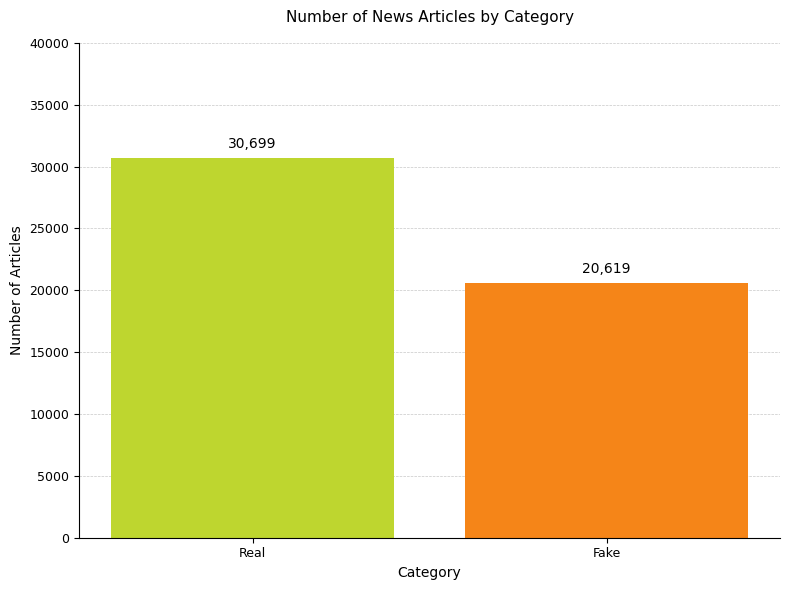

In [49]:
# Number of News Articles per Category

# Create category DataFrame
counts = pd.DataFrame({
    'Category': ['Real'] * len(df_real) + ['Fake'] * len(df_fake)
})

# Get value counts
value_counts = counts['Category'].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(value_counts.index, value_counts.values, color=['#BED62F', '#f58518'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# Styling
ax.set_title("Number of News Articles by Category", fontsize=11, pad=15)
ax.set_ylabel("Number of Articles", fontsize=10)
ax.set_xlabel("Category", fontsize=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_ylim(0, 40000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

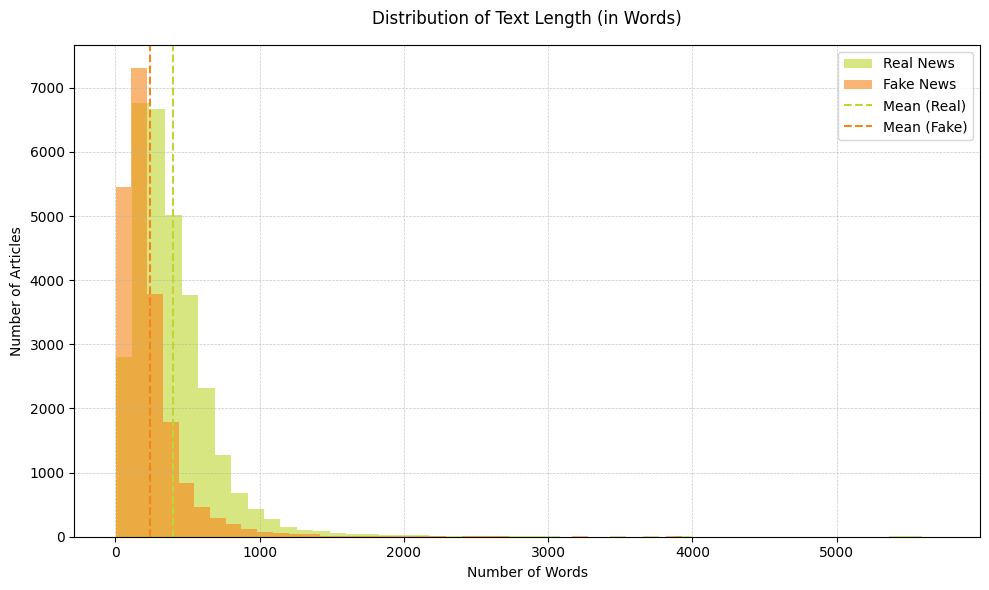

In [50]:
# Calculate word count for each article in both categories

df_real['Word_Count'] = df_real['Text'].fillna("").apply(lambda x: len(str(x).split()))
df_fake['Word_Count'] = df_fake['Text'].fillna("").apply(lambda x: len(str(x).split()))

# Plot histogram of word counts
plt.figure(figsize=(10, 6))
plt.hist(df_real['Word_Count'], bins=50, alpha=0.6, label='Real News', color='#BED62F')
plt.hist(df_fake['Word_Count'], bins=50, alpha=0.6, label='Fake News', color='#f58518')

# Add vertical lines for means
plt.axvline(df_real['Word_Count'].mean(), color='#BED62F', linestyle='--', linewidth=1.5, label='Mean (Real)')
plt.axvline(df_fake['Word_Count'].mean(), color='#f58518', linestyle='--', linewidth=1.5, label='Mean (Fake)')

# Styling
plt.title("Distribution of Text Length (in Words)", fontsize=12, pad=15)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [51]:
print(f"Mean number of words - Real News: {df_real['Word_Count'].mean():.2f}")
print(f"Mean number of words - Fake News: {df_fake['Word_Count'].mean():.2f}")

Mean number of words - Real News: 397.91
Mean number of words - Fake News: 241.62


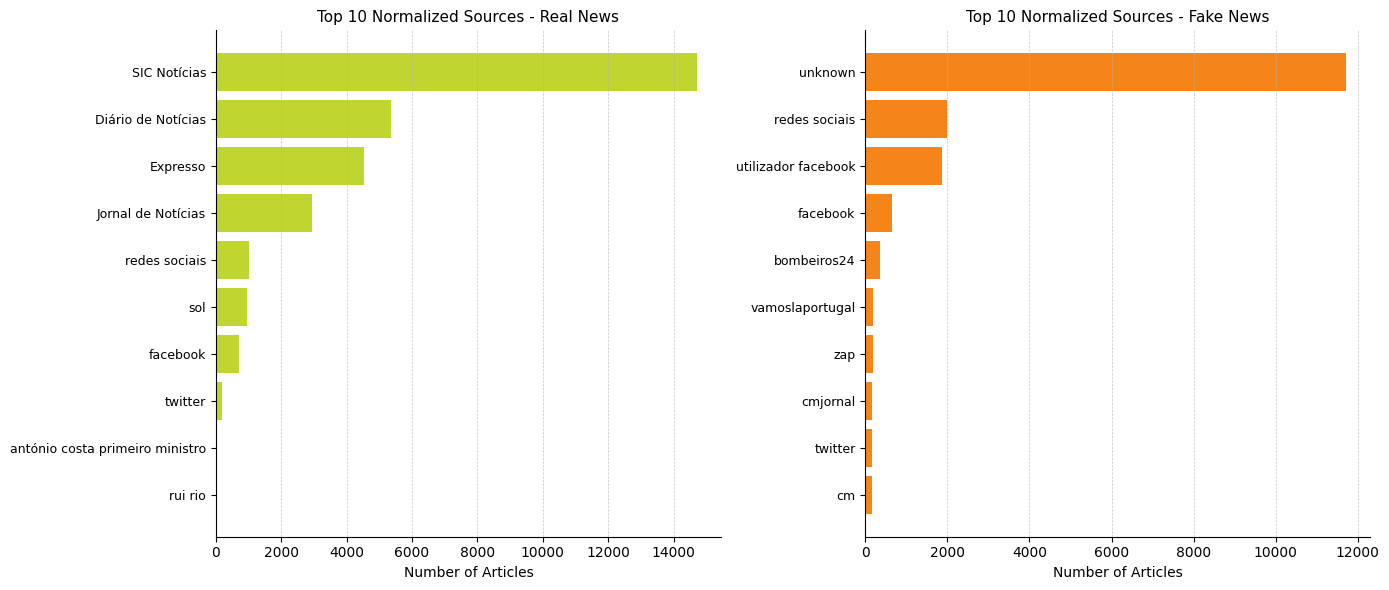

In [52]:
# Get top 10 news sources for each category

top_real_sources = df_real['Normalized_source'].value_counts().nlargest(10)
top_fake_sources = df_fake['Normalized_source'].value_counts().nlargest(10)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Real News plot
axs[0].barh(top_real_sources.index[::-1], top_real_sources.values[::-1], color='#BED62F')
axs[0].set_title("Top 10 Normalized Sources - Real News", fontsize=11)
axs[0].set_xlabel("Number of Articles", fontsize=10)
axs[0].tick_params(axis='y', labelsize=9)

# Fake News plot
axs[1].barh(top_fake_sources.index[::-1], top_fake_sources.values[::-1], color='#f58518')
axs[1].set_title("Top 10 Normalized Sources - Fake News", fontsize=11)
axs[1].set_xlabel("Number of Articles", fontsize=10)
axs[1].tick_params(axis='y', labelsize=9)

# Styling
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

In [53]:
# Cleanup: remove auxiliary column
df_real.drop(columns='Word_Count', inplace=True)
df_fake.drop(columns='Word_Count', inplace=True)

# <span style="color: #FF69B4;">3. Human Dataset</span>

## 3.1 Collect Human-Written News Samples

**Selecting News Articles Samples Written by Humans:**

- In the df_real dataset, news articles will be selected from traditional Portuguese newspapers (e.g., SIC Notícias, Diário de Notícias, Expresso, Jornal de Notícias), where the content is produced by professional human journalists.

- In the df_false dataset, a control group strategy will be implemented. Since ChatGPT was released at the end of 2022 and the dataset includes news up to 2023, the likelihood of AI-generated content remains low. To strengthen this assumption, the control group will consist of articles manually verified to have been published before 2022, thereby eliminating the possibility of AI involvement. 

- Fact-checking websites will be excluded due to their distinct writing style, and texts from the "direita política" source will be ignored, as the links are inaccessible.

In [54]:
human_real = df_real.copy()

In [55]:
human_fake = df_fake.copy()

In [56]:
human_real.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30699 entries, 0 to 30715
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               30699 non-null  string
 1   Source             30699 non-null  string
 2   URL                30699 non-null  string
 3   Normalized_source  30699 non-null  object
dtypes: object(1), string(3)
memory usage: 1.2+ MB


In [57]:
human_fake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20619 entries, 0 to 31542
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               20619 non-null  string
 1   Source             8898 non-null   string
 2   URL                20619 non-null  string
 3   Normalized_source  20619 non-null  object
dtypes: object(1), string(3)
memory usage: 805.4+ KB


In [58]:
human_real['Source'].value_counts().head(20)

Source
SIC Noticias                                        14710
DN                                                   5369
Expresso                                             4532
JN                                                   2945
redes sociais                                        1020
SOL                                                   950
facebook                                              696
twitter                                               187
Rui Rio                                                14
António Costa                                          12
António Costa, Primeiro-Ministro                       10
António Costa, primeiro-ministro                        7
O contexto                                              5
Assunção Cristas                                        5
Assunção Cristas, Líder do CDS                          5
Marcelo Rebelo de Sousa, Presidente da República        4
Catarina Martins                                        4
Rui Rio

In [59]:
human_real['Normalized_source'].value_counts().head(20)

Normalized_source
SIC Notícias                                    14710
Diário de Notícias                               5369
Expresso                                         4532
Jornal de Notícias                               2945
redes sociais                                    1020
sol                                               950
facebook                                          696
twitter                                           187
antónio costa primeiro ministro                    19
rui rio                                            15
antónio costa                                      14
utilizador twitter                                  8
catarina martins coordenadora bloco esquerda        8
catarina martins                                    7
marcelo rebelo sousa presidente república           6
contexto                                            5
rui rio presidente psd                              5
antónio costa primeiro ministro debate              5
utilizador

In [60]:
human_fake['Source'].value_counts().head(20)

Source
redes sociais                1987
facebook                      637
Bombeiros24                   324
ZAP                           178
cmjornal.pt                   173
twitter                       159
CM                            140
vamoslaportugal.com           110
vamoslaportugal.net            84
Jornal Económico               74
Apodrecetuga                   64
Altamente                      55
noticiasaominuto.com           54
Vamos Lá Portugal              33
Muito Fixe                     33
Apodrecetuga.blogspot.com      32
Tugapress                      31
hiper.fm                       29
ECO                            27
Esquerda.net                   26
Name: count, dtype: Int64

In [61]:
human_fake['Normalized_source'].value_counts().head(20)

Normalized_source
unknown                11721
redes sociais           1987
utilizador facebook     1870
facebook                 654
bombeiros24              359
vamoslaportugal          194
zap                      193
cmjornal                 175
twitter                  159
cm                       154
apodrecetuga             144
jornal económico          86
altamente                 74
noticiasaominuto          57
tugapress                 53
muito fixe                50
vamos lá portugal         41
tugaleaks                 35
esquerda                  32
ionline                   31
Name: count, dtype: int64

In [62]:
human_real["Text"].str.split().str.len().describe()


count    30699.000000
mean       397.907815
std        329.591737
min          4.000000
25%        201.000000
50%        330.000000
75%        508.000000
max       5708.000000
Name: Text, dtype: float64

In [63]:
human_fake["Text"].str.split().str.len().describe()

count    20619.000000
mean       241.624376
std        282.181321
min          2.000000
25%        107.000000
50%        179.000000
75%        288.000000
max       5455.000000
Name: Text, dtype: float64

In [64]:
# Process real news articles written by humans

# Define trusted sources that are known to be written by humans
trusted_sources = ["SIC Notícias", "Diário de Notícias", "Expresso", "Jornal de Notícias"]

# Filter the dataset to keep only rows from trusted sources
df_real_human = human_real[human_real["Normalized_source"].isin(trusted_sources)]

# Randomly sample 10,000 articles (or all if less than 10,000 available)
sample_size = min(10000, len(df_real_human))
sample_real_human = df_real_human.sample(n=sample_size, random_state=42)

In [65]:
# Process false news articles written by humans

human_fake['Text_length'] = human_fake['Text'].apply(lambda x: len(x.split()))
human_fake_filtered = human_fake[(human_fake['Text_length'] > 100) & (human_fake['Text_length'] <= 1000)]

# Remove texts that contain 'poligrafo', 'observador', 'publico', or 'direitapolitica' in the URL
human_fake_filtered = human_fake_filtered[
    ~human_fake_filtered['URL'].str.contains('poligrafo|observador|publico|direitapolitica', case=False, na=False)
]

# Determine the number of available texts after filtering
available_texts = len(human_fake_filtered)

# Randomly sample 10,000 articles (or all if less than 10,000 available)
sample_size = min(10000, available_texts)
sample_fake_human = human_fake_filtered.sample(n=sample_size, random_state=42)
sample_fake_human = sample_fake_human.drop(columns=['Text_length'])

# Display the number of texts in the sample
print(f"Number of texts in the sample: {len(sample_fake_human)}")

Number of texts in the sample: 6713


In [66]:
# Control Group
sample_fake_human_control = df_fake_control.copy()

The following row indices were manually selected using Excel. The dataset includes all websites from the original fake news dataset, except Direita Política, as the link is no longer accessible; Lusopt.com; the fact-checking websites Polígrafo, Observador, and Público; and websites without publication dates such as semanario, manazinelusa, and partilhei.com.


In [67]:
# List of rows selected manually from Excel
rows_excel = [6478, 6484, 6498, 6507, 6509, 6520, 6525, 6526, 6533, 6534, 6559, 6572, 8515, 10921, 12567, 14087, 10250, 16312, 30964, 24013]

# Adjust indices for zero-based indexing in Pandas 
adjusted_indices = [i - 2 for i in rows_excel]

# Select the corresponding rows
sample_fake_human_control = sample_fake_human_control.iloc[adjusted_indices]

# Display the resulting DataFrame
print(sample_fake_human_control)

                                                    Text  \
6476   Esta mulher bebeu 3 litros de água por dia dur...   
6482   Médicos e Farmácias roubam 18 milhões ao Estad...   
6496   Cada pessoa come todos os anos plástico equiva...   
6505   Jovem saudita enfrenta pena de morte por se te...   
6507   ALERTA PARA OS HOMENS - Nunca uses o telemóvel...   
6518   O perigo fatal que está escondido em algumas p...   
6523   Tem medo de dentistas? Conheça o SNAP-ON SMILE...   
6524   MARCA PORTUGUESA faz primeiras cápsulas de caf...   
6531   Há pessoas que nascem com o gene das viagens S...   
6532   Se engordaste desde que começaste a namorar, s...   
6557   Desde 2003 que IDOSOS são ABANDONADOS nos hosp...   
6570   Respirar ar poluído retira anos de vida às pes...   
8513   Cristiano Ronaldo quer pagar divida, fisco esp...   
10919  Droga, violência doméstica, depressão: todas a...   
12565  Perca até 12 quilos com limão fervido. Vai fic...   
14085  Os suspeitos de agressões aos jog

In [68]:
sample_real_human['Normalized_source'].value_counts()

Normalized_source
SIC Notícias          5311
Diário de Notícias    1958
Expresso              1641
Jornal de Notícias    1090
Name: count, dtype: int64

In [69]:
sample_fake_human['Normalized_source'].value_counts()

Normalized_source
unknown                          3708
bombeiros24                       353
zap                               181
vamoslaportugal                   179
cm                                142
                                 ... 
petições públicas                   1
kbb                                 1
ainanas                             1
viaestudogeralsibuc                 1
direitapolitica foto capa pnr       1
Name: count, Length: 758, dtype: int64

In [70]:
sample_fake_human_control['Normalized_source'].value_counts() 

Normalized_source
altamente                                     3
zap                                           3
unknown                                       2
cm                                            1
muito fixe                                    1
amilcar freitas                               1
vida extra                                    1
volta ao mundo                                1
sou tão boa                                   1
diploma permitirá libertar camas hospitais    1
ptjornal                                      1
flash                                         1
cura pela natureza                            1
eco                                           1
pplware                                       1
Name: count, dtype: int64

In [71]:
sample_real_human.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 19354 to 27391
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               10000 non-null  string
 1   Source             10000 non-null  string
 2   URL                10000 non-null  string
 3   Normalized_source  10000 non-null  object
dtypes: object(1), string(3)
memory usage: 390.6+ KB


In [72]:
sample_fake_human.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6713 entries, 23531 to 7854
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               6713 non-null   string
 1   Source             3005 non-null   string
 2   URL                6713 non-null   string
 3   Normalized_source  6713 non-null   object
dtypes: object(1), string(3)
memory usage: 262.2+ KB


In [73]:
sample_fake_human_control.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 6476 to 24011
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               20 non-null     string
 1   Source             18 non-null     string
 2   URL                20 non-null     string
 3   Normalized_source  20 non-null     object
dtypes: object(1), string(3)
memory usage: 800.0+ bytes


In [74]:
sample_real_human["Text"].str.split().str.len().describe()


count    10000.000000
mean       414.867900
std        308.594682
min         17.000000
25%        227.000000
50%        356.000000
75%        525.000000
max       5338.000000
Name: Text, dtype: float64

In [75]:
sample_fake_human["Text"].str.split().str.len().describe()

count    6713.000000
mean      292.237748
std       180.575039
min       101.000000
25%       160.000000
50%       235.000000
75%       366.000000
max      1000.000000
Name: Text, dtype: float64

In [76]:
sample_fake_human_control["Text"].str.split().str.len().describe()

count     20.000000
mean     436.500000
std      213.063494
min      180.000000
25%      286.500000
50%      374.500000
75%      573.000000
max      816.000000
Name: Text, dtype: float64

In [77]:
sample_real_human['word_count_text'] = sample_real_human['Text'].fillna("").apply(lambda x: len(str(x).split()))
sample_fake_human['word_count_text'] = sample_fake_human['Text'].fillna("").apply(lambda x: len(str(x).split()))
sample_fake_human_control['word_count_text'] = sample_fake_human_control['Text'].fillna("").apply(lambda x: len(str(x).split()))

In [78]:
sample_real_human['word_count_text'].describe()

count    10000.000000
mean       414.867900
std        308.594682
min         17.000000
25%        227.000000
50%        356.000000
75%        525.000000
max       5338.000000
Name: word_count_text, dtype: float64

In [79]:
sample_fake_human['word_count_text'].describe()

count    6713.000000
mean      292.237748
std       180.575039
min       101.000000
25%       160.000000
50%       235.000000
75%       366.000000
max      1000.000000
Name: word_count_text, dtype: float64

In [80]:
sample_fake_human_control['word_count_text'].describe()

count     20.000000
mean     436.500000
std      213.063494
min      180.000000
25%      286.500000
50%      374.500000
75%      573.000000
max      816.000000
Name: word_count_text, dtype: float64

In [81]:
# Filter rows where the text contains between 12 and 20 words (inclusive)
filtered_texts = sample_real_human[
    sample_real_human["Text"].str.split().str.len().between(12, 20)
]

filtered_texts

Text        Source  \
21399  Os preços das casas continuam a subir
A avalia...  SIC Noticias   
21739  Preço da eletricidade: maioria dos clientes co...  SIC Noticias   
26108  Indústria das carnes em "situação catastrófica...  SIC Noticias   
30487  Governo anuncia medidas de poupança energética...  SIC Noticias   
14388  Um incêndio resultante de confrontos entre gan...            JN   
14232  Neste vídeo Inês Correia explica como se pode ...            JN   
29690  Material escolar tem IVA de 23% e nos hotéis d...  SIC Noticias   
14941  Dezenas de pessoas continuam a ser retiradas e...            JN   
22170  Enfermeiros do IPO de Lisboa em greve pelo des...  SIC Noticias   

                                                     URL   Normalized_source  \
21399  https://sicnoticias.pt/especiais/economiadiaad...        SIC Notícias   
21739  https://sicnoticias.pt/economia/2022-09-16-Pre...        SIC Notícias   
26108  https://sicnoticias.pt/economia/2022-09-13-Ind...        SIC Notícias   
30487  https://sicnoticias.pt/economia/2022-09-28-Gov...        SIC Notícias   
14388  https://www.jn.pt/1868389643/confrontos-entre-...  Jornal de Notícias   
14232  https://www.jn.pt/2313779932/os-precos-estao-a...  Jornal de Notícias   
29690  https://sicnoticias.pt/programas/poligrafo/202...        SIC Notícias   
14941  https://www.jn.pt/3268083600/populacao-de-kher...  Jornal de Notícias   
22170  https://sicnoticias.pt/saude-e-bem-estar/2019-...        SIC Notícias   

       word_count_text  
21399               20  
21739               19  
26108               18  
30487               20  
14388               17  
14232               20  
29690               19  
14941               20  
22170               20

This allowed for a quick manual inspection of the content structure and coherence. The selected examples confirmed that the texts make sense and are suitable for further analysis.

## 3.2 Visualizations

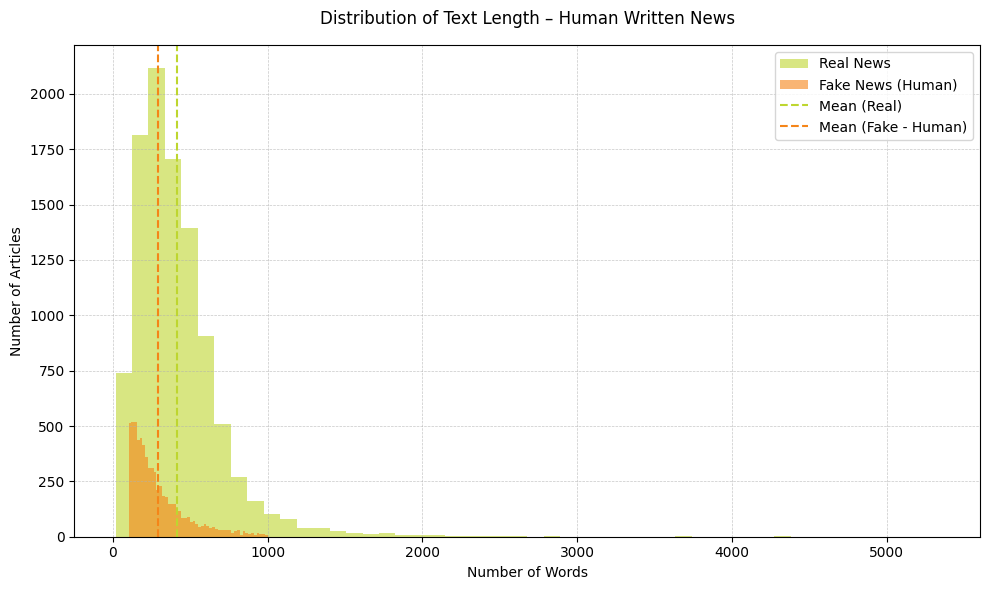

In [82]:
# Plot histogram for word count in news articles
plt.figure(figsize=(10, 6))
plt.hist(sample_real_human['word_count_text'], bins=50, alpha=0.6, label='Real News', color='#BED62F')
plt.hist(sample_fake_human['word_count_text'], bins=50, alpha=0.6, label='Fake News (Human)', color='#f58518')

# Add vertical lines for means
plt.axvline(sample_real_human['word_count_text'].mean(), color='#BED62F', linestyle='--', linewidth=1.5, label='Mean (Real)')
plt.axvline(sample_fake_human['word_count_text'].mean(), color='#f58518', linestyle='--', linewidth=1.5, label='Mean (Fake - Human)')

# Styling
plt.title("Distribution of Text Length – Human Written News", fontsize=12, pad=15)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

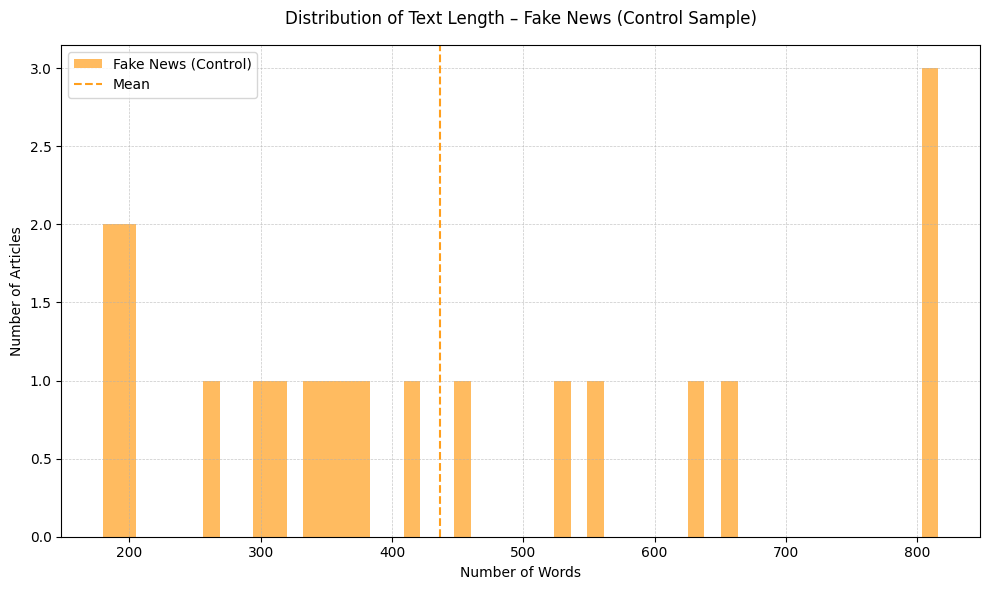

In [83]:
# Compute word count for each article in the control sample
sample_fake_human_control['word_count_text'] = sample_fake_human_control['Text'].fillna("").apply(lambda x: len(str(x).split()))

# Plot
plt.figure(figsize=(10, 6))
plt.hist(sample_fake_human_control['word_count_text'], bins=50, alpha=0.7, label='Fake News (Control)', color='#ff9f1c')

# Add vertical lines for means
plt.axvline(sample_fake_human_control['word_count_text'].mean(), color='#ff9f1c', linestyle='--', linewidth=1.5, label='Mean')

# Styling
plt.title("Distribution of Text Length – Fake News (Control Sample)", fontsize=12, pad=15)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

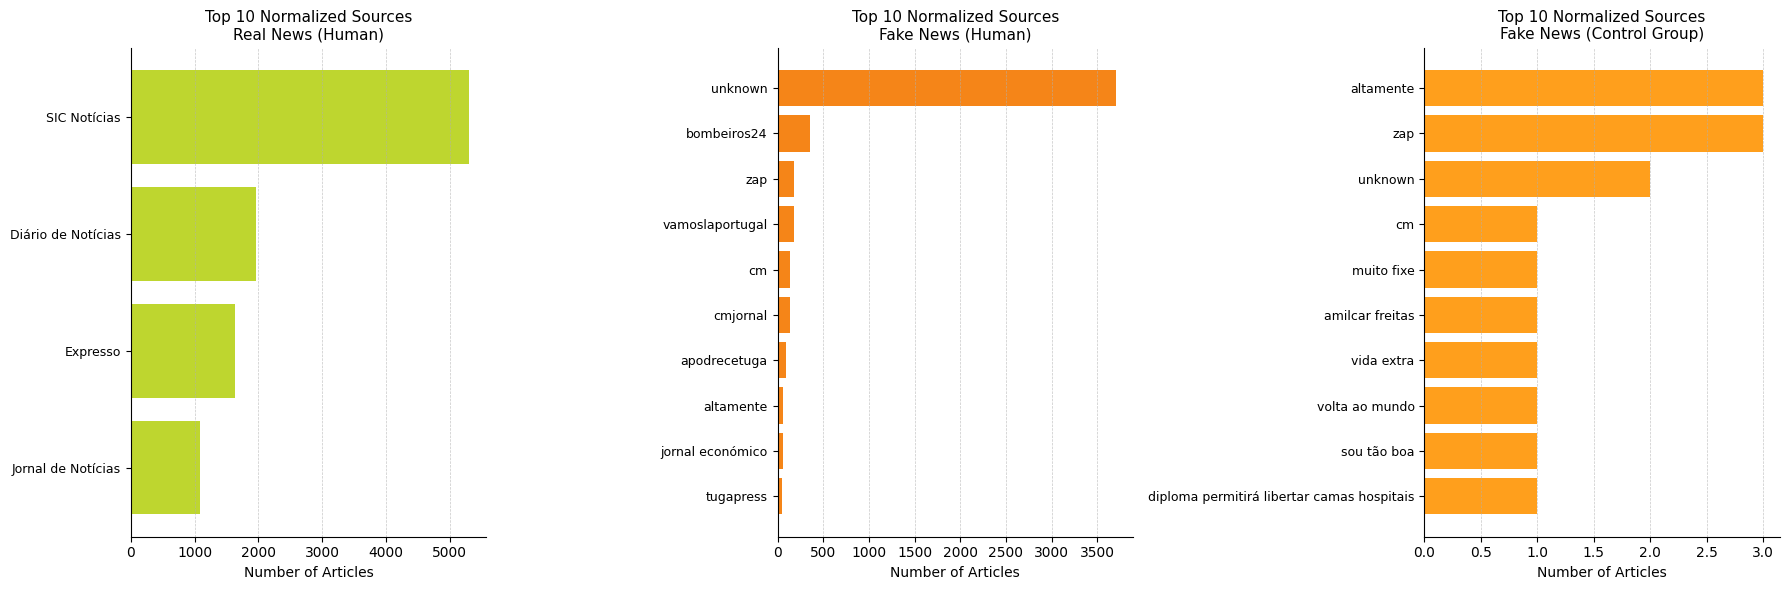

In [84]:
# Get top 10 normalized sources for each group
top_real_sources = sample_real_human['Normalized_source'].value_counts().nlargest(10)
top_fake_sources = sample_fake_human['Normalized_source'].value_counts().nlargest(10)
top_control_sources = sample_fake_human_control['Normalized_source'].value_counts().nlargest(10)

# Set up subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Real News (Human)
axs[0].barh(top_real_sources.index[::-1], top_real_sources.values[::-1], color='#BED62F')
axs[0].set_title("Top 10 Normalized Sources\nReal News (Human)", fontsize=11)
axs[0].set_xlabel("Number of Articles", fontsize=10)
axs[0].tick_params(axis='y', labelsize=9)

# Fake News (Human)
axs[1].barh(top_fake_sources.index[::-1], top_fake_sources.values[::-1], color='#f58518')
axs[1].set_title("Top 10 Normalized Sources\nFake News (Human)", fontsize=11)
axs[1].set_xlabel("Number of Articles", fontsize=10)
axs[1].tick_params(axis='y', labelsize=9)

# Fake News (Control Group)
axs[2].barh(top_control_sources.index[::-1], top_control_sources.values[::-1], color='#ff9f1c')
axs[2].set_title("Top 10 Normalized Sources\nFake News (Control Group)", fontsize=11)
axs[2].set_xlabel("Number of Articles", fontsize=10)
axs[2].tick_params(axis='y', labelsize=9)

# Clean aesthetics
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


## 3.3  Extract Representative Documents by Topic

**Importance:**
- Ensure a representative sample covering various topics, not just one or two themes.
- Avoid redundancy and repetition in the selected texts.
- Eliminate noise from the dataset by focusing on the most relevant and representative documents for each topic.

**Note:** The control group is not included in this step, as the fake news articles in this group were already manually selected and reviewed. Therefore, further topic-based filtering is not necessary.


In [86]:
clean_sample_real_human = sample_real_human.copy()

In [87]:
clean_sample_fake_human = sample_fake_human.copy()

In [88]:
clean_sample_real_human

Text        Source  \
19354  TAP condenada a indemnizar bebé por atraso de ...  SIC Noticias   
28122  “Processo não foi gerido por WhatsApp": Miguel...  SIC Noticias   
25607  Governo britânico abandona planos de redução d...  SIC Noticias   
11074  António Costa: Vitorino prestigiou Portugal e ...      Expresso   
17005  O que estabelece o acordo entre Kremlin e grup...  SIC Noticias   
...                                                  ...           ...   
23857  Jovens portugueses detidos em Maiorca após con...  SIC Noticias   
28437  INE confirma inflação de 8,7% em junho, o valo...  SIC Noticias   
5462   Lucros da CGD quase duplicam no primeiro trime...            DN   
19120  Xiaomi vai despedir cerca de 10% dos seus quad...  SIC Noticias   
27391  Novo recorde: mais de 43 milhões de crianças d...  SIC Noticias   

                                                     URL   Normalized_source  \
19354  https://sicnoticias.pt/pais/2023-06-08-TAP-con...        SIC Notícias   
28122  https://sicnoticias.pt/especiais/tap-o-futuro-...        SIC Notícias   
25607  https://sicnoticias.pt/economia/2022-10-03-Gov...        SIC Notícias   
11074  https://expresso.pt/politica/2023-05-15-Antoni...            Expresso   
17005  https://sicnoticias.pt/especiais/guerra-russia...        SIC Notícias   
...                                                  ...                 ...   
23857  https://sicnoticias.pt/mundo/2023-05-08-Jovens...        SIC Notícias   
28437  https://sicnoticias.pt/economia/2022-07-12-INE...        SIC Notícias   
5462   https://www.dn.pt/dinheiro/lucros-da-cgd-quase...  Diário de Notícias   
19120  https://sicnoticias.pt/economia/2022-12-21-Xia...        SIC Notícias   
27391  https://sicnoticias.pt/mundo/2023-06-20-Novo-r...        SIC Notícias   

       word_count_text  
19354              559  
28122              199  
25607              353  
11074              285  
17005              429  
...                ...  
23857              214  
28437              156  
5462               105  
19120              212  
27391              411  

[10000 rows x 5 columns]

In [89]:
clean_sample_fake_human

Text  \
23531  
Pai de Rosa Grilo constituído arguido

 
O pa...   
6933   A filha morreu e deixou uma carta para lerem s...   
20693  Receita: Massa com Atum no Forno É delicioso! ...   
21940  O Truque da folha de Papel de Alumínio que est...   
23987  
Mãe arrasta o filho com uma trela, as pessoas...   
...                                                  ...   
21889  Conheça o xarope que DERRETE o abdómen e desin...   
23767  
José Sócrates está a morar na Ericeira num ap...   
23804  
Viaturas de António Costa gastam 7000 euros p...   
23994  Ele é o melhor treinador de futebol do mundo d...   
7854   Faleceu aos 15 anos de idade a herdeira do imp...   

                                         Source  \
23531                           noticias.com.pt   
6933                                 muito fixe   
20693                                      <NA>   
21940                                      <NA>   
23987                       vamoslaportugal.net   
...                                         ...   
21889                                      <NA>   
23767                               cmjornal.pt   
23804  direitapolitica.com foto de capa: pnr.pt   
23994                                      <NA>   
7854                                Bombeiros24   

                                                     URL  \
23531  http://www.semanarioextra.com/pai-de-rosa-gril...   
6933   https://arquivo.pt/wayback/20160603030548mp_/h...   
20693  http://www.magazinelusa.com/receita-massa-com-...   
21940  http://www.magazinelusa.com/o-truque-da-folha-...   
23987  http://www.semanarioextra.com/mae-arrasta-o-fi...   
...                                                  ...   
21889  http://www.magazinelusa.com/conheca-o-xarope-q...   
23767  http://www.semanarioextra.com/jose-socrates-es...   
23804  http://www.semanarioextra.com/viaturas-de-anto...   
23994  https://www.tuga.press/ele-e-o-melhor-treinado...   
7854   https://arquivo.pt/wayback/20191218082152mp_/h...   

                   Normalized_source  word_count_text  
23531                       noticias              159  
6933                      muito fixe              429  
20693                        unknown              147  
21940                        unknown              340  
23987                vamoslaportugal              169  
...                              ...              ...  
21889                        unknown              340  
23767                       cmjornal              126  
23804  direitapolitica foto capa pnr              429  
23994                        unknown              240  
7854                     bombeiros24              272  

[6713 rows x 5 columns]

### 3.3.1 Preprocess and Clean Data

#### Text Cleaning

In [90]:
# Function to clean real news text 
def clean_text(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""  # Handle empty or non-string values
    
    # Replace underscores with spaces
    text = text.replace("_", " ")

    # Remove common line breaks (both <br /> and <br/>)
    text = re.sub(r'<br\s*/?>', ' ', text)

    # Remove isolated numbers (but keep years like 2024 if needed)
    text = re.sub(r'\b\d+\b', '', text)

    # Keep only letters, accented characters, and spaces (remove punctuation and special characters)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Convert text to lowercase and remove extra spaces
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces in one step

    return text

In [91]:
# Function to clean fake news text (more aggressive cleaning to reduce noise)
def clean_text_fake(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""  # Avoid fully empty strings
    
    # Remove common line breaks (both <br /> and <br/>)
    text = re.sub(r'<br\s*/?>', ' ', text)

    # Remove isolated numbers (but keep years like 2024 if needed)
    text = re.sub(r'\b\d+\b', '', text)

    # Keep only letters, accented characters, and spaces (remove punctuation and special characters)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)

    # Convert text to lowercase and remove extra spaces
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces in one step

    # Remove single-character words (except "a" and "o" which are valid in Portuguese)
    text = re.sub(r'\b[b-df-hj-np-tv-zB-DF-HJ-NP-TV-ZÀ-ÿ]\b', '', text)  # Avoid removing useful words

    # Remove any leftover multiple spaces again
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [92]:
# Apply text cleaning 
clean_sample_real_human['text_preprocessed'] = clean_sample_real_human['Text'].apply(clean_text)

In [93]:
clean_sample_fake_human['text_preprocessed'] = clean_sample_fake_human['Text'].apply(clean_text_fake)

#### Lemmatization

Lemmatization produced better results than stemming in this project.


In [94]:
# Load a pre-trained spaCy model for the Portuguese language
# This model supports tokenization, lemmatization, and POS tagging
nlp = spacy.load("pt_core_news_lg")  

In [95]:
# Function for lemmatization
def lemmatize_text(text):
    doc = nlp(text) #tokenization
    lemmatized_tokens = [token.lemma_ for token in doc] 
    return " ".join(lemmatized_tokens)

In [96]:
clean_sample_real_human['text_preprocessed'] = clean_sample_real_human['text_preprocessed'].apply(lemmatize_text)

In [97]:
clean_sample_fake_human['text_preprocessed'] = clean_sample_fake_human['text_preprocessed'].apply(lemmatize_text)

#### Stopword Removal

LDA doesn’t analyze sentence structure. It works by identifying patterns in words, so verbs like “ir”, “ter”, “estar”, and “ser” do not add meaningful information to topics.  
Removing them reduces noise and improves the ability to identify key themes.

In [98]:
# Function to remove stopwords from text using spaCy and NLTK's stopword list
def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    stop_words.update({"fazer", "grande", "vez", "começar", "deixar", "acontecer", "pouco", "apenas", "dois", "chegar", "partir", "passar", "trazer", "ouvir", "conseguir",
                       "saber", "agora", "sempre", "algum", "falar",
                       "ir", "de", "este", "ser", "ter", "estar", "haver", "dar", "ver", "vir", "dizer", "ficar", "ainda", "porque", "querer", "após", "sobre", "querer", "outro", "todo", "durante", "onde"}) # Add custom stopwords specific to LDA
    doc = nlp(text)  
    filtered_words = [token.text for token in doc if token.text.lower() not in stop_words]
    return " ".join(filtered_words)

In [99]:
# Apply stopword removal to the preprocessed real news dataset
clean_sample_real_human['text_preprocessed'] = clean_sample_real_human['text_preprocessed'].apply(remove_stopwords)

In [100]:
# Apply stopword removal to the preprocessed fake news dataset
clean_sample_fake_human['text_preprocessed'] = clean_sample_fake_human['text_preprocessed'].apply(remove_stopwords)

In [101]:
clean_sample_real_human 

Text        Source  \
19354  TAP condenada a indemnizar bebé por atraso de ...  SIC Noticias   
28122  “Processo não foi gerido por WhatsApp": Miguel...  SIC Noticias   
25607  Governo britânico abandona planos de redução d...  SIC Noticias   
11074  António Costa: Vitorino prestigiou Portugal e ...      Expresso   
17005  O que estabelece o acordo entre Kremlin e grup...  SIC Noticias   
...                                                  ...           ...   
23857  Jovens portugueses detidos em Maiorca após con...  SIC Noticias   
28437  INE confirma inflação de 8,7% em junho, o valo...  SIC Noticias   
5462   Lucros da CGD quase duplicam no primeiro trime...            DN   
19120  Xiaomi vai despedir cerca de 10% dos seus quad...  SIC Noticias   
27391  Novo recorde: mais de 43 milhões de crianças d...  SIC Noticias   

                                                     URL   Normalized_source  \
19354  https://sicnoticias.pt/pais/2023-06-08-TAP-con...        SIC Notícias   
28122  https://sicnoticias.pt/especiais/tap-o-futuro-...        SIC Notícias   
25607  https://sicnoticias.pt/economia/2022-10-03-Gov...        SIC Notícias   
11074  https://expresso.pt/politica/2023-05-15-Antoni...            Expresso   
17005  https://sicnoticias.pt/especiais/guerra-russia...        SIC Notícias   
...                                                  ...                 ...   
23857  https://sicnoticias.pt/mundo/2023-05-08-Jovens...        SIC Notícias   
28437  https://sicnoticias.pt/economia/2022-07-12-INE...        SIC Notícias   
5462   https://www.dn.pt/dinheiro/lucros-da-cgd-quase...  Diário de Notícias   
19120  https://sicnoticias.pt/economia/2022-12-21-Xia...        SIC Notícias   
27391  https://sicnoticias.pt/mundo/2023-06-20-Novo-r...        SIC Notícias   

       word_count_text                                  text_preprocessed  
19354              559  tap condenar indemnizar bebé atraso voo apesar...  
28122              199  processo gerir whatsapp Miguel Pinto luz defen...  
25607              353  governo britânico abandonar plano redução impo...  
11074              285  António Costa vitorino prestigiar Portugal oim...  
17005              429  estabelecer acordo kremlin grupo wagner recuo ...  
...                ...                                                ...  
23857              214  jovem português deter maiorca confronto violen...  
28437              156  ine confirmar inflação junho valor alto desde ...  
5462               105  lucro cgd quase duplicar primeiro trimestre re...  
19120              212  xiaomi despedir cerca quadro venda smartphone ...  
27391              411  novo recorde milhão criança deslocar mundo par...  

[10000 rows x 6 columns]

In [102]:
clean_sample_fake_human

Text  \
23531  
Pai de Rosa Grilo constituído arguido

 
O pa...   
6933   A filha morreu e deixou uma carta para lerem s...   
20693  Receita: Massa com Atum no Forno É delicioso! ...   
21940  O Truque da folha de Papel de Alumínio que est...   
23987  
Mãe arrasta o filho com uma trela, as pessoas...   
...                                                  ...   
21889  Conheça o xarope que DERRETE o abdómen e desin...   
23767  
José Sócrates está a morar na Ericeira num ap...   
23804  
Viaturas de António Costa gastam 7000 euros p...   
23994  Ele é o melhor treinador de futebol do mundo d...   
7854   Faleceu aos 15 anos de idade a herdeira do imp...   

                                         Source  \
23531                           noticias.com.pt   
6933                                 muito fixe   
20693                                      <NA>   
21940                                      <NA>   
23987                       vamoslaportugal.net   
...                                         ...   
21889                                      <NA>   
23767                               cmjornal.pt   
23804  direitapolitica.com foto de capa: pnr.pt   
23994                                      <NA>   
7854                                Bombeiros24   

                                                     URL  \
23531  http://www.semanarioextra.com/pai-de-rosa-gril...   
6933   https://arquivo.pt/wayback/20160603030548mp_/h...   
20693  http://www.magazinelusa.com/receita-massa-com-...   
21940  http://www.magazinelusa.com/o-truque-da-folha-...   
23987  http://www.semanarioextra.com/mae-arrasta-o-fi...   
...                                                  ...   
21889  http://www.magazinelusa.com/conheca-o-xarope-q...   
23767  http://www.semanarioextra.com/jose-socrates-es...   
23804  http://www.semanarioextra.com/viaturas-de-anto...   
23994  https://www.tuga.press/ele-e-o-melhor-treinado...   
7854   https://arquivo.pt/wayback/20191218082152mp_/h...   

                   Normalized_source  word_count_text  \
23531                       noticias              159   
6933                      muito fixe              429   
20693                        unknown              147   
21940                        unknown              340   
23987                vamoslaportugal              169   
...                              ...              ...   
21889                        unknown              340   
23767                       cmjornal              126   
23804  direitapolitica foto capa pnr              429   
23994                        unknown              240   
7854                     bombeiros24              272   

                                       text_preprocessed  
23531  pai Rosa grilo constituir arguido pai Rosa Gri...  
6933   filha morrer carta ler inacreditável inacredit...  
20693  receita massa atum forno delicioso és fã massa...  
21940  truque folha papel alumínio encantar cabeleire...  
23987  mãe arrastar filho trela pessoa chocar vêla ví...  
...                                                  ...  
21889  conhecer xarope derretir abdómen desinchar cor...  
23767  José sócrate morar ericeira apartamento vista ...  
23804  viatura António Costa gastar euro mês combustí...  
23994  bom treinador futebol mundo ano português mour...  
7854   falecer ano idade herdeira império família ric...  

[6713 rows x 6 columns]

In [103]:
# Check for duplicate preprocessed texts in the fake news dataset
duplicates = clean_sample_fake_human["text_preprocessed"].duplicated().sum()
print(f"Number of duplicated texts: {duplicates}")

Number of duplicated texts: 52


In [104]:
clean_sample_fake_human = clean_sample_fake_human.drop_duplicates(subset="text_preprocessed", keep="first")
clean_sample_fake_human = clean_sample_fake_human.reset_index(drop=True)

To improve topic modeling quality, duplicate texts were removed again from the fake news dataset after the full preprocessing pipeline (cleaning, stopword removal, and lemmatization). This step was necessary because some duplicated texts persisted even after earlier deduplication, likely due to differences in punctuation or formatting that were normalized during preprocessing. The real news dataset was not affected, as it did not contain significant duplication after preprocessing.


### 3.3.2 Text Representation – Numeric Encoding

**Standard Bag-of-Words**

Unigrams and bigrams (n=1,2) are used. Only bigrams that appear at least 5 times in the corpus are included, and tokens (unigrams or bigrams) that appear in fewer than 5 documents are removed.  

In [105]:
real_human_bow_2 = clean_sample_real_human.copy()

In [106]:
fake_human_bow = clean_sample_fake_human.copy()

In [107]:
# Function to preprocess text and generate Bag-of-Words representation
def preprocess_and_generate_bow(df):
    # Tokenize text
    df["tokenized_text"] = df["text_preprocessed"].apply(lambda x: [token.text for token in nlp(x)])

    # Create bigram model (detects frequent word pairs, keeps only those appearing >5 times)
    bigram_model = Phrases(df["tokenized_text"], min_count=5, threshold=5)
    bigram_phraser = Phraser(bigram_model)

    # Apply bigram transformation
    df["tokenized_text"] = df["tokenized_text"].apply(lambda x: bigram_phraser[x])

    # Create dictionary (word-to-ID mapping)
    id2word = corpora.Dictionary(df["tokenized_text"])

    # Remove words and bigrams that appear in fewer than 5 documents
    id2word.filter_extremes(no_below=5)

    # Convert text corpus into Bag-of-Words format (list of (word_id, word_count) tuples)
    corpus = [id2word.doc2bow(text) for text in df["tokenized_text"]]

    return df, id2word, corpus

In [108]:
# Apply the preprocessing and BOW transformation to both datasets
real_human_bow_2, id2word_real, corpus_real = preprocess_and_generate_bow(real_human_bow_2)
fake_human_bow, id2word_fake, corpus_fake = preprocess_and_generate_bow(fake_human_bow)

**Notes:**

- This method (n=1,2, min_freq=5) provides a good balance between preserving meaningful words and reducing noise.
- Unigrams capture individual important words.
- Bigrams capture frequent multi-word expressions, improving topic interpretability.
- Filtering out words that appear in fewer than 5 documents reduces sparsity and prevents rare terms from distorting topic modeling.
- TF-IDF was not used, as it changes word weights and disrupts LDA’s natural use of co-occurrence patterns.


### 3.3.3 LDA – Latent Dirichlet Allocation

#### Topic Coherence Score

In [109]:
# Function to compute coherence scores for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, start=4, limit=20, step=2):
    """Find the optimal number of topics using coherence score."""
    coherence_values = []
    topic_range = range(start, limit + 1, step)
    
    for num_topics in topic_range:
        lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=num_topics,
                                           random_state=42,
                                           passes=10)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return topic_range, coherence_values

# Function to plot coherence scores
def plot_coherence_scores(topic_range, coherence_values, title):
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherence_values, marker='o')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title(title)
    plt.grid(True)
    plt.show()

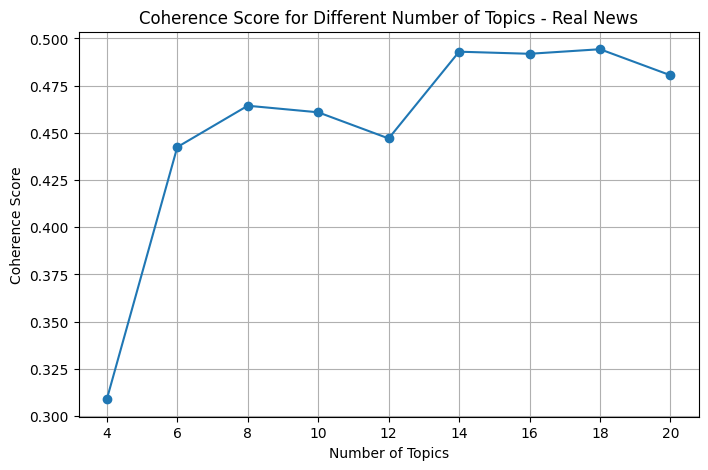

In [110]:
# Compute and plot coherence scores for Real News 
topic_range_real, coherence_values_real = compute_coherence_values(id2word_real, corpus_real, real_human_bow_2["tokenized_text"])
plot_coherence_scores(topic_range_real, coherence_values_real, "Coherence Score for Different Number of Topics - Real News")

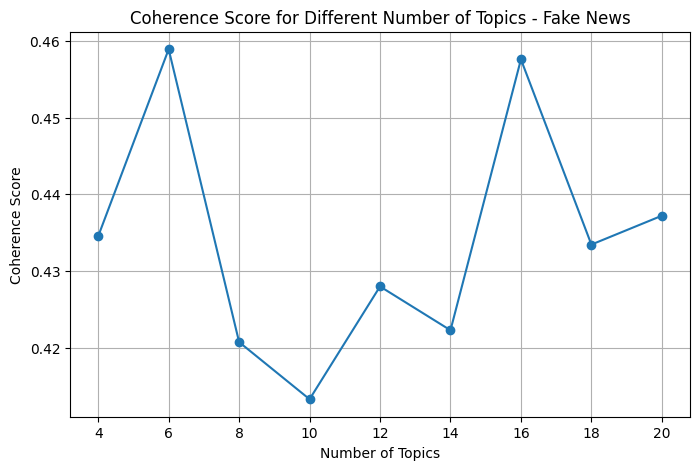

In [111]:
# Compute and plot coherence scores for Fake News
topic_range_fake, coherence_values_fake = compute_coherence_values(id2word_fake, corpus_fake, fake_human_bow["tokenized_text"])
plot_coherence_scores(topic_range_fake, coherence_values_fake, "Coherence Score for Different Number of Topics - Fake News")

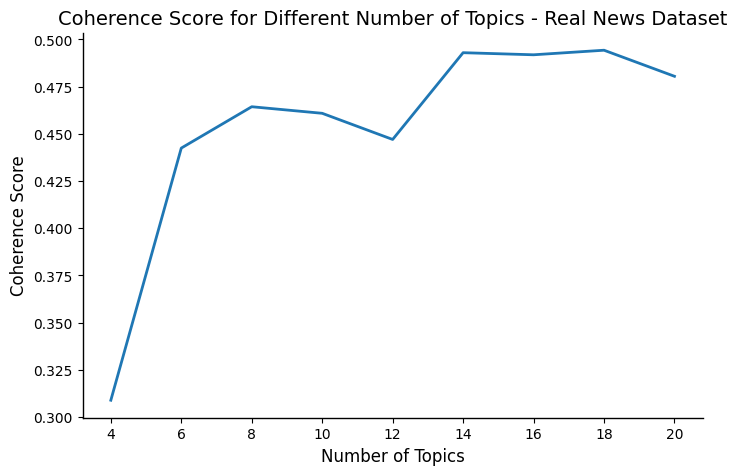

In [112]:
# Function to plot coherence scores (cleaner style)
def plot_coherence_scores_no_markers(topic_range, coherence_values, title, save=False):
    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherence_values, linestyle='-', linewidth=2) 
    plt.xlabel("Number of Topics", fontsize=12, color='black')
    plt.ylabel("Coherence Score", fontsize=12, color='black')
    plt.title(title, fontsize=14, color='black')
    plt.grid(False)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.spines["left"].set_color("black")  
    ax.spines["bottom"].set_color("black")  
    ax.spines["left"].set_linewidth(1)  
    ax.spines["bottom"].set_linewidth(1)  
    ax.tick_params(axis='both', colors='black')
    
    plt.gca().set_facecolor('white') 
    plt.gcf().set_facecolor('white')
    
    if save:
        base_name = title.lower().replace(" ", "_").replace("-", "").replace("—", "")
        plt.savefig(f"{base_name}.svg", format='svg', bbox_inches='tight', dpi=1200)
        plt.savefig(f"{base_name}.pdf", format='pdf', bbox_inches='tight', dpi=1200)

    plt.show()

# Plot coherence scores for each dataset
plot_coherence_scores_no_markers(topic_range_real, coherence_values_real, "Coherence Score for Different Number of Topics - Real News Dataset", save=True)

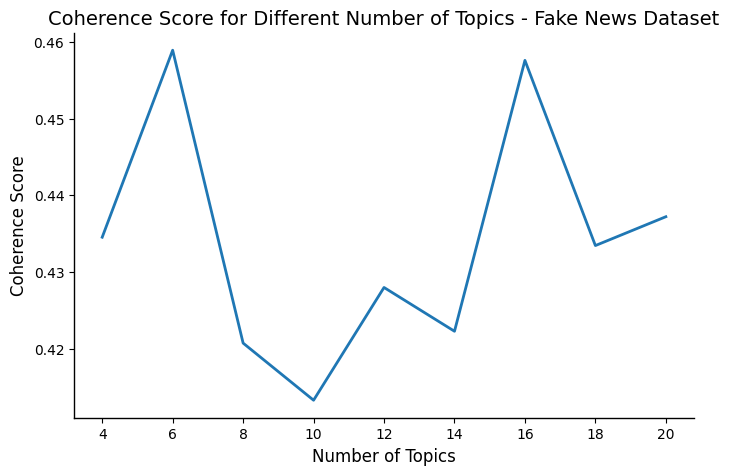

In [113]:
plot_coherence_scores_no_markers(topic_range_fake, coherence_values_fake, "Coherence Score for Different Number of Topics - Fake News Dataset", save=True)

In [114]:
# Find the optimal number of topics for each dataset
optimal_num_topics_real = topic_range_real[coherence_values_real.index(max(coherence_values_real))]

# Print the optimal number of topics for each dataset
print(f"Optimal number of topics for Real News (Human): {optimal_num_topics_real}")

Optimal number of topics for Real News (Human): 18


In [115]:
optimal_num_topics_fake = topic_range_fake[coherence_values_fake.index(max(coherence_values_fake))]
print(f"Optimal number of topics for Fake News: {optimal_num_topics_fake}")

Optimal number of topics for Fake News: 6


In [116]:
# Function to find the optimal and second highest coherence peaks
def find_optimal_topics(topic_range, coherence_values):
    coherence_array = np.array(coherence_values)

    # Find the index of the highest coherence score (first peak)
    max_idx = np.argmax(coherence_array)
    optimal_num_topics = topic_range[max_idx]  # Corresponding number of topics

    # Find the second highest coherence score (excluding the first peak)
    sorted_indices = np.argsort(coherence_array)[::-1]  # Sort indices in descending order
    second_max_idx = sorted_indices[1]  # Second highest index
    second_optimal_num_topics = topic_range[second_max_idx]  # Corresponding number of topics

    return (optimal_num_topics, coherence_array[max_idx], 
            second_optimal_num_topics, coherence_array[second_max_idx])

# Compute optimal topics for Fake News dataset
optimal_real, score_real, second_optimal_real, second_score_real = find_optimal_topics(topic_range_real, coherence_values_real)
optimal_fake, score_fake, second_optimal_fake, second_score_fake = find_optimal_topics(topic_range_fake, coherence_values_fake)

# Print the results for each dataset
print(f"Real News - Optimal topics: {optimal_real} (Score: {score_real:.4f})")
print(f"Real News - Second peak: {second_optimal_real} (Score: {second_score_real:.4f})\n")

Real News - Optimal topics: 18 (Score: 0.4943)
Real News - Second peak: 14 (Score: 0.4930)



In [117]:
optimal_num_topics_real = 14

In [118]:
optimal_fake, score_fake, second_optimal_fake, second_score_fake = find_optimal_topics(topic_range_fake, coherence_values_fake)
print(f"Fake News - Optimal topics: {optimal_fake} (Score: {score_fake:.4f})")
print(f"Fake News - Second peak: {second_optimal_fake} (Score: {second_score_fake:.4f})\n")

Fake News - Optimal topics: 6 (Score: 0.4589)
Fake News - Second peak: 16 (Score: 0.4576)



In [119]:
optimal_num_topics_fake = 16

Although the coherence score was slightly higher for 18 topics in the real news dataset and for 6 topics in the fake news dataset, the second-best options (14 and 16 topics) were chosen for the final models.  

This decision was based on the following reasoning:
- The coherence scores between the two peaks were very close (e.g., 0.4943 vs. 0.4930 for real news, and 0.4589 vs. 0.4576 for fake news), showing no substantial drop in quality.
- Choosing 14 topics instead of 18 helps avoid excessive fragmentation and produces more interpretable topic groups.
- In the fake news case, 6 topics felt too limited to capture the diversity of the content. Choosing 16 topics allowed for richer representation without sacrificing coherence.

#### LDA

In [120]:
# Train LDA Model with optimized parameters for the real news dataset
lda_model_real_human = gensim.models.LdaModel(
    corpus=corpus_real,
    id2word=id2word_real,
    num_topics=optimal_num_topics_real,  # Optimal number of topics found from coherence score
    random_state=42,  # Ensures reproducibility of results
    passes=10,  # Number of times the model processes the entire dataset
    iterations=200,  # Higher iterations improve convergence and topic stability
    alpha='auto',  # Automatically adjusts topic distribution per document
    minimum_probability=0.01,  # Filters out topics with very low probability
)

In [121]:
# Train LDA Model with optimized parameters for the fake news dataset
lda_model_fake = gensim.models.LdaModel(
    corpus=corpus_fake,
    id2word=id2word_fake,
    num_topics=optimal_num_topics_fake ,  # Optimal number of topics found from coherence score
    random_state=42,  # Ensures reproducibility of results
    passes=10,  # Number of times the model processes the entire dataset
    iterations=200,  # Higher iterations improve convergence and topic stability
    alpha='auto',  # Automatically adjusts topic distribution per document
    minimum_probability=0.01,  # Filters out topics with very low probability
)

This function selects the most representative documents for each topic based on the dominant topic assigned to each document. Documents are ranked according to their relevance scores, and the top n documents per topic are returned. Note that all topics are treated equally, with no weighting applied.

In [122]:
# Function to get the most representative documents per topic
def get_top_documents_per_topic(lda_model, corpus, texts, num_topics, num_docs):
    """Find the most representative documents for each topic."""
    topic_docs = {i: [] for i in range(num_topics)}

    for i, doc in enumerate(corpus):
        topic_distribution = lda_model[doc]  # Get topic distribution for the document
        dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]  # Find dominant topic

        topic_docs[dominant_topic].append((i, topic_distribution))  # Store document index and topic scores

    # Select the most representative documents for each topic
    top_docs_per_topic = {}
    for topic, docs in topic_docs.items():
        sorted_docs = sorted(docs, key=lambda x: max(x[1], key=lambda y: y[1])[1], reverse=True)[:num_docs]
        top_docs_per_topic[topic] = [texts[i] for i, _ in sorted_docs]

    return top_docs_per_topic

In [123]:
# Get top 10 representative documents per topic (Real News)
top_docs_real_human = get_top_documents_per_topic(
    lda_model_real_human,
    corpus_real,
    clean_sample_real_human["text_preprocessed"].tolist(),  # Use processed text for correct matches
    optimal_num_topics_real,
    num_docs=10
)

# Convert results into a structured DataFrame
df_top_docs = pd.DataFrame([(topic+1, doc) for topic, docs in top_docs_real_human.items() for doc in docs],
                           columns=["Topic", "Representative Document"])

# Merge to retrieve the original text and metadata
df_top_docs = df_top_docs.merge(
    clean_sample_real_human[["Text", "text_preprocessed", "Source", "URL", "word_count_text", "Normalized_source"]],
    left_on="Representative Document",  # Matching processed text
    right_on="text_preprocessed",  # Ensuring correct alignment
    how="left"
)

# Keep relevant columns only
df_top_docs = df_top_docs[["Topic", "Text", "Source", "URL", "word_count_text", "Normalized_source"]]

# Display final results
print(df_top_docs)

     Topic                                               Text        Source  \
0        1  Associação da Hotelaria defende apoio à habita...  SIC Noticias   
1        1  ASAE vai liderar monitorização dos preços
Para...            DN   
2        1  Inflação: ASAE vai liderar monitorização dos p...  SIC Noticias   
3        1  Governo limita aumento das rendas a 2%
António...  SIC Noticias   
4        1  AHP defende apoio à habitação isento de IRS e ...            DN   
..     ...                                                ...           ...   
135     14  Alcaraz vence torneio de Londres e vai subir a...            DN   
136     14  United garante Champions com goleada sobre o C...            DN   
137     14  A seleção italiana desforrou-se da goleada sof...            JN   
138     14  Maria Martins quarta classificada na quarta et...            DN   
139     14  Nápoles sagra-se campeão italiano 33 anos depo...            DN   

                                                   

In [124]:
# Get top 12 representative documents per topic (Fake News)
top_docs_fake = get_top_documents_per_topic(
    lda_model_fake,
    corpus_fake,
    clean_sample_fake_human["text_preprocessed"].tolist(),  # Use processed text for correct matches
    optimal_num_topics_fake,
    num_docs=12
)

# Convert results into a structured DataFrame
df_top_docs_fake = pd.DataFrame([(topic+1, doc) for topic, docs in top_docs_fake.items() for doc in docs],
                                columns=["Topic", "Representative Document"])

# Merge to retrieve the original text and metadata
df_top_docs_fake = df_top_docs_fake.merge(
    clean_sample_fake_human[["Text", "text_preprocessed", "Source", "URL", "word_count_text", "Normalized_source"]],
    left_on="Representative Document",  # Matching processed text
    right_on="text_preprocessed",  # Ensuring correct alignment
    how="left"
)

# Keep relevant columns only
df_top_docs_fake = df_top_docs_fake[["Topic", "Text", "Source", "URL", "word_count_text", "Normalized_source"]]

# Display final results
print(df_top_docs_fake)

     Topic                                               Text  \
0        1  A EDP teve 18 milhões de prejuízo. A administr...   
1        1  Assunção Esteves com 10 anos de serviço tem di...   
2        1  Assunção Esteves com 10 anos de serviço tem di...   
3        1  Com 10 anos de serviço tem direito a reforma s...   
4        1  Bancos aumentam até 18% a comissão da prestaçã...   
..     ...                                                ...   
187     16  Receita “bomba” para reduzir a cintura e a gor...   
188     16  Os alimentos que limpam as artérias e impedem ...   
189     16  Os alimentos que limpam as artérias e impedem ...   
190     16  Os alimentos que limpam as artérias e impedem ...   
191     16  Os alimentos que limpam as artérias e impedem ...   

                       Source  \
0                  Tuga Press   
1    apodrecetuga.blogspot.pt   
2               Vai dar Zebra   
3                  Tuga Press   
4                idealista.pt   
..                   

In [125]:
# Print the top words for each topic in Real News model
for topic in range(optimal_num_topics_real):
    print(f"Topic {topic+1}: {lda_model_real_human.print_topic(topic)}")

Topic 1: 0.015*"governo" + 0.014*"medida" + 0.009*"euro" + 0.009*"poder" + 0.008*"habitação" + 0.006*"apoio" + 0.005*"valor" + 0.005*"preço" + 0.005*"proposta" + 0.004*"família"
Topic 2: 0.011*"caso" + 0.010*"tribunal" + 0.009*"processo" + 0.008*"investigação" + 0.007*"ministério_público" + 0.005*"justiça" + 0.005*"acusar" + 0.005*"psp" + 0.005*"advogado" + 0.005*"crime"
Topic 3: 0.018*"governo" + 0.009*"poder" + 0.008*"partido" + 0.008*"tap" + 0.006*"considerar" + 0.006*"ps" + 0.006*"psd" + 0.006*"político" + 0.005*"afirmar" + 0.005*"primeiroministro"
Topic 4: 0.011*"Lisboa" + 0.011*"cidade" + 0.008*"local" + 0.007*"zona" + 0.006*"água" + 0.006*"ano" + 0.005*"porto" + 0.005*"espaço" + 0.004*"região" + 0.004*"autarquia"
Topic 5: 0.015*"ano" + 0.009*"vítima" + 0.007*"autoridade" + 0.007*"polícia" + 0.006*"segundo" + 0.006*"local" + 0.006*"morrer" + 0.006*"homem" + 0.005*"encontrar" + 0.005*"pessoa"
Topic 6: 0.015*"nato" + 0.011*"turquia" + 0.009*"incêndio" + 0.007*"erdogan" + 0.007*"def

In [126]:
# Print the top words for each topic in Fake News model
for topic_id in range(optimal_num_topics_fake):
    print(f"Topic {topic_id + 1}: {lda_model_fake.print_topic(topic_id)}")

Topic 1: 0.021*"ano" + 0.011*"euro" + 0.007*"banco" + 0.006*"programa" + 0.005*"poder" + 0.005*"valor" + 0.005*"milhão_euro" + 0.005*"pagar" + 0.005*"assim" + 0.004*"novo"
Topic 2: 0.012*"mulher" + 0.011*"vida" + 0.010*"casa" + 0.009*"família" + 0.009*"dia" + 0.008*"filho" + 0.008*"ano" + 0.008*"tudo" + 0.008*"mãe" + 0.007*"homem"
Topic 3: 0.016*"Portugal" + 0.015*"país" + 0.013*"poder" + 0.006*"português" + 0.006*"ano" + 0.006*"caso" + 0.005*"pessoa" + 0.005*"afirmar" + 0.004*"considerar" + 0.004*"contra"
Topic 4: 0.017*"água" + 0.013*"poder" + 0.010*"praia" + 0.008*"casa" + 0.008*"usar" + 0.006*"colocar" + 0.005*"produto" + 0.005*"dever" + 0.005*"roupa" + 0.005*"pequeno"
Topic 5: 0.015*"km_radar" + 0.011*"Lisboa" + 0.008*"estrada" + 0.006*"zona" + 0.006*"câmara" + 0.006*"preço" + 0.006*"concelho" + 0.005*"cidade" + 0.005*"local" + 0.005*"restaurante"
Topic 6: 0.024*"poder" + 0.022*"pessoa" + 0.012*"bom" + 0.008*"dever" + 0.007*"coisa" + 0.006*"mulher" + 0.006*"pois" + 0.005*"vida" + 

In [127]:
def extract_lda_topics(lda_model, corpus, num_topics):
    
    topics_data = []
    topic_word_distributions = lda_model.show_topics(num_topics=num_topics, formatted=False)

    # Get topic distribution across all documents
    topic_distribution = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

    # Count topic occurrences
    topic_counts = [0] * num_topics
    total_docs = len(topic_distribution)

    if total_docs > 0:
        for doc_topics in topic_distribution:
            for topic_id, prob in doc_topics:
                topic_counts[topic_id] += prob  # Sum probabilities for each topic

        # Compute topic frequency percentage
        topic_frequencies = [round((count / total_docs) * 100, 2) for count in topic_counts]
    else:
        topic_frequencies = [0] * num_topics  # Avoid ZeroDivisionError

    # Extract the top 10 keywords per topic
    for topic_id, word_distribution in topic_word_distributions:
        # Sort words by weight (importance) and extract the top 10
        sorted_words = sorted(word_distribution, key=lambda x: x[1], reverse=True)[:10]
        keywords = ", ".join([word for word, _ in sorted_words])

        topics_data.append([topic_id + 1, keywords, f"{topic_frequencies[topic_id]}%"])  

    # Create a structured DataFrame
    df_topics = pd.DataFrame(topics_data, columns=["Topic", "Top 10 Keywords", "Frequency"])

    return df_topics

# Extract topics for REAL NEWS 
df_real_topics = extract_lda_topics(lda_model_real_human, corpus_real, optimal_num_topics_real)

# Extract topics for FAKE NEWS 
df_fake_topics = extract_lda_topics(lda_model_fake, corpus_fake, optimal_num_topics_fake)

In [128]:
# Temporarily expand column display to show full keyword lists
pd.set_option('display.max_colwidth', None)  

In [129]:
df_real_topics

Topic  \
0       1   
1       2   
2       3   
3       4   
4       5   
5       6   
6       7   
7       8   
8       9   
9      10   
10     11   
11     12   
12     13   
13     14   

                                                                                       Top 10 Keywords  \
0                      governo, medida, euro, poder, habitação, apoio, valor, preço, proposta, família   
1    caso, tribunal, processo, investigação, ministério_público, justiça, acusar, psp, advogado, crime   
2               governo, poder, partido, tap, considerar, ps, psd, político, afirmar, primeiroministro   
3                             Lisboa, cidade, local, zona, água, ano, porto, espaço, região, autarquia   
4                   ano, vítima, autoridade, polícia, segundo, local, morrer, homem, encontrar, pessoa   
5           nato, turquia, incêndio, erdogan, defesa, dia, país, segurança, aliança, aliança_atlântico   
6                     ucrânia, russo, Rússia, rússia, ucraniano, país, guerra, militar, china, Moscovo   
7                            poder, saúde, ano, médico, serviço, pessoa, dia, trabalho, novo, hospital   
8                            poder, ano, pessoa, estudo, doença, caso, criança, Portugal, país, doente   
9                    país, europeu, ue, polícia, contra, França, união_europeu, francês, protesto, ano   
10  poder, Estados_Unidos, norteamericano, EUA, mundo, vacina, Brasil, incluir, primeiro, investigação   
11                empresa, euro, ano, milhão_euro, Portugal, aumentar, valor, banco, mercado, inflação   
12         português, Portugal, poder, dia, ano, país, pessoa, presidente_república, presidente, Sousa   
13                           jogo, equipa, ano, clube, segundo, jogador, Benfica, final, primeiro, bom   

   Frequency  
0      7.02%  
1      4.42%  
2     11.54%  
3      6.44%  
4      6.11%  
5      2.14%  
6      6.93%  
7     13.98%  
8      8.43%  
9      6.98%  
10     4.84%  
11     9.57%  
12     7.04%  
13     4.54%

In [130]:
df_fake_topics

Topic  \
0       1   
1       2   
2       3   
3       4   
4       5   
5       6   
6       7   
7       8   
8       9   
9      10   
10     11   
11     12   
12     13   
13     14   
14     15   
15     16   

                                                                              Top 10 Keywords  \
0                   ano, euro, banco, programa, poder, valor, milhão_euro, pagar, assim, novo   
1                              mulher, vida, casa, família, dia, filho, ano, tudo, mãe, homem   
2            Portugal, país, poder, português, ano, caso, pessoa, afirmar, considerar, contra   
3                     água, poder, praia, casa, usar, colocar, produto, dever, roupa, pequeno   
4        km_radar, Lisboa, estrada, zona, câmara, preço, concelho, cidade, local, restaurante   
5                           poder, pessoa, bom, dever, coisa, mulher, pois, vida, tudo, tempo   
6     carro, poder, veículo, caso, automóvel, cliente, combustível, dever, situação, condutor   
7       empresa, Portugal, estado, poder, português, serviço, euro, caso, trabalhador, número   
8          tribunal, arguido, massa, leite, condenar, minuto, farinha, julgamento, juiz, juíz   
9          sistema, modelo, tecnologia, novo, energia, aparelho, poder, bateria, marca, preço   
10           governo, deputado, euro, político, partido, milhão_euro, psd, ps, imposto, valor   
11                  médico, hospital, dia, poder, avião, doente, novo, seguir, perna, momento   
12                mundo, pessoa, vídeo, ano, parecer, mostrar, novo, dia, primeiro, encontrar   
13  português, jogador, nome, jogo, clube, processo, ronaldo, advogado, cr, cristiano_ronaldo   
14                       criança, pai, ano, filho, homem, jovem, mãe, mulher, encontrar, bebé   
15          poder, corpo, dia, doença, saúde, cancro, alimento, além, tratamento, medicamento   

   Frequency  
0      9.52%  
1     13.28%  
2      7.51%  
3      5.13%  
4      3.16%  
5      9.21%  
6      4.39%  
7      7.16%  
8       1.9%  
9      2.22%  
10     5.18%  
11     4.88%  
12     8.71%  
13     3.58%  
14     8.83%  
15     5.34%

In [131]:
# Reset to default column width display
pd.reset_option('display.max_colwidth')

In [132]:
# Compute coherence score for LDA model on real news
coherence_model_lda = CoherenceModel(model=lda_model_real_human, texts=real_human_bow_2["tokenized_text"], dictionary=id2word_real, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score (Real News):", coherence_lda)


Coherence Score (Real News): 0.479743888901735


In [133]:
# Compute coherence score for LDA model on fake news
coherence_model_fake = CoherenceModel(model=lda_model_fake, texts=fake_human_bow["tokenized_text"], dictionary=id2word_fake, coherence='c_v')
coherence_fake = coherence_model_fake.get_coherence()
print("\nCoherence Score (Fake News):", coherence_fake)


Coherence Score (Fake News): 0.4336188921799359


In [137]:
# Prepare interactive LDA visualization for real news
lda_display = gensimvis.prepare(lda_model_real_human, corpus_real, id2word_real, sort_topics=False)

# Display interactive visualization 
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, 'lda_real_news.html')

In [138]:
# Prepare interactive LDA visualization for fake news
lda_display_fake = gensimvis.prepare(lda_model_fake, corpus_fake, id2word_fake, sort_topics=False)

# Display interactive visualization 
pyLDAvis.display(lda_display_fake)

pyLDAvis.save_html(lda_display_fake, 'lda_fake_news.html')

In [ ]:
"""# Define the file path
file_path = 

# Save the dataset as an Excel file
df_top_docs.to_excel(file_path, index=False)"""

In [ ]:
"""# Define the file path
file_path = r""

# Save the dataset as an Excel file
df_top_docs_fake.to_excel(file_path, index=False)"""

In [ ]:
"""file_path = r""
sample_fake_human_control.to_excel(file_path, index=False)"""

## 3.4 Exploration and Visualization of the Final Human Datasets After Manual Review, Text Cleaning, and Prompt Creation

### 3.4.1 Manual Review, Dataset Cleaning and Prompt Creation Notes

**General Cleaning:**
- Removed titles and sentences that were inconsistent or unclear to ensure a clean, coherent, and consistent dataset.
- Some entire news items were deleted.
- Removed links from the text and descriptions from images.
- Dropped the column word_count_text, as the values no longer reflected the cleaned content.

**Fake News:**
- 12 news items per topic.
- Added new columns: "Prompt (New)", "Topic" (based on text content and top keywords), "Purpose", and "Evidence".
- Topic 9 was excluded because it mostly contained recipe-related content rather than fake news.
- Removed random news items that were not fake news.
- Topic 14 was originally related to sports, but included unrelated texts. The few genuine sports articles were removed. This topic was renamed to "Polémicas".
- Removed many repeated news articles to ensure uniqueness.
- Final count: 103 news items selected from the original 192.

**Real News:**
- 10 news items per topic.
- Added new columns: "Prompt (New)", "Topic" (based on text content and top keywords), "Purpose", and "Evidence".
- Topic 5 was split into two distinct topics: “Euribor” and “Accidents”.
- Final count: 103 news items selected from the original 140.

**Control Group:**
- Verified links and publication dates to ensure the dataset contains only human-written content.
- Manually added columns: "Website", "Original Date", and "Arquivo.pt Date", along with "Prompt (New)", "Purpose", and "Evidence".


**Narrative Prompt Creation:**

The creation of narrative prompts was guided by Narrative Theory, which distinguishes between two key components of a narrative:

- Story: Refers to the main events and entities involved (e.g., actions, people, places).

- Discourse: Refers to how the story is communicated and in this case includes type, purpose and evidence.

### 3.4.2 Visualizations

In [139]:
# Real News
human_real_news_final = pd.read_excel("Final_real_human_data.xlsx")
# Fake News
human_fake_news_final = pd.read_excel("Final_fake_human_data.xlsx")
# Fake News Control
human_fake_news_control_final = pd.read_excel("Final_fake_human_data_control.xlsx")

In [140]:
human_real_news_final.head(2)

Topic                                               Text        Source  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...  SIC Noticias   
1      1  Para conter o impacto da inflação, o Governo l...            DN   

                                                 URL   Normalized_source  \
0  https://sicnoticias.pt/economia/2023-03-21-Ass...        SIC Notícias   
1  https://www.dn.pt/dinheiro/asae-vai-liderar-mo...  Diário de Notícias   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   
1  Escreve uma notícia a relatar as medidas lança...  Apoios Governamentais   

  Purpose  Evidence  
0  Relatar  Citação  
1  Relatar  Citação

In [141]:
human_fake_news_final.head(2)

Topic                                               Text  \
0      1  No ano passado ele ganhou 2.2 milhões de euros...   
1      1  Assunção Esteves com 10 anos de serviço tem di...   

                     Source  \
0                Tuga Press   
1  apodrecetuga.blogspot.pt   

                                                 URL Normalized_source  \
0  https://arquivo.pt/wayback/20190415223737mp_/h...        tuga press   
1  http://www.magazinelusa.com/assuncao-esteves-c...      apodrecetuga   

                                        Prompt (New)  \
0  Escreve uma notícia sobre como a EDP teve prej...   
1  Escreve uma notícia a comentar como Assunção E...   

                     Topic definition   Purpose  Evidence  
0  Poder Económico e Dinheiro Público    Relatar      NaN  
1  Poder Económico e Dinheiro Público  Comentar       NaN

In [142]:
human_fake_news_control_final.head(2)

Text     Source  \
0  Esta mulher decidiu beber 3 litros de água por...  altamente   
1  Em apenas um mês, Dezembro de 2015, o Serviço ...         cm   

                                                 URL Normalized_source  \
0  https://arquivo.pt/wayback/20160603024458mp_/h...         altamente   
1  https://arquivo.pt/wayback/20160208092526mp_/h...                cm   

          Website Original Date Arquivo.pt Date  \
0  Lusojornal2015    2016-05-01      2016-06-01   
1  Lusojornal2016    2016-01-01      2016-02-01   

                                        Prompt (New)  Purpose        Evidence  
0  Escreve uma notícia a comentar como uma mulher...  Comentar        Citação  
1  Escreve uma notícia a relatar um esquema de fr...   Relatar  De acordo com

In [143]:
human_real_news_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Topic              103 non-null    int64 
 1   Text               103 non-null    object
 2   Source             103 non-null    object
 3   URL                103 non-null    object
 4   Normalized_source  103 non-null    object
 5   Prompt (New)       103 non-null    object
 6   Topic definition   103 non-null    object
 7   Purpose            103 non-null    object
 8   Evidence           76 non-null     object
dtypes: int64(1), object(8)
memory usage: 7.4+ KB


In [144]:
human_fake_news_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Topic              103 non-null    int64 
 1   Text               103 non-null    object
 2   Source             47 non-null     object
 3   URL                103 non-null    object
 4   Normalized_source  103 non-null    object
 5   Prompt (New)       103 non-null    object
 6   Topic definition   103 non-null    object
 7   Purpose            103 non-null    object
 8   Evidence           48 non-null     object
dtypes: int64(1), object(8)
memory usage: 7.4+ KB


In [145]:
human_fake_news_control_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Text               20 non-null     object        
 1   Source             18 non-null     object        
 2   URL                20 non-null     object        
 3   Normalized_source  20 non-null     object        
 4   Website            20 non-null     object        
 5   Original Date      14 non-null     datetime64[ns]
 6   Arquivo.pt Date    19 non-null     datetime64[ns]
 7   Prompt (New)       20 non-null     object        
 8   Purpose            20 non-null     object        
 9   Evidence           18 non-null     object        
dtypes: datetime64[ns](2), object(8)
memory usage: 1.7+ KB


In [146]:
human_real_news_final['Topic definition'].unique()

array(['Apoios Governamentais', 'Justiça e Investigação', 'Governo e TAP',
       'Meteorologia e Lazer', 'Taxa Euribor', 'Ocorrências Fatais',
       'NATO e Segurança Global', 'Rússia e Ucrânia', 'Saúde e Trabalho',
       'Doenças e Ciência', 'Protestos em França', 'Outro',
       'Estados Unidos ', 'Economia em Portugal', 'Política Portuguesa',
       'Desporto'], dtype=object)

In [147]:
human_fake_news_final['Topic definition'].unique()

array(['Poder Económico e Dinheiro Público', 'Histórias de Famílias',
       'Portugal/UE', 'Truques Caseiros e Soluções Práticas',
       'Radares e outros temas do dia a dia em Portugal',
       'Crenças Populares', 'Automóveis e Cidadania', 'Corrupção',
       'Tecnologia e Dicas', 'Política Nacional ',
       'Saúde e Outros Assuntos', 'Viral e Curioso\t', 'Polémicas',
       'Tragédias (Familiares)', 'Saúde e Tratamentos '], dtype=object)

In [148]:
text_columns = ['Text', 'Source', 'URL', 'Normalized_source', 'Prompt (New)', 'Topic definition', 'Purpose ', 'Evidence']
human_real_news_final[text_columns] = human_real_news_final[text_columns].astype("string")
human_fake_news_final[text_columns] = human_fake_news_final[text_columns].astype("string")

In [149]:
text_columns = ['Text', 'Source', 'URL', 'Normalized_source', 'Prompt (New)', 'Purpose ', 'Evidence']
human_fake_news_control_final[text_columns] = human_fake_news_control_final[text_columns].astype("string")

In [150]:
# Calculate word count for final cleaned datasets
human_real_news_final['word_count_text'] = human_real_news_final['Text'].fillna("").apply(lambda x: len(str(x).split()))
human_fake_news_final['word_count_text'] = human_fake_news_final['Text'].fillna("").apply(lambda x: len(str(x).split()))
human_fake_news_control_final['word_count_text'] = human_fake_news_control_final['Text'].fillna("").apply(lambda x: len(str(x).split()))

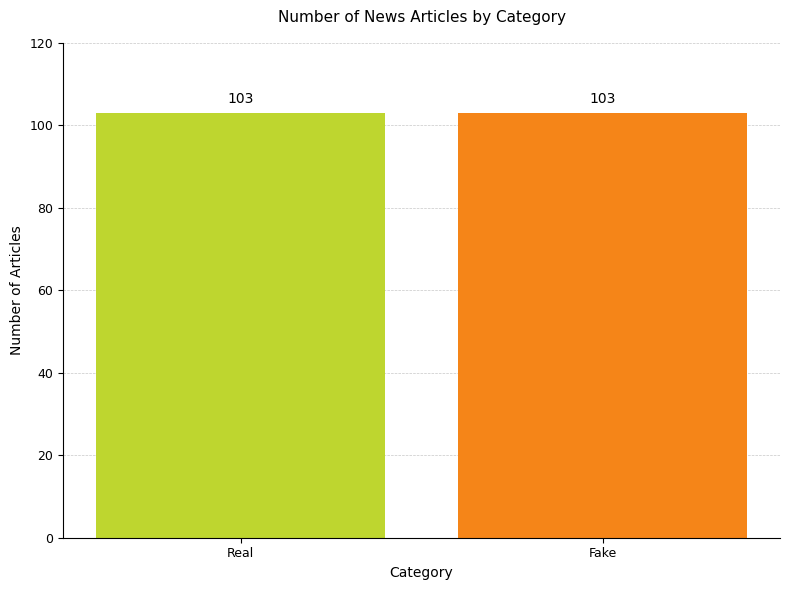

In [151]:
# Create category DataFrame
counts = pd.DataFrame({
    'Category': ['Real'] * len(human_real_news_final) + ['Fake'] * len(human_fake_news_final)
})

# Get value counts
value_counts = counts['Category'].value_counts()

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(value_counts.index, value_counts.values, color=['#BED62F', '#f58518'])

# Add count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:,}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5), 
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=10)

# Styling
ax.set_title("Number of News Articles by Category", fontsize=11, pad=15)
ax.set_ylabel("Number of Articles", fontsize=10)
ax.set_xlabel("Category", fontsize=10)
ax.tick_params(axis='both', labelsize=9)
ax.set_ylim(0, 120)

# Clean aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


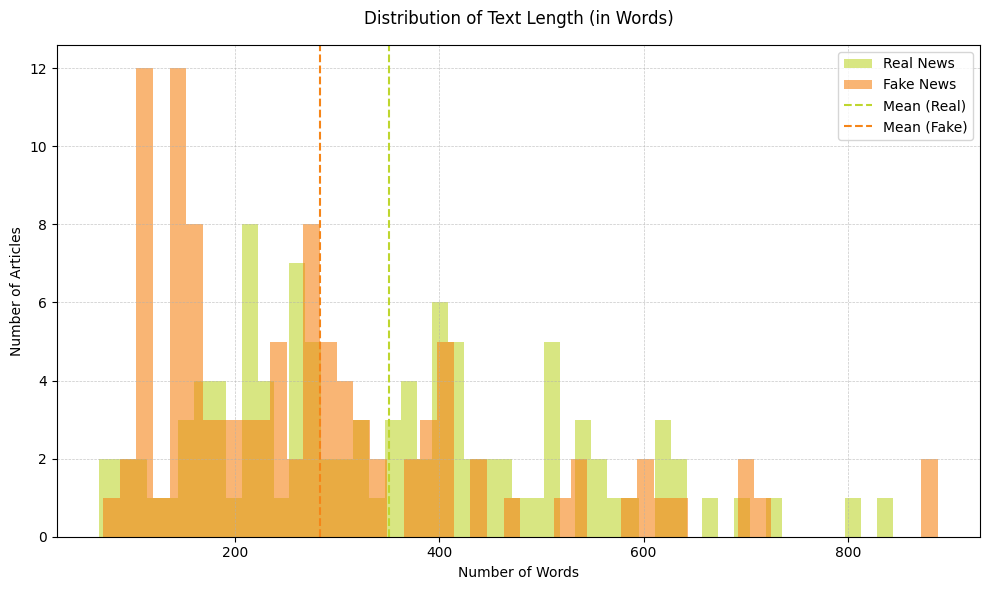

In [152]:
# Plot histograms of text length for real and fake news
plt.figure(figsize=(10, 6))
plt.hist(human_real_news_final['word_count_text'], bins=50, alpha=0.6, label='Real News', color='#BED62F')
plt.hist(human_fake_news_final['word_count_text'], bins=50, alpha=0.6, label='Fake News', color='#f58518')

# Add vertical lines to indicate mean word count for each category
plt.axvline(human_real_news_final['word_count_text'].mean(), color='#BED62F', linestyle='--', linewidth=1.5, label='Mean (Real)')
plt.axvline(human_fake_news_final['word_count_text'].mean(), color='#f58518', linestyle='--', linewidth=1.5, label='Mean (Fake)')

plt.title("Distribution of Text Length (in Words)", fontsize=12, pad=15)
plt.xlabel("Number of Words", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [153]:
# Print average number of words per article for each category
print(f"Mean number of words - Real News: {human_real_news_final['word_count_text'].mean():.2f}")
print(f"Mean number of words - Fake News: {human_fake_news_final['word_count_text'].mean():.2f}")

Mean number of words - Real News: 351.31
Mean number of words - Fake News: 283.72


Aligned with the initial analysis for consistency in text length comparison.

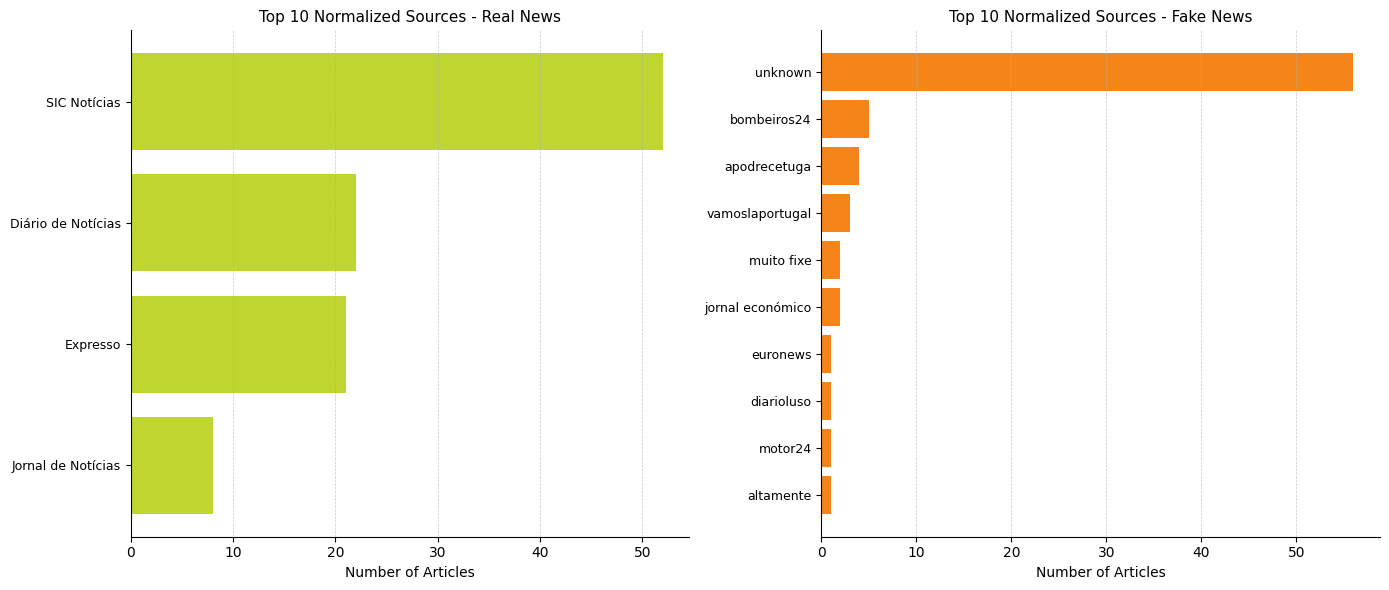

In [154]:
# Get top 10 most frequent normalized sources for real and fake news
top_real_sources = human_real_news_final['Normalized_source'].value_counts().nlargest(10)
top_fake_sources = human_fake_news_final['Normalized_source'].value_counts().nlargest(10)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Real News
axs[0].barh(top_real_sources.index[::-1], top_real_sources.values[::-1], color='#BED62F')
axs[0].set_title("Top 10 Normalized Sources - Real News", fontsize=11)
axs[0].set_xlabel("Number of Articles", fontsize=10)
axs[0].tick_params(axis='y', labelsize=9)

# Fake News
axs[1].barh(top_fake_sources.index[::-1], top_fake_sources.values[::-1], color='#f58518')
axs[1].set_title("Top 10 Normalized Sources - Fake News", fontsize=11)
axs[1].set_xlabel("Number of Articles", fontsize=10)
axs[1].tick_params(axis='y', labelsize=9)

# Clean aesthetics
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(True, axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

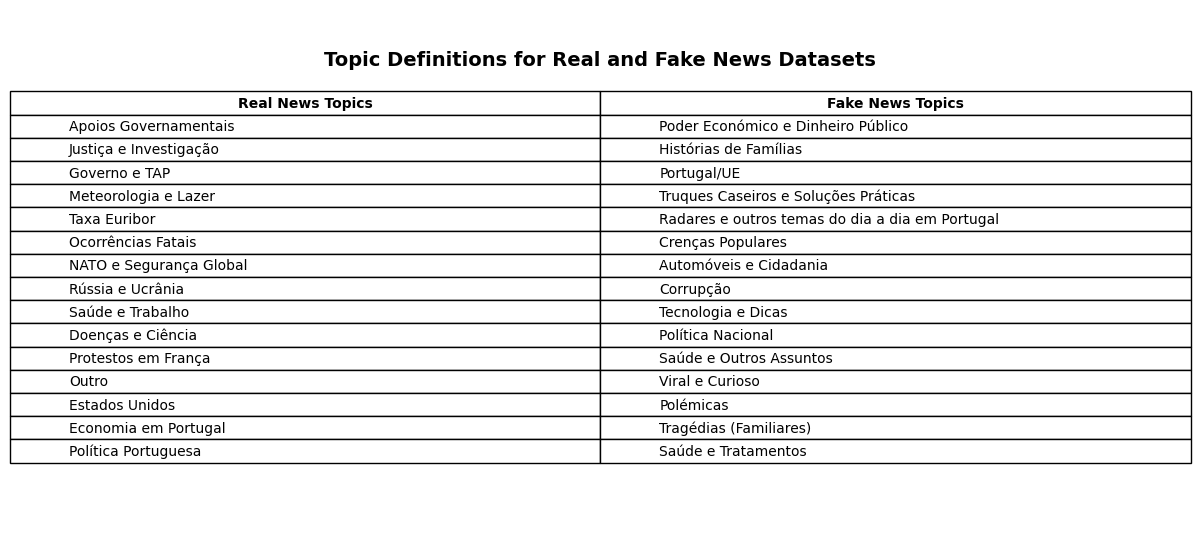

In [155]:
# Lists of topics
real_topics = [
    'Apoios Governamentais', 'Justiça e Investigação', 'Governo e TAP',
    'Meteorologia e Lazer', 'Taxa Euribor', 'Ocorrências Fatais',
    'NATO e Segurança Global', 'Rússia e Ucrânia', 'Saúde e Trabalho',
    'Doenças e Ciência', 'Protestos em França', 'Outro',
    'Estados Unidos', 'Economia em Portugal', 'Política Portuguesa',
    'Desporto'
]

fake_topics = [
    'Poder Económico e Dinheiro Público', 'Histórias de Famílias',
    'Portugal/UE', 'Truques Caseiros e Soluções Práticas',
    'Radares e outros temas do dia a dia em Portugal',
    'Crenças Populares', 'Automóveis e Cidadania', 'Corrupção',
    'Tecnologia e Dicas', 'Política Nacional',
    'Saúde e Outros Assuntos', 'Viral e Curioso',
    'Polémicas', 'Tragédias (Familiares)', 'Saúde e Tratamentos'
]

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

# Match topic lengths
table_data = list(zip(real_topics + [''] * (len(fake_topics) - len(real_topics)),
                      fake_topics))

# Create table with bold headers
table = ax.table(
    cellText=table_data,
    colLabels=['Real News Topics', 'Fake News Topics'],
    cellLoc='left',
    loc='center'
)

# Set font size and bold headers
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Set header cells to bold
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')

# Title (bold and closer to table)
plt.suptitle('Topic Definitions for Real and Fake News Datasets',
             fontsize=14, weight='bold', y=0.85)

plt.tight_layout()
plt.show()

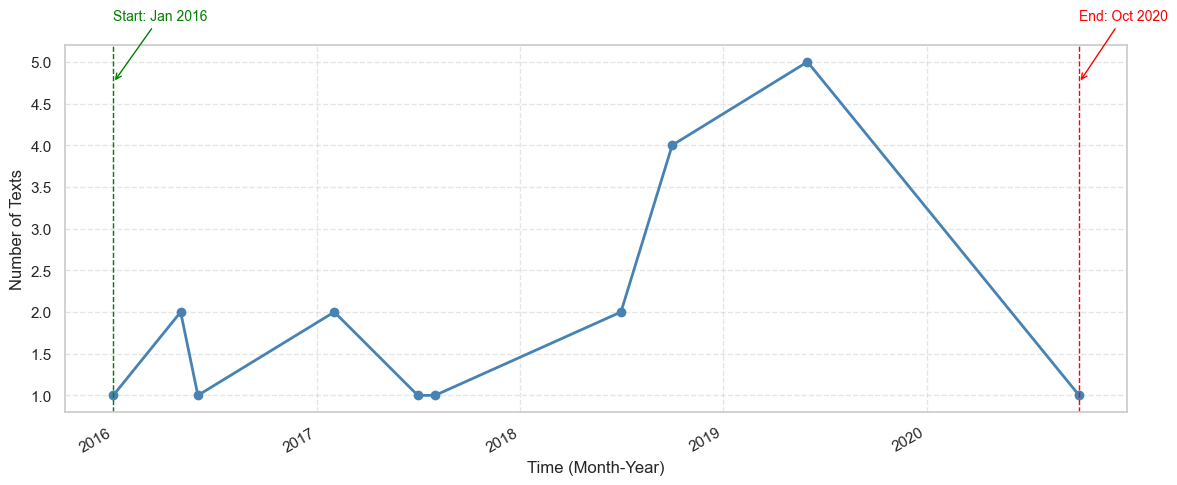

In [156]:
# Apply a visual style
sns.set(style="whitegrid")

# Convert both date columns to datetime
human_fake_news_control_final['Original Date'] = pd.to_datetime(
    human_fake_news_control_final['Original Date'], errors='coerce'
)
human_fake_news_control_final['Arquivo.pt Date'] = pd.to_datetime(
    human_fake_news_control_final['Arquivo.pt Date'], errors='coerce'
)

# Use 'Original Date' when available, otherwise fall back to 'Arquivo.pt Date'
human_fake_news_control_final['Date Used'] = human_fake_news_control_final['Original Date'].fillna(
    human_fake_news_control_final['Arquivo.pt Date']
)

# Drop rows with no date at all (just in case)
df = human_fake_news_control_final.dropna(subset=['Date Used']).copy()

# Get the earliest and latest dates
min_date = df['Date Used'].min()
max_date = df['Date Used'].max()

# Create monthly distribution
df['YearMonth'] = df['Date Used'].dt.to_period('M')
counts = df['YearMonth'].value_counts().sort_index()
counts.index = counts.index.to_timestamp()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(counts.index, counts.values, marker='o', linestyle='-', linewidth=2, color='steelblue')

# Add vertical lines
ax.axvline(min_date, color='green', linestyle='--', linewidth=1)
ax.axvline(max_date, color='red', linestyle='--', linewidth=1)

# Annotate start and end
ax.annotate(f'Start: {min_date.strftime("%b %Y")}',
             xy=(min_date, max(counts.values) * 0.95),
             xytext=(min_date, max(counts.values) + 0.5),
             arrowprops=dict(arrowstyle='->', color='green'),
             color='green', fontsize=10)

ax.annotate(f'End: {max_date.strftime("%b %Y")}',
             xy=(max_date, max(counts.values) * 0.95),
             xytext=(max_date, max(counts.values) + 0.5),
             arrowprops=dict(arrowstyle='->', color='red'),
             color='red', fontsize=10)

# Labels and formatting
ax.set_title("", fontsize=14, weight='bold')
ax.set_xlabel("Time (Month-Year)", fontsize=12)
ax.set_ylabel("Number of Texts", fontsize=12)
plt.xticks(rotation=45)
ax.grid(True, linestyle='--', alpha=0.5)
fig.autofmt_xdate()
fig.tight_layout()

# Save and show plot
fig.savefig("temporal_distribution.svg", format="svg", dpi=1200, bbox_inches='tight')
fig.savefig("temporal_distribution.pdf", format="pdf", bbox_inches='tight')
plt.show()

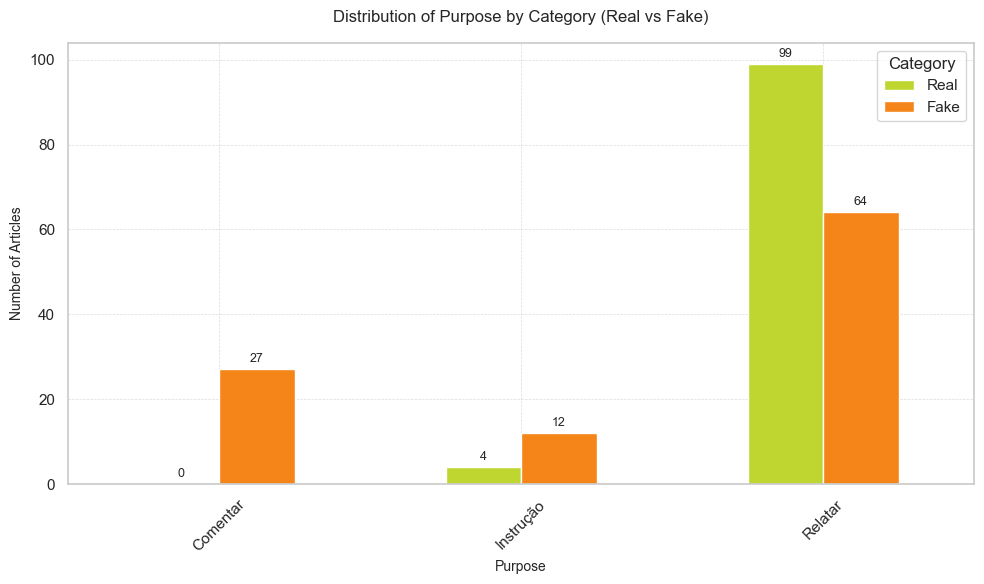

In [157]:
# Strip extra spaces from column names (only needed once)
human_real_news_final.columns = human_real_news_final.columns.str.strip()
human_fake_news_final.columns = human_fake_news_final.columns.str.strip()

# Strip spaces from 'Purpose' values
human_real_news_final['Purpose'] = human_real_news_final['Purpose'].str.strip()
human_fake_news_final['Purpose'] = human_fake_news_final['Purpose'].str.strip()

# Count values by purpose for each category
purpose_real = human_real_news_final['Purpose'].value_counts()
purpose_fake = human_fake_news_final['Purpose'].value_counts()

# Combine counts into a DataFrame
purpose_df = pd.DataFrame({
    'Real': purpose_real,
    'Fake': purpose_fake
}).fillna(0).astype(int)

# Plot
ax = purpose_df.plot(kind='bar', figsize=(10, 6), color=['#BED62F', '#f58518'])

plt.title("Distribution of Purpose by Category (Real vs Fake)", fontsize=12, pad=15)
plt.xlabel("Purpose", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(title='Category')
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.show()

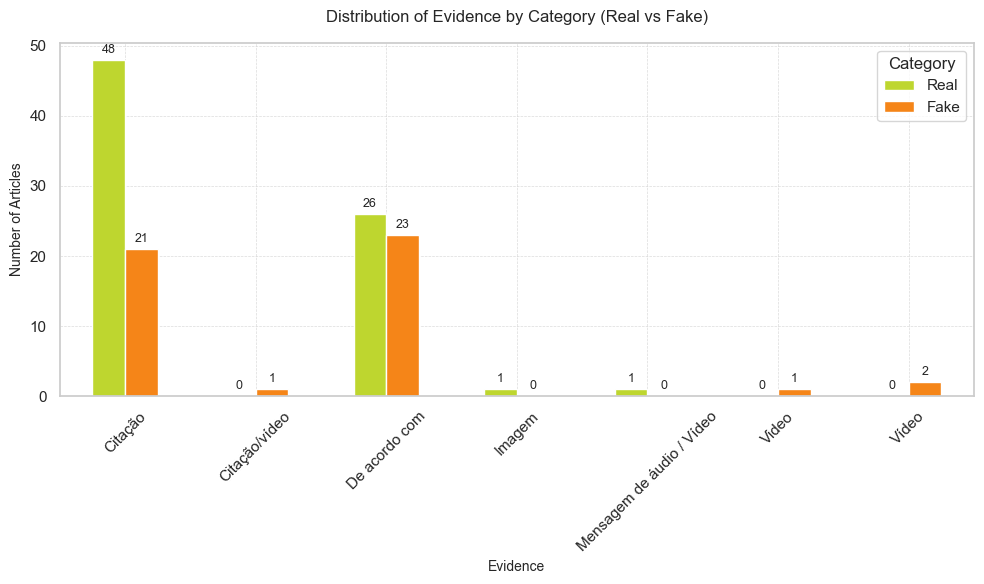

In [158]:
# Strip extra spaces from 'Evidence' column values
human_real_news_final['Evidence'] = human_real_news_final['Evidence'].str.strip()
human_fake_news_final['Evidence'] = human_fake_news_final['Evidence'].str.strip()

# Count values by evidence category
evidence_real = human_real_news_final['Evidence'].value_counts()
evidence_fake = human_fake_news_final['Evidence'].value_counts()

# Combine counts into a DataFrame
evidence_df = pd.DataFrame({
    'Real': evidence_real,
    'Fake': evidence_fake
}).fillna(0).astype(int)

# Plot
ax = evidence_df.plot(kind='bar', figsize=(10, 6), color=['#BED62F', '#f58518'])

plt.title("Distribution of Evidence by Category (Real vs Fake)", fontsize=12, pad=15)
plt.xlabel("Evidence", fontsize=10)
plt.ylabel("Number of Articles", fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(title='Category')
plt.tight_layout()

# Add value labels to bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

plt.show()


# <span style="color: #FF69B4;">4. Large Language Models Dataset</span>

## 4.1 Output AI-Generated Dataset

**ChatGPT:**

In [ ]:
# Load environment variables from the .env file
_ = load_dotenv(find_dotenv())  # Finds and loads the .env file; the underscore means we discard the return value

# Define the API key to authenticate with the OpenAI service
api_key=os.environ.get("OPENAI_API_KEY")

# Create an instance of the client to interact with the OpenAI API
client = OpenAI(api_key=api_key)

In [ ]:
# Function to generate text based on a prompt and generation parameters
# top_p: 1 is the default number
def generate_chatgpt_response(prompt, temperature=0.7, top_p=1.0):
    # Call the API to generate the text
    chat_response = client.chat.completions.create(
        model="gpt-4o",  # Specify the model to be used
        messages=[{"role": "user", "content": prompt}],  # Provide the prompt
        temperature=temperature,  # Controls randomness
        top_p=top_p,  # Top-p sampling
    )
    
    # Extract and return the generated text
    return chat_response.choices[0].message.content

In [ ]:
# General function to process a dataset
def generate_texts_for_dataset(df, dataset_name):
    # Create empty column for ChatGPT response
    df["gpt-4o_text"] = ""

    # Loop over rows
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Generating ChatGPT texts for {dataset_name}"):
        prompt = row.get("Prompt (New)", None)
        
        if pd.notnull(prompt):
            try:
                response = generate_chatgpt_response(prompt)
                df.at[idx, "gpt-4o_text"] = response
                time.sleep(1)  # Respect API limits
            except Exception as e:
                print(f"Error at row {idx}: {e}")
    
    return df

In [ ]:
"""# Apply to each dataset
human_real_news_final = generate_texts_for_dataset(human_real_news_final, "Human Real News")
human_fake_news_final = generate_texts_for_dataset(human_fake_news_final, "Human Fake News")
human_fake_news_control_final = generate_texts_for_dataset(human_fake_news_control_final, "Human Fake News Control")"""

Generating ChatGPT texts for Human Fake News: 100%|██████████| 103/103 [20:36<00:00, 12.00s/it]
Generating ChatGPT texts for Human Fake News Control: 100%|██████████| 20/20 [04:30<00:00, 13.50s/it]


In [ ]:
"""# Save updated datasets
human_real_news_final.to_excel("human_real_news_final_with_gpt4o.xlsx", index=False)
human_fake_news_final.to_excel("human_fake_news_final_with_gpt4o.xlsx", index=False)
human_fake_news_control_final.to_excel("human_fake_news_control_final_with_gpt4o.xlsx", index=False)"""

**Mistral**

In [ ]:
# Real News
file_path_real = "human_real_news_final_with_gpt4o.xlsx"
human_real_news_final2 = pd.read_excel(file_path_real)
# Fake News
file_path_fake = "human_fake_news_final_with_gpt4o.xlsx"
human_fake_news_final2 = pd.read_excel(file_path_fake)
# Fake News Control
file_path_control = "human_fake_news_control_final_with_gpt4o.xlsx"
human_fake_news_control_final2 = pd.read_excel(file_path_control)

In [ ]:
# Load environment variables from the .env file
_ = load_dotenv(find_dotenv())  # Finds and loads the .env file; the underscore means we discard the return value

# Define the API key to authenticate with the Mistral service
api_key = os.environ.get("MISTRAL_API_KEY")

# Create an instance of the client to interact with the Mistral API
client = Mistral(api_key=api_key)

In [ ]:
# Function to generate text based on a prompt and generation parameters
def generate_mistral_response(prompt, model="mistral-large-2411", temperature=0.7, top_p=1.0):
    # Call the API to generate the text
    chat_response = client.chat.complete(
        model=model,  # Correct name for the latest version
        messages=[{"role": "user", "content": prompt}],  # Provide the prompt
        temperature=temperature,  # Controls randomness
        top_p=top_p,  # Top-p sampling
    )
    
    # Extract and return the generated text
    return chat_response.choices[0].message.content 

In [ ]:
# General function to process a dataset
def generate_texts_for_dataset_mistral(df, dataset_name):
    # Create empty column for Mistral response
    df["Mistral_text"] = ""

    # Loop over rows
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Generating Mistral texts for {dataset_name}"):
        prompt = row.get("Prompt (New)", None)
        
        if pd.notnull(prompt):
            try:
                response = generate_mistral_response(prompt)
                df.at[idx, "Mistral_text"] = response
                time.sleep(1)  # API pacing
            except Exception as e:
                print(f"Error at row {idx}: {e}")
    
    return df

In [ ]:
human_real_news_final2 = generate_texts_for_dataset_mistral(human_real_news_final2, "Human Real News (Mistral)")
human_fake_news_final2 = generate_texts_for_dataset_mistral(human_fake_news_final2, "Human Fake News (Mistral)")
human_fake_news_control_final2 = generate_texts_for_dataset_mistral(human_fake_news_control_final2, "Human Fake News Control (Mistral)")

Generating Mistral texts for Human Real News (Mistral): 100%|██████████| 103/103 [19:12<00:00, 11.19s/it]
Generating Mistral texts for Human Fake News (Mistral):  23%|██▎       | 24/103 [04:36<22:18, 16.95s/it]

Error at row 23: Server disconnected without sending a response.


Generating Mistral texts for Human Fake News (Mistral):  83%|████████▎ | 86/103 [17:32<04:16, 15.10s/it]

Error at row 85: Server disconnected without sending a response.


Generating Mistral texts for Human Fake News (Mistral): 100%|██████████| 103/103 [21:00<00:00, 12.24s/it]
Generating Mistral texts for Human Fake News Control (Mistral): 100%|██████████| 20/20 [04:20<00:00, 13.02s/it]


In [ ]:
# Select only the rows where Mistral failed to generate a response
failed_rows = human_fake_news_final2[human_fake_news_final2["Mistral_text"] == ""].copy()

In [ ]:
# Recover the missing responses
for idx, row in failed_rows.iterrows():
    prompt = row.get("Prompt (New)", None)
    
    if pd.notnull(prompt):
        try:
            response = generate_mistral_response(prompt)
            human_fake_news_final2.at[idx, "Mistral_text"] = response
            print(f"✅ Recuperado Mistral para linha {idx}")
            time.sleep(1)
        except Exception as e:
            print(f"❌ Erro ao tentar recuperar linha {idx}: {e}")

✅ Recuperado Mistral para linha 23
✅ Recuperado Mistral para linha 85


In [ ]:
"""# Save updated datasets
human_real_news_final2.to_excel("human_real_news_final_with_gpt_and_mistral.xlsx", index=False)
human_fake_news_final2.to_excel("human_fake_news_final_with_gpt_and_mistral.xlsx", index=False)
human_fake_news_control_final2.to_excel("human_fake_news_control_final_with_gpt_and_mistral.xlsx", index=False)"""

**Llama**

In [ ]:
# Real News
human_real_news_final3 = pd.read_excel("human_real_news_final_with_gpt_and_mistral.xlsx")
# Fake News
human_fake_news_final3 = pd.read_excel("human_fake_news_final_with_gpt_and_mistral.xlsx")
# Fake News Control
human_fake_news_control_final3 = pd.read_excel("human_fake_news_control_final_with_gpt_and_mistral.xlsx")

In [ ]:
# Load environment variables from the .env file
_ = load_dotenv(find_dotenv())  # Finds and loads the .env file; the underscore discards the return value

# Retrieve the API key for authenticating with the Groq service
api_key = os.environ.get("GROQ_API_KEY")

# Create an instance of the client to interact with the Groq API using the provided API key
client = Groq(api_key=api_key)

In [ ]:
# Function to generate text based on a prompt and generation parameters
def generate_llama_response(prompt, model="llama-3.3-70b-versatile", temperature=0.7, top_p=1.0):
    # Call the API to generate the text
    chat_response = client.chat.completions.create(
        model=model,  # corresponde ao LLAMA3_70B_INSTRUCT
        messages=[{"role": "user", "content": prompt}],  # Provide the prompt
        temperature=temperature,  # Controls randomness
        top_p=top_p,  # Top-p sampling
    )
    
    
    # Extract and return the generated text
    return chat_response.choices[0].message.content

In [ ]:
# General function to apply the LLaMA model to a dataset
def generate_texts_for_dataset_llama(df, dataset_name, max_retries=3):
    # Create an empty column to store LLaMA responses
    if "Llama_text" not in df.columns:
        df["Llama_text"] = ""

    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc=f"Generating LLaMA texts for {dataset_name}"):
        prompt = row.get("Prompt (New)", None)

        if pd.notnull(prompt) and (df.at[idx, "Llama_text"] == "" or pd.isna(df.at[idx, "Llama_text"])):
            attempt = 0
            success = False
            
            while attempt < max_retries and not success:
                try:
                    response = generate_llama_response(prompt)
                    df.at[idx, "Llama_text"] = response
                    success = True
                except Exception as e:
                    attempt += 1
                    print(f"⚠️ Error at row {idx}, attempt {attempt}/{max_retries}: {e}")
                    time.sleep(2)  
            
            if not success:
                print(f"❌ Failed after {max_retries} attempts at row {idx}")
            
            time.sleep(5)  

    return df

In [ ]:
"""# Apply the LLaMA model to the three datasets
human_real_news_final3 = generate_texts_for_dataset_llama(human_real_news_final3, "Human Real News (LLaMA)")
human_fake_news_final3 = generate_texts_for_dataset_llama(human_fake_news_final3, "Human Fake News (LLaMA)")
human_fake_news_control_final3 = generate_texts_for_dataset_llama(human_fake_news_control_final3, "Human Fake News Control (LLaMA)")"""

'# Aplicar aos três datasets\nhuman_real_news_final3 = generate_texts_for_dataset_llama(human_real_news_final3, "Human Real News (LLaMA)")\nhuman_fake_news_final3 = generate_texts_for_dataset_llama(human_fake_news_final3, "Human Fake News (LLaMA)")\nhuman_fake_news_control_final3 = generate_texts_for_dataset_llama(human_fake_news_control_final3, "Human Fake News Control (LLaMA)")'

In [ ]:
"""# Save the updated datasets
human_real_news_final3.to_excel("human_real_news_final_with_all_models.xlsx", index=False)
human_fake_news_final3.to_excel("human_fake_news_final_with_all_models.xlsx", index=False)
human_fake_news_control_final3.to_excel("human_fake_news_control_final_with_all_models.xlsx", index=False)
"""

## 4.2 Cleaning of AI-Generated Texts

Specific preprocessing steps were applied to texts generated by LLMs to ensure consistency with human-written content.

**Manual Cleaning:**

- Removal of titles and subtitles automatically generated by LLMs, to match the plain format of human texts.
- Removal of standard disclaimers and endings, such as:
"Fim da notícia." and "Nota: Esta notícia é fictícia e foi criada para fins de exemplo."
These do not appear in human-written texts and could bias the comparison. 
- Removal of location/date headers at the beginning of texts (e.g., "Lisboa, [Data] —", "Lisboa, 15 de outubro de 2023 -", "Lisboa, Portugal -"), to align with the cleaned human dataset.

**Code-Based Cleaning:**

- Removal of formatting markers such as ** (bold) or # (headings), to put text darker or bigger, which are not present in human texts, even if they were present in the original source. This was done to avoid biases and inconsistencies in word count or structure. 

- Removal of duplicated line breaks (\n\n), as human texts in the dataset do not contain these breaks, even if they were present in the original source.

In [159]:
real_data_final = pd.read_excel("human_real_news_final_with_all_models.xlsx")
fake_data_final = pd.read_excel("human_fake_news_final_with_all_models.xlsx")
control_data_final = pd.read_excel("human_fake_news_control_final_with_all_models.xlsx")

In [160]:
real_data_final.head(2)

Topic                                               Text        Source  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...  SIC Noticias   
1      1  Para conter o impacto da inflação, o Governo l...            DN   

                                                 URL   Normalized_source  \
0  https://sicnoticias.pt/economia/2023-03-21-Ass...        SIC Notícias   
1  https://www.dn.pt/dinheiro/asae-vai-liderar-mo...  Diário de Notícias   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   
1  Escreve uma notícia a relatar as medidas lança...  Apoios Governamentais   

  Purpose  Evidence  word_count_text  \
0  Relatar  Citação              356   
1  Relatar  Citação              617   

                                         gpt-4o_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  Em resposta ao crescente desafio da inflação, ...   

                                        Mistral_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  O Governo anunciou um pacote de medidas para c...   

                                          Llama_text  
0  A Associação da Hotelaria de Portugal (AHP) ap...  
1  O Governo anunciou hoje um conjunto de medidas...

In [161]:
fake_data_final.head(2)

Topic                                               Text  \
0      1  No ano passado ele ganhou 2.2 milhões de euros...   
1      1  Assunção Esteves com 10 anos de serviço tem di...   

                     Source  \
0                Tuga Press   
1  apodrecetuga.blogspot.pt   

                                                 URL Normalized_source  \
0  https://arquivo.pt/wayback/20190415223737mp_/h...        tuga press   
1  http://www.magazinelusa.com/assuncao-esteves-c...      apodrecetuga   

                                        Prompt (New)  \
0  Escreve uma notícia sobre como a EDP teve prej...   
1  Escreve uma notícia a comentar como Assunção E...   

                     Topic definition   Purpose  Evidence  word_count_text  \
0  Poder Económico e Dinheiro Público    Relatar      NaN              245   
1  Poder Económico e Dinheiro Público  Comentar       NaN              411   

                                         gpt-4o_text  \
0  Em um cenário inesperado, a EDP, uma das princ...   
1  Em meio a um clima de crescente insatisfação s...   

                                        Mistral_text  \
0  A EDP - Energias de Portugal, um dos maiores g...   
1  A ex-presidente do Tribunal Constitucional, As...   

                                          Llama_text  
0  A EDP, uma das maiores empresas de energia do ...  
1  Em um contexto em que a discussão sobre as ref...

In [162]:
control_data_final.head(2)

Text     Source  \
0  Esta mulher decidiu beber 3 litros de água por...  altamente   
1  Em apenas um mês, Dezembro de 2015, o Serviço ...         cm   

                                                 URL Normalized_source  \
0  https://arquivo.pt/wayback/20160603024458mp_/h...         altamente   
1  https://arquivo.pt/wayback/20160208092526mp_/h...                cm   

          Website Original Date Arquivo.pt Date  \
0  Lusojornal2015    2016-05-01      2016-06-01   
1  Lusojornal2016    2016-01-01      2016-02-01   

                                        Prompt (New)  Purpose        Evidence  \
0  Escreve uma notícia a comentar como uma mulher...  Comentar        Citação   
1  Escreve uma notícia a relatar um esquema de fr...   Relatar  De acordo com   

   word_count_text                                        gpt-4o_text  \
0              575  Em uma impressionante jornada de transformação...   
1              173  Em uma investigação que abalou o setor da saúd...   

                                        Mistral_text  \
0  A história de Ana Maria Silva, 35 anos, está i...   
1  Uma vasta operação de fraude no Serviço Nacion...   

                                          Llama_text  
0  Uma mulher de 35 anos, que preferiu manter o a...  
1  Uma investigação oficial revelou um esquema de...

In [163]:
# Remove irrelevant columns that are not needed for the analysis
real_data_final.drop(columns=["Source", "URL", "Normalized_source", "Purpose ", "Evidence", "word_count_text"], inplace=True)
fake_data_final.drop(columns=["Source", "URL", "Normalized_source", "Purpose ", "Evidence", "word_count_text"], inplace=True)
control_data_final.drop(columns=["Source", "URL", "Normalized_source", "Purpose ", "Evidence", "word_count_text"], inplace=True)

In [164]:
real_data_final.head(2)

Topic                                               Text  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...   
1      1  Para conter o impacto da inflação, o Governo l...   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   
1  Escreve uma notícia a relatar as medidas lança...  Apoios Governamentais   

                                         gpt-4o_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  Em resposta ao crescente desafio da inflação, ...   

                                        Mistral_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  O Governo anunciou um pacote de medidas para c...   

                                          Llama_text  
0  A Associação da Hotelaria de Portugal (AHP) ap...  
1  O Governo anunciou hoje um conjunto de medidas...

In [165]:
def clean_and_normalize_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return text

    # Remove Markdown-style headers (e.g., "# Heading")
    text = re.sub(r'(?m)^#{1,6}', '', text)

    # Remove Markdown formatting symbols
    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)  # **bold**
    text = re.sub(r'\*(.*?)\*', r'\1', text)      # *italic*
    text = re.sub(r'>\s?', '', text)              # > blockquote
    text = re.sub(r'`(.*?)`', r'\1', text)        # `code`

    # Remove duplicated line breaks or blank lines (with or without spaces)
    text = re.sub(r'\n\s*\n+', '\n', text)

    # Strip leading and trailing spaces
    return text.strip()

In [166]:
# Apply the cleaning function to LLM-generated text columns
real_data_final["gpt-4o_text"] = real_data_final["gpt-4o_text"].apply(clean_and_normalize_text)
real_data_final["Mistral_text"] = real_data_final["Mistral_text"].apply(clean_and_normalize_text)
real_data_final["Llama_text"] = real_data_final["Llama_text"].apply(clean_and_normalize_text)

In [167]:
fake_data_final["gpt-4o_text"] = fake_data_final["gpt-4o_text"].apply(clean_and_normalize_text)
fake_data_final["Mistral_text"] = fake_data_final["Mistral_text"].apply(clean_and_normalize_text)
fake_data_final["Llama_text"] = fake_data_final["Llama_text"].apply(clean_and_normalize_text)

In [168]:
control_data_final["gpt-4o_text"] = control_data_final["gpt-4o_text"].apply(clean_and_normalize_text)
control_data_final["Mistral_text"] = control_data_final["Mistral_text"].apply(clean_and_normalize_text)
control_data_final["Llama_text"] = control_data_final["Llama_text"].apply(clean_and_normalize_text)

In [169]:
# Save the cleaned and updated datasets
real_data_final.to_excel("real_data_final.xlsx", index=False)
fake_data_final.to_excel("fake_data_final.xlsx", index=False)
control_data_final.to_excel("control_data_final.xlsx", index=False)

## 4.3 Visualizations

In [170]:
real_data_final_vis = pd.read_excel("real_data_final.xlsx")
fake_data_final_vis = pd.read_excel("fake_data_final.xlsx")
control_data_final_vis = pd.read_excel("control_data_final.xlsx")

In [171]:
# Compute word count for each text source (human and LLMs) in all datasets
real_data_final_vis['word_count_human'] = real_data_final_vis['Text'].fillna("").apply(lambda x: len(str(x).split()))
real_data_final_vis['word_count_gpt4o'] = real_data_final_vis['gpt-4o_text'].fillna("").apply(lambda x: len(str(x).split()))
real_data_final_vis['word_count_mistral'] = real_data_final_vis['Mistral_text'].fillna("").apply(lambda x: len(str(x).split()))
real_data_final_vis['word_count_llama'] = real_data_final_vis['Llama_text'].fillna("").apply(lambda x: len(str(x).split()))

In [172]:
fake_data_final_vis['word_count_human'] = fake_data_final_vis['Text'].fillna("").apply(lambda x: len(str(x).split()))
fake_data_final_vis['word_count_gpt4o'] = fake_data_final_vis['gpt-4o_text'].fillna("").apply(lambda x: len(str(x).split()))
fake_data_final_vis['word_count_mistral'] = fake_data_final_vis['Mistral_text'].fillna("").apply(lambda x: len(str(x).split()))
fake_data_final_vis['word_count_llama'] = fake_data_final_vis['Llama_text'].fillna("").apply(lambda x: len(str(x).split()))

In [173]:
control_data_final_vis['word_count_human'] = control_data_final_vis['Text'].fillna("").apply(lambda x: len(str(x).split()))
control_data_final_vis['word_count_gpt4o'] = control_data_final_vis['gpt-4o_text'].fillna("").apply(lambda x: len(str(x).split()))
control_data_final_vis['word_count_mistral'] = control_data_final_vis['Mistral_text'].fillna("").apply(lambda x: len(str(x).split()))
control_data_final_vis['word_count_llama'] = control_data_final_vis['Llama_text'].fillna("").apply(lambda x: len(str(x).split()))

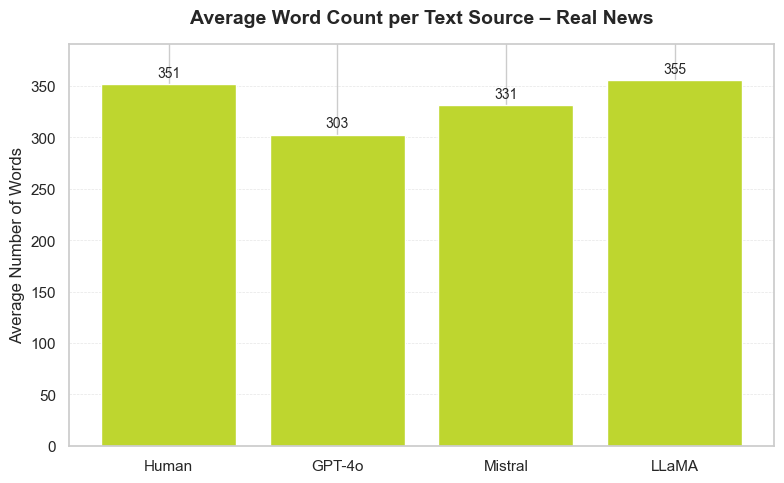

In [174]:
# Plot average word count per text source for Real News

# Consistent style
sns.set(style="whitegrid")

# Compute averages
word_count_columns = [
    'word_count_human',
    'word_count_gpt4o',
    'word_count_mistral',
    'word_count_llama'
]

label_map = {
    'word_count_human': 'Human',
    'word_count_gpt4o': 'GPT-4o',
    'word_count_mistral': 'Mistral',
    'word_count_llama': 'LLaMA'
}

average_word_counts = real_data_final_vis[word_count_columns].mean()
average_word_counts.index = [label_map[col] for col in average_word_counts.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    average_word_counts.index,
    average_word_counts.values,
    color="#BED62F"
)

# Title and labels
ax.set_title(
    "Average Word Count per Text Source – Real News",
    fontsize=14,
    weight="bold",
    pad=15
)
ax.set_ylabel("Average Number of Words", fontsize=12)
ax.set_xticks(range(len(average_word_counts.index)))
ax.set_xticklabels(average_word_counts.index, rotation=0)

# Grid
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.0f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

ax.set_ylim(0, average_word_counts.max() * 1.1)

plt.tight_layout()

# Save high-quality PDF and SVG
base_filename = "average_word_count_real_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

# Show and close figure
plt.show()
plt.close(fig)


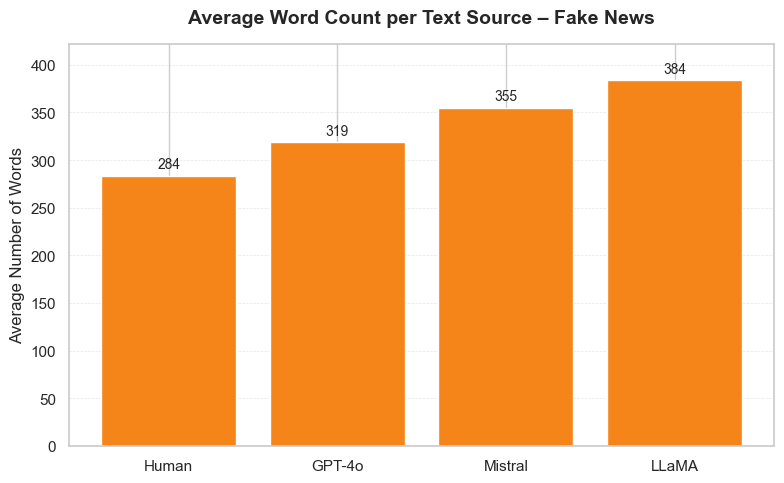

In [175]:
# Plot average word count per text source for Fake News

# Consistent style
sns.set(style="whitegrid")

# Compute averages
word_count_columns = [
    'word_count_human',
    'word_count_gpt4o',
    'word_count_mistral',
    'word_count_llama'
]

label_map = {
    'word_count_human': 'Human',
    'word_count_gpt4o': 'GPT-4o',
    'word_count_mistral': 'Mistral',
    'word_count_llama': 'LLaMA'
}

average_word_counts = fake_data_final_vis[word_count_columns].mean()
average_word_counts.index = [label_map[col] for col in average_word_counts.index]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(
    average_word_counts.index,
    average_word_counts.values,
    color="#f58518"
)

# Title and labels
ax.set_title(
    "Average Word Count per Text Source – Fake News",
    fontsize=14,
    weight="bold",
    pad=15
)
ax.set_ylabel("Average Number of Words", fontsize=12)
ax.set_xticks(range(len(average_word_counts.index)))
ax.set_xticklabels(average_word_counts.index, rotation=0)

# Grid
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.0f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=10
    )

ax.set_ylim(0, average_word_counts.max() * 1.1)

plt.tight_layout()

# Save high-quality PDF and SVG
base_filename = "average_word_count_fake_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

# Show and close figure
plt.show()
plt.close(fig)


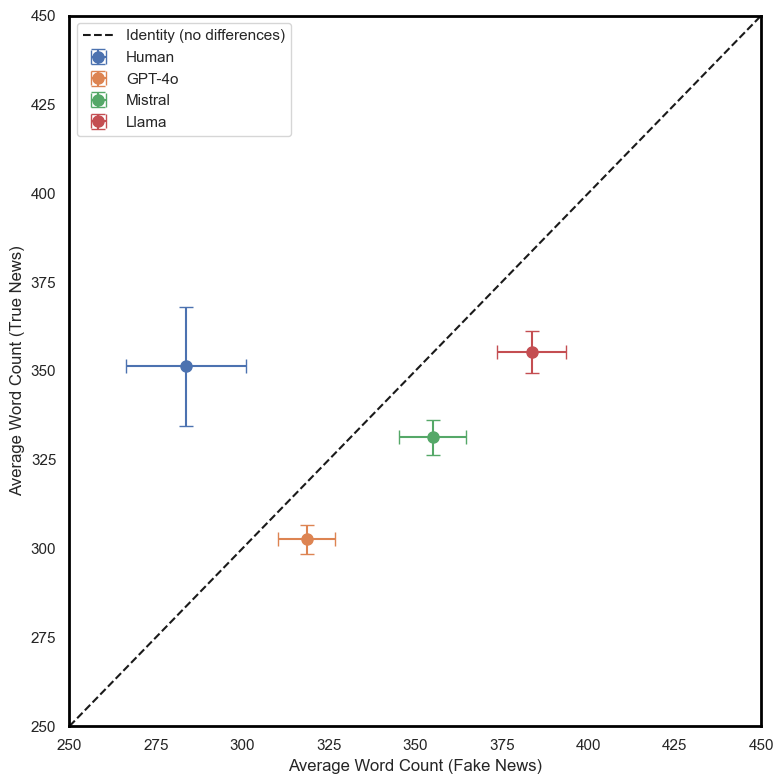

In [176]:
word_count_columns = [
    'word_count_human',
    'word_count_gpt4o',
    'word_count_mistral',
    'word_count_llama'
]

label_map = {
    'word_count_human': 'Human',
    'word_count_gpt4o': 'GPT-4o',
    'word_count_mistral': 'Mistral',
    'word_count_llama': 'Llama'
}

mean_true = real_data_final_vis[word_count_columns].mean()
mean_fake = fake_data_final_vis[word_count_columns].mean()

se_true = real_data_final_vis[word_count_columns].sem()
se_fake = fake_data_final_vis[word_count_columns].sem()

label_map_inv = {v: k for k, v in label_map.items()}

fig, ax = plt.subplots(figsize=(8, 8))

for label in label_map.values():
    col = label_map_inv[label]
    x = mean_fake[col]
    y = mean_true[col]
    xerr = se_fake[col]
    yerr = se_true[col]

    ax.errorbar(
        x, y,
        xerr=xerr,
        yerr=yerr,
        fmt='o',
        capsize=5,
        label=label,
        markersize=8
    )

# Identity line
ax.plot([250, 450], [250, 450], 'k--', label="Identity (no differences)")

ax.set_xlabel("Average Word Count (Fake News)", fontsize=12)
ax.set_ylabel("Average Word Count (True News)", fontsize=12)
ax.set_title("", fontsize=14, weight="bold")

# Set axis limits
ax.set_xlim(250, 450)
ax.set_ylim(250, 450)

# Remove grid
ax.grid(False)

# Thicker black border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(2)

ax.legend()

plt.tight_layout()

base_filename = "comparison_word_count"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()


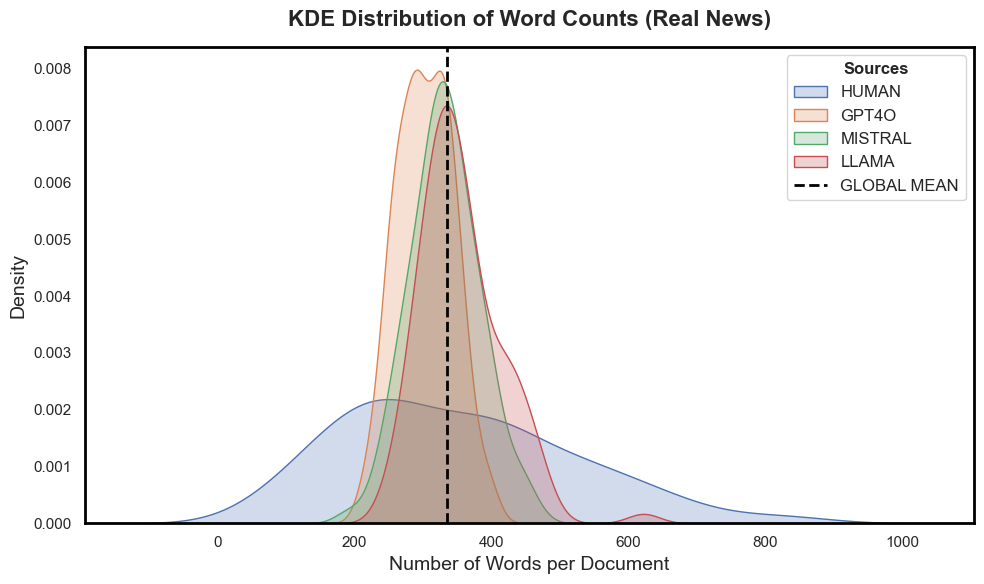

In [189]:
# Plot KDE distribution of word counts per source for Real News
fig, ax = plt.subplots(figsize=(10, 6))

for col in word_count_columns:
    sns.kdeplot(
        real_data_final_vis[col],
        label=col.replace('word_count_', '').upper(),
        fill=True,
        ax=ax
    )

# ---- ONE MEAN LINE ONLY ----
global_mean = real_data_final_vis[word_count_columns].values.flatten().mean()
ax.axvline(global_mean, color="black", linestyle="--", linewidth=2, label="GLOBAL MEAN")

# Titles & labels
ax.set_title("KDE Distribution of Word Counts (Real News)", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Number of Words per Document", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

# Legend
ax.legend(
    title="Sources",
    title_fontproperties=FontProperties(weight="bold", size=12),
    fontsize=12
)

# Styling
ax.grid(False)
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(2)

plt.tight_layout()
plt.show()

# Save PDF and SVG
base_filename = "kde_word_count_real_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()
plt.close(fig)

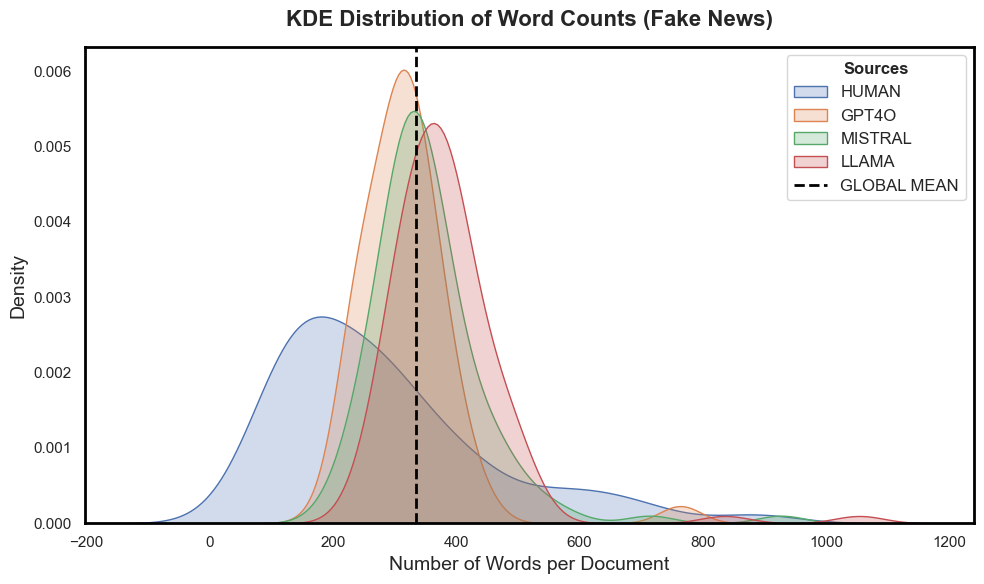

In [188]:
# Plot KDE distribution of word counts per source for Fake News
fig, ax = plt.subplots(figsize=(10, 6))

for col in word_count_columns:
    sns.kdeplot(
        fake_data_final_vis[col],
        label=col.replace('word_count_', '').upper(),
        fill=True,
        ax=ax
    )

# ---- ONE MEAN LINE ONLY (GLOBAL MEAN) ----
global_mean = fake_data_final_vis[word_count_columns].values.flatten().mean()
ax.axvline(global_mean, color="black", linestyle="--", linewidth=2, label="GLOBAL MEAN")

# Titles & labels
ax.set_title("KDE Distribution of Word Counts (Fake News)", fontsize=16, weight="bold", pad=15)
ax.set_xlabel("Number of Words per Document", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

# Legend
ax.legend(
    title="Sources",
    title_fontproperties=FontProperties(weight="bold", size=12),
    fontsize=12
)

# Remove grid
ax.grid(False)

# Thicker black border
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(2)

plt.tight_layout()

# Save PDF and SVG
base_filename = "kde_word_count_fake_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()
plt.close(fig)


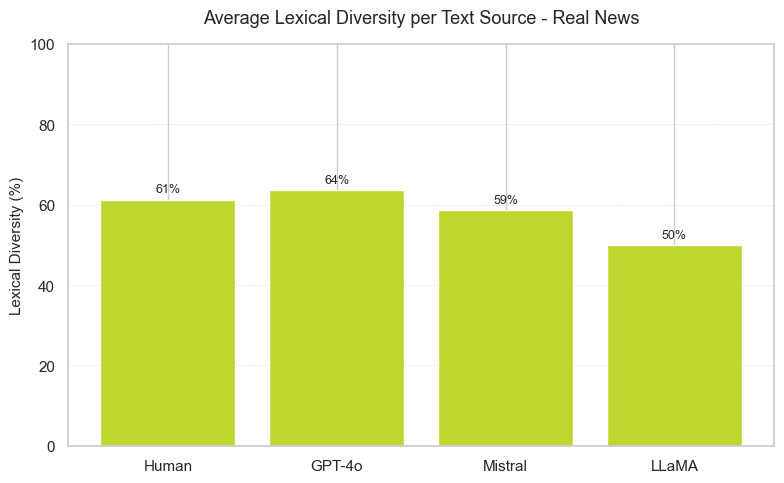

In [181]:
# Compute lexical diversity (unique words / total words) for each source in Real News
real_data_final_vis['lex_div_human'] = real_data_final_vis['Text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
real_data_final_vis['lex_div_gpt4o'] = real_data_final_vis['gpt-4o_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
real_data_final_vis['lex_div_mistral'] = real_data_final_vis['Mistral_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
real_data_final_vis['lex_div_llama'] = real_data_final_vis['Llama_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)

# Plot average lexical diversity
label_map = {
    'lex_div_human': 'Human',
    'lex_div_gpt4o': 'GPT-4o',
    'lex_div_mistral': 'Mistral',
    'lex_div_llama': 'LLaMA'
}

lexical_columns = list(label_map.keys())
lexical_means = real_data_final_vis[lexical_columns].mean() * 100
lexical_means.index = [label_map[col] for col in lexical_means.index]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(lexical_means.index, lexical_means.values, color='#BED62F')

ax.set_title('Average Lexical Diversity per Text Source - Real News', fontsize=13, pad=15)
ax.set_ylabel('Lexical Diversity (%)', fontsize=11)
ax.set_xticks(range(len(lexical_means.index)))
ax.set_xticklabels(lexical_means.index, rotation=0)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',  # mostra como 61%
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save PDF and SVG
base_filename = "lexical_diversity_real_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()
plt.close(fig)

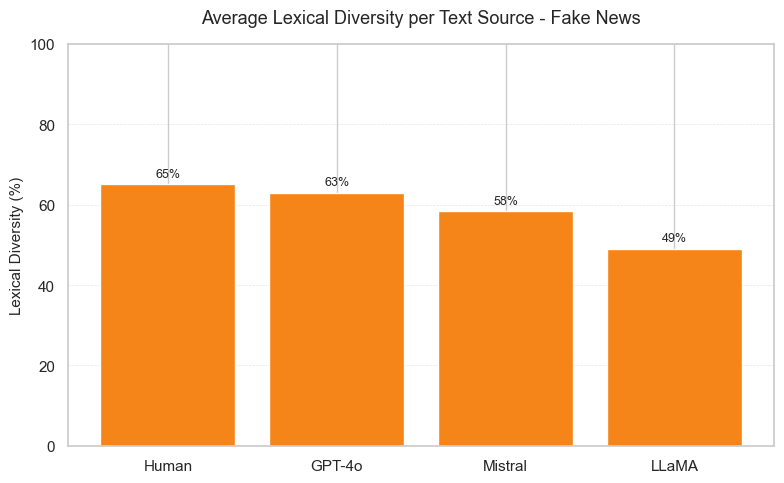

In [182]:
# Compute lexical diversity (unique words / total words) for each source in Fake News
# Compute lexical diversity (unique words / total words) for each source in Fake News
fake_data_final_vis['lex_div_human'] = fake_data_final_vis['Text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
fake_data_final_vis['lex_div_gpt4o'] = fake_data_final_vis['gpt-4o_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
fake_data_final_vis['lex_div_mistral'] = fake_data_final_vis['Mistral_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)
fake_data_final_vis['lex_div_llama'] = fake_data_final_vis['Llama_text'].apply(
    lambda x: len(set(str(x).split())) / max(1, len(str(x).split()))
)

label_map = {
    'lex_div_human': 'Human',
    'lex_div_gpt4o': 'GPT-4o',
    'lex_div_mistral': 'Mistral',
    'lex_div_llama': 'LLaMA'
}

lexical_columns = list(label_map.keys())
lexical_means = fake_data_final_vis[lexical_columns].mean() * 100
lexical_means.index = [label_map[col] for col in lexical_means.index]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(lexical_means.index, lexical_means.values, color='#f58518')

ax.set_title('Average Lexical Diversity per Text Source - Fake News', fontsize=13, pad=15)
ax.set_ylabel('Lexical Diversity (%)', fontsize=11)
ax.set_xticks(range(len(lexical_means.index)))
ax.set_xticklabels(lexical_means.index, rotation=0)
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.0f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save PDF and SVG
base_filename = "lexical_diversity_fake_news"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()
plt.close(fig)

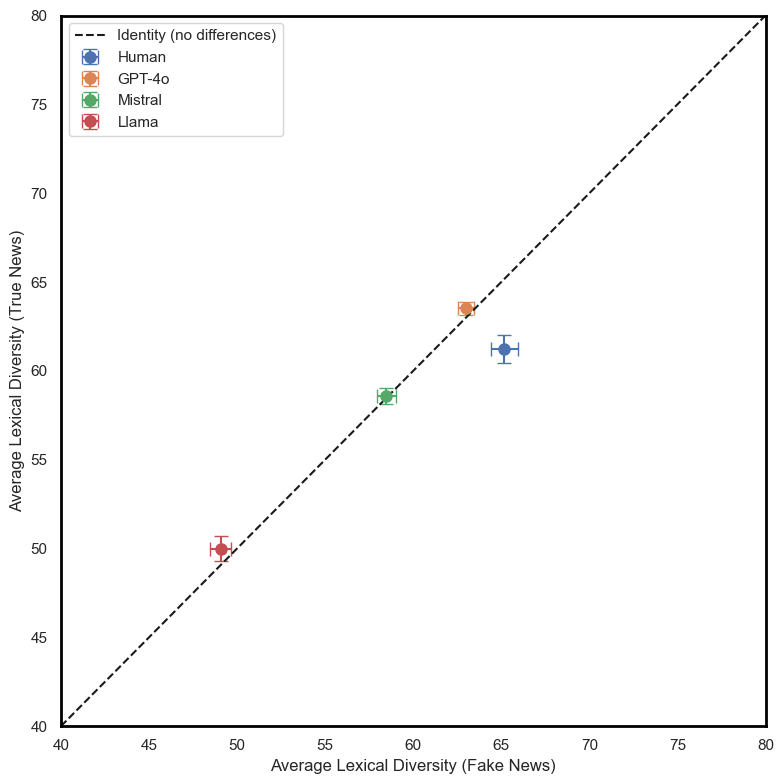

In [183]:
lexical_columns = [
    'lex_div_human',
    'lex_div_gpt4o',
    'lex_div_mistral',
    'lex_div_llama'
]

label_map = {
    'lex_div_human': 'Human',
    'lex_div_gpt4o': 'GPT-4o',
    'lex_div_mistral': 'Mistral',
    'lex_div_llama': 'Llama'
}

label_map_inv = {v: k for k, v in label_map.items()}

mean_true = real_data_final_vis[lexical_columns].mean() * 100
mean_fake = fake_data_final_vis[lexical_columns].mean() * 100

se_true = real_data_final_vis[lexical_columns].sem() * 100
se_fake = fake_data_final_vis[lexical_columns].sem() * 100

fig, ax = plt.subplots(figsize=(8, 8))

for label in label_map.values():
    col = label_map_inv[label]
    x = mean_fake[col]
    y = mean_true[col]
    xerr = se_fake[col]
    yerr = se_true[col]

    ax.errorbar(
        x, y,
        xerr=xerr,
        yerr=yerr,
        fmt='o',
        capsize=5,
        markersize=8,
        label=label
    )

# Identity line
ax.plot([40, 80], [40, 80], 'k--', label="Identity (no differences)")

ax.set_xlabel("Average Lexical Diversity (Fake News)", fontsize=12)
ax.set_ylabel("Average Lexical Diversity (True News)", fontsize=12)
ax.set_title("", fontsize=14, weight="bold")

# Set axis limits
ax.set_xlim(40, 80)
ax.set_ylim(40, 80)

# Remove grid
ax.grid(False)

# Thicker black border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(2)

ax.legend()

plt.tight_layout()

base_filename = "comparison_lexical_diversity"
fig.savefig(base_filename + ".pdf", format="pdf", dpi=1200, bbox_inches="tight")
fig.savefig(base_filename + ".svg", format="svg", dpi=1200, bbox_inches="tight")

plt.show()


In [184]:
# Drop lexical diversity columns from all datasets (used only for visualization)
cols_to_drop = ['lex_div_human', 'lex_div_gpt4o', 'lex_div_mistral', 'lex_div_llama']

for df in [real_data_final_vis, fake_data_final_vis]:
    df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# <span style="color: #FF69B4;">5. Linguistic Characteristics Analysis</span>

In [190]:
real_data_final_liwc = real_data_final_vis.copy()
fake_data_final_liwc = fake_data_final_vis.copy() 
control_data_final_liwc = control_data_final_vis.copy()

## 5.1 LIWC - Linguistic Inquiry and Word Count

In [191]:
real_data_final_liwc.head(2)

Topic                                               Text  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...   
1      1  Para conter o impacto da inflação, o Governo l...   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   
1  Escreve uma notícia a relatar as medidas lança...  Apoios Governamentais   

                                         gpt-4o_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  Em resposta ao crescente desafio da inflação, ...   

                                        Mistral_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  O Governo anunciou um pacote de medidas para c...   

                                          Llama_text  word_count_human  \
0  A Associação da Hotelaria de Portugal (AHP) ap...               356   
1  O Governo anunciou hoje um conjunto de medidas...               617   

   word_count_gpt4o  word_count_mistral  word_count_llama  
0               319                 333               308  
1               347                 325               352

In [192]:
fake_data_final_liwc.head(2)

Topic                                               Text  \
0      1  No ano passado ele ganhou 2.2 milhões de euros...   
1      1  Assunção Esteves com 10 anos de serviço tem di...   

                                        Prompt (New)  \
0  Escreve uma notícia sobre como a EDP teve prej...   
1  Escreve uma notícia a comentar como Assunção E...   

                     Topic definition  \
0  Poder Económico e Dinheiro Público   
1  Poder Económico e Dinheiro Público   

                                         gpt-4o_text  \
0  Em um cenário inesperado, a EDP, uma das princ...   
1  Em meio a um clima de crescente insatisfação s...   

                                        Mistral_text  \
0  A EDP - Energias de Portugal, um dos maiores g...   
1  A ex-presidente do Tribunal Constitucional, As...   

                                          Llama_text  word_count_human  \
0  A EDP, uma das maiores empresas de energia do ...               245   
1  Em um contexto em que a discussão sobre as ref...               411   

   word_count_gpt4o  word_count_mistral  word_count_llama  
0               327                 374               487  
1               334                 297               409

In [193]:
control_data_final_liwc.head(2)

Text         Website  \
0  Esta mulher decidiu beber 3 litros de água por...  Lusojornal2015   
1  Em apenas um mês, Dezembro de 2015, o Serviço ...  Lusojornal2016   

  Original Date Arquivo.pt Date  \
0    2016-05-01      2016-06-01   
1    2016-01-01      2016-02-01   

                                        Prompt (New)  \
0  Escreve uma notícia a comentar como uma mulher...   
1  Escreve uma notícia a relatar um esquema de fr...   

                                         gpt-4o_text  \
0  Em uma impressionante jornada de transformação...   
1  Em uma investigação que abalou o setor da saúd...   

                                        Mistral_text  \
0  A história de Ana Maria Silva, 35 anos, está i...   
1  Uma vasta operação de fraude no Serviço Nacion...   

                                          Llama_text  word_count_human  \
0  Uma mulher de 35 anos, que preferiu manter o a...               575   
1  Uma investigação oficial revelou um esquema de...               173   

   word_count_gpt4o  word_count_mistral  word_count_llama  
0               350                 359               362  
1               365                 413               409

In [194]:
real_data_final_liwc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Topic               103 non-null    int64 
 1   Text                103 non-null    object
 2   Prompt (New)        103 non-null    object
 3   Topic definition    103 non-null    object
 4   gpt-4o_text         103 non-null    object
 5   Mistral_text        103 non-null    object
 6   Llama_text          103 non-null    object
 7   word_count_human    103 non-null    int64 
 8   word_count_gpt4o    103 non-null    int64 
 9   word_count_mistral  103 non-null    int64 
 10  word_count_llama    103 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 9.0+ KB


In [195]:
fake_data_final_liwc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Topic               103 non-null    int64 
 1   Text                103 non-null    object
 2   Prompt (New)        103 non-null    object
 3   Topic definition    103 non-null    object
 4   gpt-4o_text         103 non-null    object
 5   Mistral_text        103 non-null    object
 6   Llama_text          103 non-null    object
 7   word_count_human    103 non-null    int64 
 8   word_count_gpt4o    103 non-null    int64 
 9   word_count_mistral  103 non-null    int64 
 10  word_count_llama    103 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 9.0+ KB


In [196]:
control_data_final_liwc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Text                20 non-null     object        
 1   Website             20 non-null     object        
 2   Original Date       14 non-null     datetime64[ns]
 3   Arquivo.pt Date     19 non-null     datetime64[ns]
 4   Prompt (New)        20 non-null     object        
 5   gpt-4o_text         20 non-null     object        
 6   Mistral_text        20 non-null     object        
 7   Llama_text          20 non-null     object        
 8   word_count_human    20 non-null     int64         
 9   word_count_gpt4o    20 non-null     int64         
 10  word_count_mistral  20 non-null     int64         
 11  word_count_llama    20 non-null     int64         
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 2.0+ KB


In [197]:
# Ensure that all relevant text columns are explicitly converted to string type
cols_to_string = ['Text', 'Prompt (New)', 'gpt-4o_text', 'Mistral_text', 'Llama_text']

for df in [real_data_final_liwc, fake_data_final_liwc, control_data_final_liwc]:
    for col in cols_to_string:
        if col in df.columns:
            df[col] = df[col].astype("string")

In [198]:
real_data_final_liwc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Topic               103 non-null    int64 
 1   Text                103 non-null    string
 2   Prompt (New)        103 non-null    string
 3   Topic definition    103 non-null    object
 4   gpt-4o_text         103 non-null    string
 5   Mistral_text        103 non-null    string
 6   Llama_text          103 non-null    string
 7   word_count_human    103 non-null    int64 
 8   word_count_gpt4o    103 non-null    int64 
 9   word_count_mistral  103 non-null    int64 
 10  word_count_llama    103 non-null    int64 
dtypes: int64(5), object(1), string(5)
memory usage: 9.0+ KB


### 5.1.1 Adapting the LIWC 2015 Dictionary from Brazilian to European Portuguese

Target Categories: 'Informal', 'Netspeak',
    'Affect', 'Posemo', 'Negemo', 'Anx', 'Anger', 'Sad',
    'Cogproc', 'Insight', 'Cause', 'Discrep', 'Tentat', 'Certain', 'Differ',
    'Percept', 'See', 'Hear', 'Feel',
    'Drives', 'Affiliation', 'Achieve', 'Power', 'Reward', 'Risk'


In [ ]:
# Function to count the number of word entries in a LIWC dictionary file
def count_words_in_liwc_dic(filepath):
    # Open the file using Latin-1 encoding (used in some LIWC dictionaries)
    with open(filepath, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # Find the index of the line that separates the category section from the word entries
    sep_idx = lines.index('%\n', 1)
    
    # Get all lines after the separator, which correspond to the word entries
    word_lines = lines[sep_idx + 1:]

    # Return the total number of word entries
    return len(word_lines)

# Path to the LIWC dictionary file
dic_path = 

# Count the word entries in the dictionary
total_words = count_words_in_liwc_dic(dic_path)

# Print the result
print(f"Total word entries in dictionary: {total_words}")

Total word entries in dictionary: 14459


In [ ]:
# Function to count how many words are assigned to each LIWC category
def count_words_per_category(filepath):
    # Open the LIWC dictionary file using Latin-1 encoding
    with open(filepath, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # Separate the lines containing categories and word entries
    sep_idx = lines.index('%\n', 1)  # The '%' line separates categories from words
    category_lines = lines[1:sep_idx]  # Category definitions are between the first line and the '%'
    word_lines = lines[sep_idx + 1:]  # Word entries come after '%'

    # Create a dictionary mapping category IDs to their category names
    id_to_category = {}
    for line in category_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            cat_id = parts[0]
            cat_name = parts[1]
            id_to_category[cat_id] = cat_name

    # Initialize a counter for how many words belong to each category
    category_counts = defaultdict(int)

    # Go through each word entry
    for line in word_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            word = parts[0]  # First part is the word (can include wildcards like '*')
            cat_ids = parts[1:]  # The rest are category IDs
            for cat_id in cat_ids:
                cat_name = id_to_category.get(cat_id)
                if cat_name:
                    category_counts[cat_name] += 1  # Increment count for each associated category

    return category_counts

# Path to your LIWC dictionary file
dic_path =

# Run the function to get the count of words per category
counts = count_words_per_category(dic_path)

# Print the results sorted alphabetically by category name
for category in sorted(counts.keys()):
    print(f"{category}: {counts[category]}")

achieve: 896
adj: 1241
adverb: 526
affect: 2105
affiliation: 601
anger: 315
anx: 209
article: 29
assent: 40
auxverb: 610
bio: 1924
body: 271
cause: 547
certain: 425
cogproc: 2691
compare: 300
conj: 40
death: 90
differ: 213
discrep: 313
drives: 3176
family: 93
feel: 283
female: 152
filler: 17
focusfuture: 1456
focuspast: 3159
focuspresent: 1416
friend: 61
function: 1426
health: 1296
hear: 300
home: 145
i: 9
informal: 419
ingest: 336
insight: 1095
interrog: 23
ipron: 157
leisure: 556
male: 125
money: 356
motion: 1989
negate: 36
negemo: 1213
netspeak: 212
nonflu: 38
number: 106
percept: 1001
posemo: 863
power: 1146
ppron: 79
prep: 73
pronoun: 234
quant: 160
relativ: 3220
relig: 343
reward: 394
risk: 511
sad: 239
see: 451
sexual: 146
shehe: 17
social: 1445
space: 867
swear: 174
tentat: 483
they: 15
time: 695
verb: 6162
we: 11
work: 781
you: 36


In [ ]:
# List of target categories 
categories_to_check = [
    "Analytic", "Clout", "Authentic", "Tone",
    "Informal", "Netspeak",
    "Affect", "Posemo", "Negemo", "Anx", "Anger", "Sad",
    "Cogproc", "Insight", "Cause", "Discrep", "Tentat", "Certain", "Differ",
    "Percept", "See", "Hear", "Feel",
    "Drives", "Affiliation", "Achieve", "Power", "Reward", "Risk"
]

# Adapted function to count only selected LIWC categories
def count_selected_categories(filepath, target_categories):
    # Open the LIWC dictionary file using Latin-1 encoding
    with open(filepath, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # Identify the line that separates category definitions from word entries
    sep_idx = lines.index('%\n', 1)
    category_lines = lines[1:sep_idx]    # Category definitions are between the header and '%'
    word_lines = lines[sep_idx + 1:]     # Word entries come after '%'

    # Create a mapping from category ID to category name
    id_to_category = {}
    for line in category_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            cat_id = parts[0]
            cat_name = parts[1]
            id_to_category[cat_id] = cat_name

    # Create a lowercase set of the target categories for easy matching
    target_lower = set(cat.lower() for cat in target_categories)

    # Initialize counter for selected categories
    category_counts = defaultdict(int)

    # Iterate through each word entry
    for line in word_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            word = parts[0]             # First item is the word (can include wildcards like '*')
            cat_ids = parts[1:]         # Remaining items are category IDs
            for cat_id in cat_ids:
                cat_name = id_to_category.get(cat_id)
                # Only count the word if it belongs to one of the target categories
                if cat_name and cat_name.lower() in target_lower:
                    category_counts[cat_name] += 1

    return category_counts

# Path to the LIWC dictionary file
dic_path = 
selected_counts = count_selected_categories(dic_path, categories_to_check)

# Display the results sorted by category name
print("Word count per selected category:")
for category in sorted(selected_counts.keys()):
    print(f"{category}: {selected_counts[category]}")

Word count per selected category:
achieve: 896
affect: 2105
affiliation: 601
anger: 315
anx: 209
cause: 547
certain: 425
cogproc: 2691
differ: 213
discrep: 313
drives: 3176
feel: 283
hear: 300
informal: 419
insight: 1095
negemo: 1213
netspeak: 212
percept: 1001
posemo: 863
power: 1146
reward: 394
risk: 511
sad: 239
see: 451
tentat: 483


In [ ]:
def create_filtered_dic(filepath_in, filepath_out, target_categories):
    with open(filepath_in, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    sep_idx = lines.index('%\n', 1)
    category_lines = lines[1:sep_idx]
    word_lines = lines[sep_idx + 1:]

    # Map category name (lower) → ID and ID → line
    catname_to_id = {}
    id_to_catline = {}

    for line in category_lines:
        parts = line.strip().split()
        if len(parts) >= 2:
            cat_id = parts[0]
            cat_name = parts[1].lower()
            catname_to_id[cat_name] = cat_id
            id_to_catline[cat_id] = line

    # Get the target category IDs
    target_ids = {catname_to_id[cat.lower()] for cat in target_categories if cat.lower() in catname_to_id}

    # Filter category lines
    filtered_cat_lines = [id_to_catline[cat_id] for cat_id in sorted(target_ids, key=int)]

    # Filter word lines with only the allowed categories
    filtered_word_lines = []
    for line in word_lines:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        word = parts[0]
        ids = parts[1:]
        valid_ids = [cat_id for cat_id in ids if cat_id in target_ids]
        if valid_ids:
            filtered_word_lines.append(word + "\t" + "\t".join(valid_ids) + "\n")

    # Save new .dic
    with open(filepath_out, 'w', encoding='latin-1') as f_out:
        f_out.write('%\n')
        for line in filtered_cat_lines:
            f_out.write(line)
        f_out.write('%\n')
        for line in filtered_word_lines:
            f_out.write(line)

    print(f"✔ Filtered dictionary saved to: {filepath_out}")
    print(f"✔ Categories kept: {len(filtered_cat_lines)}")
    print(f"✔ Word entries kept: {len(filtered_word_lines)}")

In [ ]:
# Filter the original dictionary to keep only the selected 25 categories

# Input path for full dictionary
dic_path_full = 
# Output path for the filtered dictionary
dic_path_in =

# Categories you want to keep
target_categories = [
    "Analytic", "Clout", "Authentic", "Tone",
    "Informal", "Netspeak",
    "Affect", "Posemo", "Negemo", "Anx", "Anger", "Sad",
    "Cogproc", "Insight", "Cause", "Discrep", "Tentat", "Certain", "Differ",
    "Percept", "See", "Hear", "Feel",
    "Drives", "Affiliation", "Achieve", "Power", "Reward", "Risk"
]
"""
# Call the function to create the filtered dictionary
create_filtered_dic(dic_path_full, dic_path_in, target_categories)"""

'\n# Call the function to create the filtered dictionary\ncreate_filtered_dic(dic_path_full, dic_path_in, target_categories)'

In [ ]:
"""# Path to the LIWC dictionary file
dic_path = 

# Count the word entries in the dictionary
total_words = count_words_in_liwc_dic(dic_path)

# Print the result
print(f"Total word entries in dictionary: {total_words}")"""

Total word entries in dictionary: 7735


In [ ]:
# Function to clean a LIWC dictionary file by applying substitutions or removals
def clean_dic_file(input_path: str, output_path: str, substitutions_dict: dict[str, Optional[str]]) -> str:
    # Open and read all lines from the input dictionary
    with open(input_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()

    # Find the separator line ('%\n') that divides categories from word entries
    sep_idx = lines.index('%\n', 1)
    category_lines = lines[1:sep_idx]     # Category definitions
    word_lines = lines[sep_idx + 1:]      # Word-to-category mappings

    # Lists and counters for processing results
    cleaned_word_lines = []
    substitutions_count = 0
    removals_count = 0
    unchanged_count = 0

    # Process each word line
    for line in word_lines:
        parts = line.strip().split()
        if not parts:
            continue  # Skip empty lines
        word = parts[0]                  # The word (or wildcard pattern)
        word_lc = word.lower()           # Lowercase version for matching
        categories = parts[1:]           # Category IDs associated with the word

        matched = False  # Flag to check if a substitution/removal was applied

        # Try to match the word against each substitution rule
        for original, replacement in substitutions_dict.items():
            original_base = original.rstrip("*").lower()  # Base word (remove '*' if present)
            is_wildcard = original.endswith("*")           # Check if it's a wildcard

            # Match logic: either full match or startswith if wildcard
            if (is_wildcard and word_lc.startswith(original_base)) or (not is_wildcard and word_lc == original_base):
                matched = True
                if replacement is None:
                    # Word should be removed entirely
                    removals_count += 1
                    break  # Skip this word
                else:
                    # Replace word and keep its categories
                    cleaned_word_lines.append(replacement + "\t" + "\t".join(categories) + "\n")
                    substitutions_count += 1
                    break
        else:
            # No match found — keep word as is
            cleaned_word_lines.append(line)
            unchanged_count += 1

    # Write the cleaned dictionary to the output file
    with open(output_path, 'w', encoding='latin-1') as f_out:
        f_out.write('%\n')  # Category section header
        for line in category_lines:
            f_out.write(line)
        f_out.write('%\n')  # Word section header
        for line in cleaned_word_lines:
            f_out.write(line)

    # Print cleaning summary
    print(f"✔ Cleaned dictionary saved to: {output_path}")
    print(f"📊 Statistics:")
    print(f"   ↪ Substitutions: {substitutions_count}")
    print(f"   ↪ Removals: {removals_count}")
    print(f"   ↪ Unchanged: {unchanged_count}")
    print(f"   ↪ Final total entries: {len(cleaned_word_lines)}")

    return output_path 

In [ ]:
# Substitutions/removals: PT-BR → PT-PT 
# Use * as a suffix wildcard 
ptbr_substitutions = {
    "abestado": "parvo",
    "açougue": "talho",
    "azucrin*": "chatea*", 
    "babaca": "idiota",
    "baba-ovo": "lambe-botas",
    "babaovo": "lambe-botas",
    "bacana*": "porreiro*",
    "bagunc*": "confus*",
    "bagunç*": "confus*",
    "balada*": "discoteca*",
    "besta": "idiota",
    "bicha": "gay",
    "birita*": "bebida*",
    "blz": "fixe",
    "briga": "confusão",
    "brigado": "obrigado",
    "brigadu": "obrigado",
    "brinks": "brincadeira",
    "brinxs": "brincadeira",
    "brinquedoteca": "sala de brinquedos",
    "brioco": "cu",
    "briocos": "cus",
    "brocha": "impotente",
    "broder*": "amig*",
    "bróder*": "amig*",
    "bródio": "borga",
    "brou": "mano",
    "broxa": "impotente",
    "buceta": "cona",
    "bugad*": "avariad*",
    "bugo*": "avari*",
    "buguei": "avaria",
    "bunda": "rabo",
    "bundas": "rabos",
    "bunduda": "rabuda",
    "brega": "azeiteiro",
    "bully": "agressor",
    "camisinha": "durex",
    "caminhão": "camião",
    "canudo": "palhinha",
    "cara": "rapaz",
    "caraca": "caraças",
    "caramba": "bolas",
    "cara-de-pau": "descarado",
    "celular*": "telemóve*",
    "chefão": "chefe",
    "chinfrim": "foleiro",
    "chinfrim": "foleiro",
    "conversível": "descapotável",
    "creme de leite": "natas",
    "ctz": "certeza",
    "cueca": "boxer",
    "curtir": "gosta*",
    "cuzão": "cabrão",
    "desorotante": "desodorizante",
    "esmalte": "verniz",
    "esporte": "desporto",
    "faixa de pedestre": "passadeira",
    "garot*": "gaj*",
    "geladeira*": "frigorífico*",
    "gente": "pessoal",
    "gracinha": "piada",
    "grana": "dinheiro",
    "história em quadrinhos": "banda desenhada",
    "lanchonete*": "cafetaria*",
    "legal": "fixe",
    "lega*": "fixe*",
    "limão": "lima",
    "limão siciliano": "limão",
    "machucar": "magoar",
    "maneiro*": "giro*",
    "marrom": "castanho",
    "massa*": "fixe",
    "mauricinho": "betinho",
    "merenda*": "lanche*",
    "mixteira": "tostadeira",
    "moça": "rapariga",
    "mó": "muito",
    "moleque": "miúdo",
    "moleton": "fato de treino",
    "n00b": "noob",
    "né": "não é",
    "nóia": "paranoia",
    "office boy": "estafeta",
    "oi": "olá",
    "ônibus*": "autocarro*",
    "parada": "paragem",
    "pebolim": "matraquilhos",
    "pilantra": "velhaco",
    "pilantragem": "falcatrua",
    "poxa": "porra",
    "pra": "para",
    "presunto": "fiambre",
    "resenha*": "conversa*",
    "rotatória": "rotunda",
    "sacar dinheiro": "levantar dinheiro",
    "sacola*": "saco*",
    "show*": "espetáculo*",
    "sorvete": "gelado",
    "suco": "sumo",
    "tá": "está",
    "tava*": "estava*",
    "tchau": "adeus",
    "tela": "ecrã",
    "terno": "fato",
    "top": "brutal",
    "tô": "estou",
    "trem": "comboio",
    "valeu": "obrigado",
    "van": "carrinha",
    "vc*": "tu",
    "vlw": "obrigado",
    "você*": "tu",
    "vsf": "vai-te lixar",
    "vtc": "vai-te lixar",
    "vtnc": "vai-te foder",
    "xingamento": "insulto",
    "Xerox": "fotocópia",
    "xexeca": "cona",
    "xerereca": "cona",
    "xibiu": "cona",
    "xibumba": "cona",
    "xochota": "cona",
    "xota": "cona",
    "xoxota": "cona",
    "zap": "wpp",
    "zelador*": "porteir*",
    "zé-ruela": "morcão",
    "zoad*": "goz*",
    "zueira*": "brincadeira*",
    "zueir*": "brincadeir*",
    "zuar*": "gozar*",
    "zuêr*": "goz*",
    "zuer*": "goz*"
}

"""
# Paths
dic_path_in = 
dic_path_out = 

# Run
clean_dic_file(dic_path_in, dic_path_out, ptbr_substitutions)"""

✔ Cleaned dictionary saved to: C:\Users\flavi\OneDrive\Documentos\Nova IMS\Tese\Código Tese\Contrasting Human and LLM-Generated Misinformation\LIWC2015_ptpt_cleaned.dic
📊 Statistics:
   ↪ Substitutions: 66
   ↪ Removals: 0
   ↪ Unchanged: 7669
   ↪ Final total entries: 7735


'C:\\Users\\flavi\\OneDrive\\Documentos\\Nova IMS\\Tese\\Código Tese\\Contrasting Human and LLM-Generated Misinformation\\LIWC2015_ptpt_cleaned.dic'

- Substitutions: 66
- Removals: 0
- Unchanged: 7669
- Final total entries: 7735

### 5.1.2 Preprocessing Text for LIWC Analysis

In [199]:
# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Ensure the input is a string
    text = str(text)

    # Convert text to lowercase
    text = text.lower()

    # Normalize whitespace (remove extra spaces and strip leading/trailing spaces)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize by splitting on whitespace
    tokens = text.split()

    return tokens

In [200]:
text_columns = ['Text', 'gpt-4o_text', 'Mistral_text', 'Llama_text']

for df in [real_data_final_liwc, fake_data_final_liwc, control_data_final_liwc]:
    for col in text_columns:
        if col in df.columns:
            df[f"{col}_tokens"] = df[col].apply(clean_and_tokenize)

In [201]:
real_data_final_liwc.head()

Topic                                               Text  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...   
1      1  Para conter o impacto da inflação, o Governo l...   
2      1  O Governo vai criar um travão à subida das ren...   
3      1  O Governo e as estruturas sindicais da função ...   
4      1  A ministra da Habitação, Marina Gonçalves, rev...   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   
1  Escreve uma notícia a relatar as medidas lança...  Apoios Governamentais   
2  Escreve uma notícia a relatar que o Governo va...  Apoios Governamentais   
3  Escreve uma notícia sobre o acordo plurianual ...  Apoios Governamentais   
4  Escreve uma notícia a relatar o anúncio da min...  Apoios Governamentais   

                                         gpt-4o_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  Em resposta ao crescente desafio da inflação, ...   
2  Em uma medida destinada a mitigar o impacto da...   
3  O Governo português e os sindicatos da função ...   
4  Numa conferência de imprensa realizada hoje em...   

                                        Mistral_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   
1  O Governo anunciou um pacote de medidas para c...   
2  O Governo anunciou hoje uma medida de grande i...   
3  O Governo e os sindicatos da função pública, F...   
4  A ministra da Habitação, Marina Gonçalves, anu...   

                                          Llama_text  word_count_human  \
0  A Associação da Hotelaria de Portugal (AHP) ap...               356   
1  O Governo anunciou hoje um conjunto de medidas...               617   
2  O Governo português anunciou hoje que vai impl...               162   
3  O Governo português e os sindicatos da função ...               271   
4  A Ministra da Habitação, Marina Gonçalves, anu...               637   

   word_count_gpt4o  word_count_mistral  word_count_llama  \
0               319                 333               308   
1               347                 325               352   
2               293                 367               349   
3               291                 392               370   
4               332                 391               331   

                                         Text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   
1  [para, conter, o, impacto, da, inflação,, o, g...   
2  [o, governo, vai, criar, um, travão, à, subida...   
3  [o, governo, e, as, estruturas, sindicais, da,...   
4  [a, ministra, da, habitação,, marina, gonçalve...   

                                  gpt-4o_text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   
1  [em, resposta, ao, crescente, desafio, da, inf...   
2  [em, uma, medida, destinada, a, mitigar, o, im...   
3  [o, governo, português, e, os, sindicatos, da,...   
4  [numa, conferência, de, imprensa, realizada, h...   

                                 Mistral_text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   
1  [o, governo, anunciou, um, pacote, de, medidas...   
2  [o, governo, anunciou, hoje, uma, medida, de, ...   
3  [o, governo, e, os, sindicatos, da, função, pú...   
4  [a, ministra, da, habitação,, marina, gonçalve...   

                                   Llama_text_tokens  
0  [a, associação, da, hotelaria, de, portugal, (...  
1  [o, governo, anunciou, hoje, um, conjunto, de,...  
2  [o, governo, português, anunciou, hoje, que, v...  
3  [o, governo, português, e, os, sindicatos, da,...  
4  [a, ministra, da, habitação,, marina, gonçalve...

### 5.1.3 Applying the LIWC Dictionary to the Dataset

In [ ]:
# Load LIWC parser
dic_path = 
parse, category_names = liwc.load_token_parser(dic_path)

# Function to count LIWC categories
def count_liwc_categories(tokens):
    return Counter(category for token in tokens for category in parse(token))

# Apply LIWC category counting to each dataset and text column
datasets = [real_data_final_liwc, fake_data_final_liwc, control_data_final_liwc]

for df in datasets:
    for col in text_columns:
        token_col = f"{col}_tokens"
        liwc_col = f"{col}_liwc"
        df[liwc_col] = df[token_col].apply(count_liwc_categories)

In [203]:
real_data_final_liwc.head(1)

Topic                                               Text  \
0      1  A Associação da Hotelaria de Portugal (AHP) de...   

                                        Prompt (New)       Topic definition  \
0  Escreve uma notícia a relatar a proposta da As...  Apoios Governamentais   

                                         gpt-4o_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   

                                        Mistral_text  \
0  A Associação da Hotelaria de Portugal (AHP) ap...   

                                          Llama_text  word_count_human  \
0  A Associação da Hotelaria de Portugal (AHP) ap...               356   

   word_count_gpt4o  word_count_mistral  word_count_llama  \
0               319                 333               308   

                                         Text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   

                                  gpt-4o_text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   

                                 Mistral_text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   

                                   Llama_text_tokens  \
0  [a, associação, da, hotelaria, de, portugal, (...   

                                           Text_liwc  \
0  {'drives (Drives)': 23, 'risk (Risk)': 8, 'ach...   

                                    gpt-4o_text_liwc  \
0  {'drives (Drives)': 41, 'power (Power)': 14, '...   

                                   Mistral_text_liwc  \
0  {'drives (Drives)': 52, 'power (Power)': 16, '...   

                                     Llama_text_liwc  
0  {'drives (Drives)': 50, 'power (Power)': 16, '...

In [204]:
fake_data_final_liwc.head(1)

Topic                                               Text  \
0      1  No ano passado ele ganhou 2.2 milhões de euros...   

                                        Prompt (New)  \
0  Escreve uma notícia sobre como a EDP teve prej...   

                     Topic definition  \
0  Poder Económico e Dinheiro Público   

                                         gpt-4o_text  \
0  Em um cenário inesperado, a EDP, uma das princ...   

                                        Mistral_text  \
0  A EDP - Energias de Portugal, um dos maiores g...   

                                          Llama_text  word_count_human  \
0  A EDP, uma das maiores empresas de energia do ...               245   

   word_count_gpt4o  word_count_mistral  word_count_llama  \
0               327                 374               487   

                                         Text_tokens  \
0  [no, ano, passado, ele, ganhou, 2.2, milhões, ...   

                                  gpt-4o_text_tokens  \
0  [em, um, cenário, inesperado,, a, edp,, uma, d...   

                                 Mistral_text_tokens  \
0  [a, edp, -, energias, de, portugal,, um, dos, ...   

                                   Llama_text_tokens  \
0  [a, edp,, uma, das, maiores, empresas, de, ene...   

                                           Text_liwc  \
0  {'affect (Affect)': 10, 'posemo (Positive Emot...   

                                    gpt-4o_text_liwc  \
0  {'affect (Affect)': 11, 'posemo (Positive Emot...   

                                   Mistral_text_liwc  \
0  {'affect (Affect)': 4, 'posemo (Positive Emoti...   

                                     Llama_text_liwc  
0  {'drives (Drives)': 52, 'power (Power)': 17, '...

In [205]:
control_data_final_liwc.head(1)

Text         Website  \
0  Esta mulher decidiu beber 3 litros de água por...  Lusojornal2015   

  Original Date Arquivo.pt Date  \
0    2016-05-01      2016-06-01   

                                        Prompt (New)  \
0  Escreve uma notícia a comentar como uma mulher...   

                                         gpt-4o_text  \
0  Em uma impressionante jornada de transformação...   

                                        Mistral_text  \
0  A história de Ana Maria Silva, 35 anos, está i...   

                                          Llama_text  word_count_human  \
0  Uma mulher de 35 anos, que preferiu manter o a...               575   

   word_count_gpt4o  word_count_mistral  word_count_llama  \
0               350                 359               362   

                                         Text_tokens  \
0  [esta, mulher, decidiu, beber, 3, litros, de, ...   

                                  gpt-4o_text_tokens  \
0  [em, uma, impressionante, jornada, de, transfo...   

                                 Mistral_text_tokens  \
0  [a, história, de, ana, maria, silva,, 35, anos...   

                                   Llama_text_tokens  \
0  [uma, mulher, de, 35, anos,, que, preferiu, ma...   

                                           Text_liwc  \
0  {'cogproc (Cognitive Processes)': 68, 'insight...   

                                    gpt-4o_text_liwc  \
0  {'affect (Affect)': 21, 'posemo (Positive Emot...   

                                   Mistral_text_liwc  \
0  {'affect (Affect)': 14, 'negemo (Negative Emot...   

                                     Llama_text_liwc  
0  {'affect (Affect)': 18, 'posemo (Positive Emot...

In [206]:
print(sorted(category_names))

['achieve (Achievement)', 'affect (Affect)', 'affiliation (Affiliation)', 'anger (Anger)', 'anx (Anx)', 'cause (Causal)', 'certain (Certainty)', 'cogproc (Cognitive Processes)', 'differ (Differentiation)', 'discrep (Discrepancies)', 'drives (Drives)', 'feel (Feel)', 'hear (Hear)', 'informal (Informal Language)', 'insight (Insight)', 'negemo (Negative Emotions)', 'netspeak (Netspeak)', 'percept (Perceptual Processes)', 'posemo (Positive Emotions)', 'power (Power)', 'reward (Reward)', 'risk (Risk)', 'sad (Sad)', 'see (See)', 'tentat (Tentative)']


In [207]:
print(len(category_names))

25


In [208]:
# Define text columns and datasets
text_columns = ["Text", "gpt-4o_text", "Mistral_text", "Llama_text"]
datasets = {
    "real": real_data_final_liwc,
    "fake": fake_data_final_liwc,
    "control": control_data_final_liwc
}

# Dictionary to store LIWC percentage results per dataset
liwc_percent_per_text = {}

# Loop through each dataset
for name, df in datasets.items():
    percent_tables = {}

    # For each text column (e.g., original text or model-generated text)
    for col in text_columns:
        token_col = f"{col}_tokens"  # Column with tokenized text
        liwc_col = f"{col}_liwc"     # Column with LIWC category counts (as Counter)

        per_text_percent = []

        # Loop through each text's LIWC counts and token list
        for liwc_counts, tokens in zip(df[liwc_col], df[token_col]):
            token_count = len(tokens)
            if token_count > 0:
                # Convert raw category counts into percentages
                percent = {cat: (count / token_count) * 100 for cat, count in liwc_counts.items()}
            else:
                # If no tokens, return an empty dictionary
                percent = {}
            per_text_percent.append(percent)

        # Convert list of percentage dictionaries into a DataFrame:
        # Each row = one text, columns = LIWC categories
        df_percent = pd.DataFrame(per_text_percent).fillna(0)
        percent_tables[col] = df_percent

    # Store result for the dataset (real/fake/control)
    liwc_percent_per_text[name] = percent_tables

In [209]:
liwc_percent_per_text["real"]["Text"].head()

drives (Drives)  risk (Risk)  achieve (Achievement)  power (Power)  \
0         6.460674     2.247191               0.842697       3.089888   
1         6.645057     1.944895               1.620746       2.269044   
2         6.172840     1.234568               0.617284       3.703704   
3         8.487085     2.583026               1.107011       4.428044   
4         6.907378     1.412873               0.313972       3.453689   

   cogproc (Cognitive Processes)  cause (Causal)  reward (Reward)  \
0                      10.674157        3.651685         2.528090   
1                       5.672609        2.593193         1.782820   
2                       3.703704        1.234568         0.617284   
3                       5.904059        3.321033         2.583026   
4                       6.907378        2.197802         1.883830   

   affect (Affect)  posemo (Positive Emotions)  insight (Insight)  ...  \
0         1.404494                    1.123596           1.404494  ...   
1         1.620746                    1.296596           0.324149  ...   
2         0.617284                    0.617284           0.000000  ...   
3         1.476015                    1.476015           0.000000  ...   
4         1.098901                    0.470958           1.412873  ...   

   anger (Anger)  certain (Certainty)  percept (Perceptual Processes)  \
0       0.280899             0.280899                        0.561798   
1       0.000000             1.620746                        0.648298   
2       0.000000             0.000000                        1.234568   
3       0.000000             0.738007                        0.738007   
4       0.156986             1.569859                        0.784929   

   feel (Feel)  see (See)  hear (Hear)  anx (Anx)  sad (Sad)  \
0     0.561798   0.000000     0.000000   0.000000   0.000000   
1     0.162075   0.162075     0.324149   0.000000   0.000000   
2     0.617284   0.000000     0.617284   0.000000   0.000000   
3     0.738007   0.000000     0.000000   0.000000   0.000000   
4     0.313972   0.000000     0.470958   0.313972   0.156986   

   informal (Informal Language)  netspeak (Netspeak)  
0                           0.0                  0.0  
1                           0.0                  0.0  
2                           0.0                  0.0  
3                           0.0                  0.0  
4                           0.0                  0.0  

[5 rows x 25 columns]

In [210]:
liwc_percent_per_text["real"]["gpt-4o_text"].head()

drives (Drives)  power (Power)  cogproc (Cognitive Processes)  \
0        12.852665       4.388715                       9.404389   
1         9.798271       2.017291                       8.357349   
2         8.532423       2.389078                       8.532423   
3        11.340206       3.780069                       8.247423   
4        10.542169       4.216867                      10.240964   

   cause (Causal)  reward (Reward)  risk (Risk)  achieve (Achievement)  \
0        4.702194         4.075235     4.075235               3.448276   
1        3.746398         4.034582     2.881844               2.593660   
2        3.071672         2.730375     3.754266               2.047782   
3        2.749141         2.061856     2.061856               3.780069   
4        3.915663         3.012048     3.313253               0.903614   

   discrep (Discrepancies)  affect (Affect)  posemo (Positive Emotions)  ...  \
0                 2.194357         3.448276                    2.507837  ...   
1                 1.152738         3.170029                    2.017291  ...   
2                 1.023891         3.412969                    1.706485  ...   
3                 1.030928         4.467354                    4.467354  ...   
4                 1.506024         3.012048                    2.710843  ...   

   tentat (Tentative)  percept (Perceptual Processes)  feel (Feel)  see (See)  \
0            0.626959                        0.626959     0.313480   0.313480   
1            0.576369                        0.864553     0.000000   0.864553   
2            1.023891                        0.682594     0.682594   0.000000   
3            0.687285                        0.000000     0.000000   0.000000   
4            1.506024                        1.506024     1.204819   0.301205   

   sad (Sad)  anger (Anger)  anx (Anx)  informal (Informal Language)  \
0   0.000000       0.000000   0.000000                           0.0   
1   0.576369       0.000000   0.000000                           0.0   
2   0.341297       0.341297   0.000000                           0.0   
3   0.000000       0.000000   0.000000                           0.0   
4   0.000000       0.000000   0.301205                           0.0   

   hear (Hear)  netspeak (Netspeak)  
0          0.0                  0.0  
1          0.0                  0.0  
2          0.0                  0.0  
3          0.0                  0.0  
4          0.0                  0.0  

[5 rows x 25 columns]

In [211]:
liwc_percent_per_text["fake"]["Text"].head()

affect (Affect)  posemo (Positive Emotions)  drives (Drives)  \
0         4.081633                    2.857143         8.571429   
1         3.406326                    2.676399         8.515815   
2         0.000000                    0.000000         9.615385   
3         2.415459                    1.449275         4.347826   
4         1.369863                    0.684932         5.479452   

   achieve (Achievement)  reward (Reward)  negemo (Negative Emotions)  \
0               3.265306         2.040816                    1.224490   
1               1.946472         3.649635                    0.729927   
2               0.961538         3.846154                    0.000000   
3               0.000000         2.415459                    0.966184   
4               0.684932         4.109589                    0.684932   

   cogproc (Cognitive Processes)  differ (Differentiation)  \
0                       6.122449                  2.040816   
1                       9.245742                  1.459854   
2                       7.692308                  1.923077   
3                       6.038647                  1.449275   
4                       2.054795                  0.684932   

   discrep (Discrepancies)  sad (Sad)  ...  certain (Certainty)  \
0                 1.632653   0.408163  ...             0.000000   
1                 2.676399   0.000000  ...             1.216545   
2                 0.000000   0.000000  ...             0.961538   
3                 1.449275   0.000000  ...             0.483092   
4                 0.684932   0.000000  ...             0.000000   

   affiliation (Affiliation)  anger (Anger)  percept (Perceptual Processes)  \
0                   0.000000       0.000000                        0.000000   
1                   0.729927       0.243309                        0.729927   
2                   2.884615       0.000000                        0.000000   
3                   0.966184       0.000000                        0.483092   
4                   0.000000       0.684932                        0.000000   

   feel (Feel)  see (See)  anx (Anx)  hear (Hear)  \
0     0.000000   0.000000   0.000000          0.0   
1     0.486618   0.243309   0.000000          0.0   
2     0.000000   0.000000   0.000000          0.0   
3     0.483092   0.000000   0.241546          0.0   
4     0.000000   0.000000   0.000000          0.0   

   informal (Informal Language)  netspeak (Netspeak)  
0                           0.0                  0.0  
1                           0.0                  0.0  
2                           0.0                  0.0  
3                           0.0                  0.0  
4                           0.0                  0.0  

[5 rows x 25 columns]

In [212]:
liwc_percent_per_text["fake"]["gpt-4o_text"].head()

affect (Affect)  posemo (Positive Emotions)  cogproc (Cognitive Processes)  \
0         3.363914                    2.752294                       8.868502   
1         2.694611                    1.796407                       8.383234   
2         3.463203                    3.030303                       6.926407   
3         1.242236                    0.931677                       8.074534   
4         3.673469                    2.448980                       4.489796   

   cause (Causal)  drives (Drives)  power (Power)  achieve (Achievement)  \
0        3.975535         7.033639       3.363914               2.140673   
1        4.191617         7.784431       3.293413               0.598802   
2        2.597403         8.658009       1.731602               0.865801   
3        1.552795         4.658385       1.552795               0.931677   
4        2.857143         9.387755       1.632653               2.040816   

   tentat (Tentative)  discrep (Discrepancies)  reward (Reward)  ...  \
0            0.611621                 1.529052         1.834862  ...   
1            1.497006                 0.598802         2.095808  ...   
2            1.298701                 0.865801         4.329004  ...   
3            2.484472                 2.795031         1.552795  ...   
4            0.816327                 0.408163         4.081633  ...   

   anx (Anx)  sad (Sad)  percept (Perceptual Processes)  see (See)  \
0   0.305810   0.305810                        0.917431   0.917431   
1   0.299401   0.299401                        1.197605   0.598802   
2   0.432900   0.000000                        1.298701   1.298701   
3   0.000000   0.000000                        0.621118   0.310559   
4   0.408163   0.408163                        0.408163   0.408163   

   certain (Certainty)  feel (Feel)  hear (Hear)  anger (Anger)  \
0             1.223242     0.000000     0.000000            0.0   
1             0.598802     0.598802     0.000000            0.0   
2             0.865801     0.000000     0.000000            0.0   
3             1.552795     0.000000     0.310559            0.0   
4             0.000000     0.000000     0.000000            0.0   

   informal (Informal Language)  netspeak (Netspeak)  
0                           0.0                  0.0  
1                           0.0                  0.0  
2                           0.0                  0.0  
3                           0.0                  0.0  
4                           0.0                  0.0  

[5 rows x 25 columns]

In [213]:
liwc_percent_per_text["control"]["Text"].head()

cogproc (Cognitive Processes)  insight (Insight)  affect (Affect)  \
0                      11.826087           1.913043         3.304348   
1                       1.156069           0.000000         1.156069   
2                       9.276730           1.729560         1.729560   
3                       6.287425           0.598802         3.592814   
4                       9.975062           1.496259         2.493766   

   posemo (Positive Emotions)  discrep (Discrepancies)  tentat (Tentative)  \
0                    1.913043                 3.478261            2.434783   
1                    0.000000                 0.578035            0.000000   
2                    0.157233                 0.943396            2.672956   
3                    0.000000                 1.796407            1.497006   
4                    1.246883                 2.743142            3.241895   

   differ (Differentiation)  cause (Causal)  certain (Certainty)  \
0                  2.434783        2.260870             1.913043   
1                  0.578035        0.000000             0.000000   
2                  2.044025        2.830189             0.157233   
3                  1.197605        1.197605             0.598802   
4                  2.244389        1.496259             1.246883   

   drives (Drives)  ...  negemo (Negative Emotions)  \
0         6.956522  ...                    1.391304   
1         1.734104  ...                    1.156069   
2         5.188679  ...                    1.572327   
3         8.083832  ...                    3.592814   
4         6.733167  ...                    1.246883   

   percept (Perceptual Processes)  feel (Feel)  informal (Informal Language)  \
0                        3.130435     1.043478                      0.173913   
1                        1.734104     1.156069                      0.000000   
2                        0.314465     0.157233                      0.157233   
3                        2.095808     0.898204                      0.299401   
4                        3.241895     0.249377                      0.000000   

   see (See)  anx (Anx)  hear (Hear)  sad (Sad)  anger (Anger)  \
0   1.913043   0.347826     0.173913   0.173913       0.000000   
1   0.578035   0.000000     0.000000   0.000000       0.578035   
2   0.157233   0.157233     0.000000   0.000000       0.314465   
3   0.598802   0.598802     0.598802   0.898204       1.497006   
4   0.748130   0.000000     2.244389   0.498753       0.249377   

   netspeak (Netspeak)  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.299401  
4             0.000000  

[5 rows x 25 columns]

In [214]:
liwc_percent_per_text["control"]["Llama_text"].head()

affect (Affect)  posemo (Positive Emotions)  drives (Drives)  \
0         4.972376                    2.486188         8.839779   
1         1.955990                    0.977995         7.823961   
2         2.493766                    0.249377         7.481297   
3         6.784661                    1.769912         7.374631   
4         3.051643                    1.408451         7.511737   

   affiliation (Affiliation)  cogproc (Cognitive Processes)  \
0                   0.828729                      11.878453   
1                   0.000000                       7.579462   
2                   1.496259                      11.471322   
3                   0.884956                       7.079646   
4                   0.469484                      11.737089   

   insight (Insight)  reward (Reward)  certain (Certainty)  power (Power)  \
0           3.038674         4.696133             2.209945       1.381215   
1           0.977995         3.667482             0.733496       1.955990   
2           1.246883         2.743142             0.000000       1.995012   
3           0.000000         2.359882             0.294985       3.244838   
4           1.408451         4.225352             0.938967       2.112676   

   differ (Differentiation)  ...  negemo (Negative Emotions)  feel (Feel)  \
0                  0.828729  ...                    2.486188     1.933702   
1                  0.733496  ...                    0.977995     0.488998   
2                  1.995012  ...                    2.244389     0.249377   
3                  1.474926  ...                    5.014749     0.589971   
4                  1.408451  ...                    1.643192     0.704225   

   sad (Sad)  achieve (Achievement)  risk (Risk)  cause (Causal)  see (See)  \
0   0.552486               1.933702     1.933702        2.209945   0.000000   
1   0.244499               1.955990     3.911980        4.156479   0.244499   
2   1.246883               0.249377     2.743142        3.740648   0.000000   
3   1.769912               0.000000     2.654867        2.949853   0.589971   
4   0.704225               0.704225     2.582160        3.755869   0.234742   

   anger (Anger)  anx (Anx)  informal (Informal Language)  
0       0.000000   0.000000                           0.0  
1       0.000000   0.000000                           0.0  
2       0.000000   0.000000                           0.0  
3       1.179941   0.294985                           0.0  
4       0.000000   0.234742                           0.0  

[5 rows x 24 columns]

The relative difference (D%) shows how much a value has increased or decreased in relation to a reference value (human baseline):

- If D > 0: The LLM used that category more than humans.
- If D < 0: Humans used it more than the LLM.
- If D = 0: Usage was identical between human and AI-generated text.

In [215]:
# Define dictionary to store relative difference results
liwc_relative_diff_per_text = {}

# Loop through each dataset (real, fake, control)
for dataset_name, data_by_text_type in liwc_percent_per_text.items():
    df_diffs = {}  # Will store results for each AI model

    # Get the DataFrame with human-authored text LIWC percentages
    df_human = data_by_text_type["Text"]

    # Loop through each AI-generated text column
    for ai_model in ["gpt-4o_text", "Mistral_text", "Llama_text"]:
        # Get the LIWC percentage DataFrame for the current model
        df_ai = data_by_text_type[ai_model]

        # Ensure the indices match (important if rows were filtered)
        df_ai = df_ai.loc[df_human.index]

        # Replace 0s with NaN to avoid division by zero
        denominator = df_human.replace(0, np.nan)

        # Compute relative difference per category per text
        # Formula: ((AI - Human) / Human) * 100
        diff_per_text = ((df_ai - df_human) / denominator) * 100

        # Store the result
        df_diffs[ai_model] = diff_per_text

        # Optional: warn if there were any divisions by zero
        if denominator.isna().sum().sum() > 0:
            print(f"Warning: zeros avoided in dataset '{dataset_name}' for model '{ai_model}'.")

    # Store the relative difference results for this dataset
    liwc_relative_diff_per_text[dataset_name] = df_diffs


Replace 0s with NaN to avoid division by zero.
LIWC percentages for some categories may be exactly 0 (i.e., the category did not appear in the human text).
In those cases, computing the relative difference would result in division by zero.
Using NaN ensures we skip these comparisons without introducing misleading infinite or extreme values.


In [216]:
liwc_relative_diff_per_text["real"]["gpt-4o_text"].head()

achieve (Achievement)  affect (Affect)  affiliation (Affiliation)  \
0             309.195402       145.517241                 457.993730   
1              60.028818        95.590778                 113.371758   
2             231.740614       452.901024                  10.580205   
3             241.466208       202.663230                 109.536082   
4             187.801205       174.096386                  91.867470   

   anger (Anger)  anx (Anx)  cause (Causal)  certain (Certainty)  \
0         -100.0        NaN       28.767784           346.394984   
1            NaN        NaN       44.470461            24.466859   
2            NaN        NaN      148.805461                  NaN   
3            NaN        NaN      -17.220313           365.635739   
4         -100.0  -4.066265       78.162651            34.307229   

   cogproc (Cognitive Processes)  differ (Differentiation)  \
0                     -11.895727                -65.661924   
1                      47.328119                 77.809798   
2                     130.375427                -72.354949   
3                      39.690722                -30.154639   
4                      48.261227                130.240964   

   discrep (Discrepancies)  ...  negemo (Negative Emotions)  \
0               -34.900731  ...                  234.796238   
1                      NaN  ...                  611.239193   
2                      NaN  ...                         NaN   
3               179.381443  ...                         NaN   
4               -20.055221  ...                  -52.033133   

   netspeak (Netspeak)  percept (Perceptual Processes)  \
0                  NaN                       11.598746   
1                  NaN                       33.357349   
2                  NaN                      -44.709898   
3                  NaN                     -100.000000   
4                  NaN                       91.867470   

   posemo (Positive Emotions)  power (Power)  reward (Reward)  risk (Risk)  \
0                  123.197492      42.034768        61.198189    81.347962   
1                   55.583573     -11.095101       126.303380    48.174832   
2                  176.450512     -35.494881       342.320819   204.095563   
3                  202.663230     -14.633448       -20.176730   -20.176730   
4                  475.602410      22.097481        59.889558   134.504685   

   sad (Sad)   see (See)  tentat (Tentative)  
0        NaN         NaN          -44.200627  
1        NaN  433.429395          -11.095101  
2        NaN         NaN                 NaN  
3        NaN         NaN           -6.872852  
4     -100.0         NaN          859.337349  

[5 rows x 25 columns]

In [217]:
liwc_relative_diff_per_text['fake']['gpt-4o_text'].head()

achieve (Achievement)  affect (Affect)  affiliation (Affiliation)  \
0             -34.441896       -17.584098                        NaN   
1             -69.236527       -20.893926                 105.089820   
2              -9.956710              NaN                 -54.978355   
3                    NaN       -48.571429                 -35.714286   
4             197.959184       168.163265                        NaN   

   anger (Anger)  anx (Anx)  cause (Causal)  certain (Certainty)  \
0            NaN        NaN      143.501529                  NaN   
1         -100.0        NaN       43.562874           -50.778443   
2            NaN        NaN      -32.467532            -9.956710   
3            NaN     -100.0      -19.642857           221.428571   
4         -100.0        NaN             NaN                  NaN   

   cogproc (Cognitive Processes)  differ (Differentiation)  \
0                      44.852192                -85.015291   
1                      -9.328711                -79.491018   
2                      -9.956710                -77.489177   
3                      33.714286                 92.857143   
4                     118.503401               -100.000000   

   discrep (Discrepancies)  ...  negemo (Negative Emotions)  \
0                -6.345566  ...                  -50.050968   
1               -77.626565  ...                   23.053892   
2                      NaN  ...                         NaN   
3                92.857143  ...                  -67.857143   
4               -40.408163  ...                   78.775510   

   netspeak (Netspeak)  percept (Perceptual Processes)  \
0                  NaN                             NaN   
1                  NaN                       64.071856   
2                  NaN                             NaN   
3                  NaN                       28.571429   
4                  NaN                             NaN   

   posemo (Positive Emotions)  power (Power)  reward (Reward)  risk (Risk)  \
0                   -3.669725     -36.603152       -10.091743   274.617737   
1                  -32.879695       4.122524       -42.574850    43.562874   
2                         NaN      -9.956710        12.554113    -9.956710   
3                  -35.714286      -8.163265       -35.714286    71.428571   
4                  257.551020     138.367347        -0.680272          NaN   

   sad (Sad)   see (See)  tentat (Tentative)  
0 -25.076453         NaN           49.847095  
1        NaN  146.107784           23.053892  
2        NaN         NaN           35.064935  
3        NaN         NaN           71.428571  
4        NaN         NaN           19.183673  

[5 rows x 25 columns]

In [218]:
liwc_relative_diff_per_text["control"]["Mistral_text"].head()


achieve (Achievement)  affect (Affect)  affiliation (Affiliation)  \
0              14.405094        18.017886                  60.167131   
1              67.554479        67.554479                  67.554479   
2              48.251748       -19.135410                 107.552448   
3            -100.000000       -11.484099                 -40.989399   
4             -17.234262        24.148607                 -58.617131   

   anger (Anger)   anx (Anx)  cause (Causal)  certain (Certainty)  \
0            NaN -100.000000       -1.435612           -27.196759   
1    -100.000000         NaN             NaN                  NaN   
2    -100.000000   48.251748       -1.165501           493.006993   
3      -5.583039 -100.000000      -11.484099           136.042403   
4    -100.000000         NaN      210.371517           -50.340557   

   cogproc (Cognitive Processes)  differ (Differentiation)  \
0                     -12.850238                  2.964584   
1                     528.329298                151.331719   
2                     -12.054048                -42.980097   
3                      18.021201                 47.526502   
4                      21.044892                -72.411421   

   discrep (Discrepancies)  ...  negemo (Negative Emotions)  \
0               -51.949861  ...                   20.125348   
1                25.665860  ...                  -16.222760   
2               -25.874126  ...                  -40.699301   
3                37.691402  ...                  -31.154299   
4               -66.141289  ...                   48.978328   

   netspeak (Netspeak)  percept (Perceptual Processes)  \
0                  NaN                      -64.407304   
1                  NaN                      -86.037127   
2                  NaN                       48.251748   
3           608.127208                      -15.699142   
4                  NaN                       14.598714   

   posemo (Positive Emotions)  power (Power)  reward (Reward)  risk (Risk)  \
0                   16.485186     -38.397257         6.778087    60.167131   
1                         NaN      88.498789              NaN          NaN   
2                  196.503497      23.543124        11.188811    48.251748   
3                         NaN     -40.989399        -5.583039   -40.989399   
4                   -0.681115     -33.150750       189.680083   179.334365   

    sad (Sad)   see (See)  tentat (Tentative)  
0 -100.000000  -70.878703           -8.475925  
1         NaN  -58.111380                 NaN  
2         NaN -100.000000          -30.234471  
3  -21.319199   77.031802          -76.395760  
4  -37.925697  -17.234262          -33.150750  

[5 rows x 25 columns]

In [219]:
# Dictionaries to store both numeric and formatted results
liwc_relative_diff_means_numeric = {}
liwc_relative_diff_means_formatted = {}

# Loop through each dataset (real, fake, control)
for dataset_name, model_diffs in liwc_relative_diff_per_text.items():
    df_means_numeric = {}
    df_means_formatted = {}

    # Loop through each AI model (gpt-4o, Mistral, Llama)
    for ai_model, df_diff in model_diffs.items():
        # Compute mean relative difference per LIWC category (numeric)
        valid_counts = df_diff.count(axis=0)
        mean_series = df_diff.mean(axis=0).where(valid_counts >= 2).round(2)

        df_means_numeric[ai_model] = mean_series
        df_means_formatted[ai_model] = mean_series.astype(str) + "%"

    # Store both versions
    liwc_relative_diff_means_numeric[dataset_name] = pd.DataFrame(df_means_numeric)
    liwc_relative_diff_means_formatted[dataset_name] = pd.DataFrame(df_means_formatted)

In [220]:
liwc_relative_diff_means_numeric["real"] 

gpt-4o_text  Mistral_text  Llama_text
achieve (Achievement)                113.01        104.02      131.89
affect (Affect)                       96.19         99.75      111.46
affiliation (Affiliation)             79.12         42.42       28.28
anger (Anger)                        -15.33        -22.93      -19.42
anx (Anx)                             57.31          4.92       19.90
cause (Causal)                        52.23         60.53       67.14
certain (Certainty)                  152.49        142.86      111.00
cogproc (Cognitive Processes)         50.72         54.37       54.36
differ (Differentiation)              34.21         27.18       32.62
discrep (Discrepancies)               22.09         20.90       43.22
drives (Drives)                       46.93         42.24       56.58
feel (Feel)                          -11.39         -4.51        7.86
hear (Hear)                          -49.78        -34.82      -19.35
informal (Informal Language)         -54.42        -55.99      -72.22
insight (Insight)                     49.09         22.21       42.94
negemo (Negative Emotions)            40.08         19.89       44.37
netspeak (Netspeak)                  -38.56        -32.04      -69.76
percept (Perceptual Processes)        34.06         43.03       52.44
posemo (Positive Emotions)           114.19        119.22      132.96
power (Power)                         17.59         22.88       31.30
reward (Reward)                       70.72         80.15       80.55
risk (Risk)                           85.46         77.78      111.95
sad (Sad)                            -30.60        -23.48      -39.45
see (See)                             46.12         44.63       22.60
tentat (Tentative)                    59.67         47.32       72.55

In [221]:
liwc_relative_diff_means_formatted["real"]

gpt-4o_text Mistral_text Llama_text
achieve (Achievement)              113.01%      104.02%    131.89%
affect (Affect)                     96.19%       99.75%    111.46%
affiliation (Affiliation)           79.12%       42.42%     28.28%
anger (Anger)                      -15.33%      -22.93%    -19.42%
anx (Anx)                           57.31%        4.92%      19.9%
cause (Causal)                      52.23%       60.53%     67.14%
certain (Certainty)                152.49%      142.86%     111.0%
cogproc (Cognitive Processes)       50.72%       54.37%     54.36%
differ (Differentiation)            34.21%       27.18%     32.62%
discrep (Discrepancies)             22.09%        20.9%     43.22%
drives (Drives)                     46.93%       42.24%     56.58%
feel (Feel)                        -11.39%       -4.51%      7.86%
hear (Hear)                        -49.78%      -34.82%    -19.35%
informal (Informal Language)       -54.42%      -55.99%    -72.22%
insight (Insight)                   49.09%       22.21%     42.94%
negemo (Negative Emotions)          40.08%       19.89%     44.37%
netspeak (Netspeak)                -38.56%      -32.04%    -69.76%
percept (Perceptual Processes)      34.06%       43.03%     52.44%
posemo (Positive Emotions)         114.19%      119.22%    132.96%
power (Power)                       17.59%       22.88%      31.3%
reward (Reward)                     70.72%       80.15%     80.55%
risk (Risk)                         85.46%       77.78%    111.95%
sad (Sad)                           -30.6%      -23.48%    -39.45%
see (See)                           46.12%       44.63%      22.6%
tentat (Tentative)                  59.67%       47.32%     72.55%

In [222]:
liwc_relative_diff_means_formatted["fake"]

gpt-4o_text Mistral_text Llama_text
achieve (Achievement)               68.23%       68.29%     64.89%
affect (Affect)                     42.24%       53.76%     67.17%
affiliation (Affiliation)           17.63%       19.63%      15.7%
anger (Anger)                      -33.28%      -51.12%    -40.05%
anx (Anx)                          -46.08%      -43.91%    -39.39%
cause (Causal)                      42.04%       38.01%     53.63%
certain (Certainty)                 21.43%       39.11%     23.53%
cogproc (Cognitive Processes)       21.94%        26.4%     33.36%
differ (Differentiation)             4.44%       11.33%      20.5%
discrep (Discrepancies)             -14.8%       -7.39%      5.77%
drives (Drives)                     36.81%       37.73%     44.94%
feel (Feel)                        -25.15%      -33.22%    -14.72%
hear (Hear)                        -63.44%       -30.8%    -22.99%
informal (Informal Language)       -63.56%      -53.61%    -64.16%
insight (Insight)                   57.15%       52.07%     49.34%
negemo (Negative Emotions)           4.79%        9.37%      21.5%
netspeak (Netspeak)                -83.13%      -81.64%    -83.81%
percept (Perceptual Processes)      -6.24%        2.54%     17.75%
posemo (Positive Emotions)          69.96%       76.79%     78.95%
power (Power)                       49.55%       55.01%     53.22%
reward (Reward)                     34.12%       54.17%     57.28%
risk (Risk)                         42.26%        58.7%     81.74%
sad (Sad)                          -17.98%      -16.56%     36.66%
see (See)                           20.41%       37.52%       6.0%
tentat (Tentative)                 -13.81%       11.96%      26.5%

In [223]:
liwc_relative_diff_means_formatted["control"]

gpt-4o_text Mistral_text Llama_text
achieve (Achievement)              114.35%       53.14%     87.27%
affect (Affect)                     93.95%       78.84%     158.2%
affiliation (Affiliation)           27.51%       24.86%     17.38%
anger (Anger)                       -47.2%      -52.45%    -52.55%
anx (Anx)                            41.2%      -22.53%    -71.52%
cause (Causal)                      53.62%       46.12%     76.37%
certain (Certainty)                 10.86%       51.45%     -6.71%
cogproc (Cognitive Processes)       23.69%       35.04%      36.6%
differ (Differentiation)            10.61%       14.04%     -1.29%
discrep (Discrepancies)             -14.7%        3.65%      9.47%
drives (Drives)                     51.04%       40.36%     64.96%
feel (Feel)                         21.37%       14.56%      13.1%
hear (Hear)                        -34.57%      -43.66%     19.71%
informal (Informal Language)       -86.62%      -10.12%    -100.0%
insight (Insight)                   11.36%       13.28%    -15.84%
negemo (Negative Emotions)          29.41%       41.47%     69.79%
netspeak (Netspeak)                   nan%         nan%       nan%
percept (Perceptual Processes)       1.68%       32.19%     17.78%
posemo (Positive Emotions)         159.17%      118.73%    210.21%
power (Power)                       46.73%       37.38%     38.67%
reward (Reward)                     54.58%       62.51%    115.43%
risk (Risk)                         42.61%       40.59%     80.98%
sad (Sad)                          -15.95%      -39.83%     81.34%
see (See)                           45.65%       -7.87%    -35.42%
tentat (Tentative)                   1.02%       15.81%     39.43%

### 5.1.4 Wilcoxon Signed-Rank Test

To assess whether the differences in LIWC category usage between human-written and AI-generated misinformation are statistically significant, the Wilcoxon signed-rank test is used.

The Wilcoxon signed-rank test is a non-parametric statistical test used for comparing two related samples. It tests whether the median of the paired differences is significantly different from zero. 

Statistical Significance Levels:

- ***   p < 0.001 (highly significant)

- **    p < 0.01

- \*     p < 0.05

- —     Not significant (p ≥ 0.05)

In [224]:
# Dictionary to store Wilcoxon test results
liwc_wilcoxon_relative_results = {}

# Helper function to assign significance stars based on p-value
def significance_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Loop through each dataset (e.g., real, fake, control)
for dataset_name, model_diffs in liwc_relative_diff_per_text.items():
    results = []

    # Loop through each AI model (e.g., GPT, Mistral, Llama)
    for model_name, df_diff in model_diffs.items():
        # Loop through each LIWC category
        for category in df_diff.columns:
            diffs = df_diff[category].dropna()

            # Important check: Wilcoxon requires at least two valid pairs
            if len(diffs) >= 2:
                try:
                    stat, p = wilcoxon(diffs)
                    significance = significance_stars(p)
                except ValueError as e:
                    # Rare but possible case: all values are identical
                    stat, p, significance = np.nan, np.nan, ""
                    print(f"ValueError in Wilcoxon for {dataset_name}, {model_name}, category '{category}': {e}")
            else:
                stat, p, significance = np.nan, np.nan, ""
                print(f"Not enough data for Wilcoxon ({dataset_name}, {model_name}, category '{category}').")

            results.append({
                "Category": category,
                "Model": model_name,
                "Wilcoxon_stat": stat,
                "Wilcoxon_p": p,
                "Significance": significance,
                "N": len(diffs)  # Optional: number of valid pairs used
            })

    # Store the final result for this dataset
    df_results = pd.DataFrame(results).set_index(["Category", "Model"])
    liwc_wilcoxon_relative_results[dataset_name] = df_results

Not enough data for Wilcoxon (control, gpt-4o_text, category 'netspeak (Netspeak)').
Not enough data for Wilcoxon (control, Mistral_text, category 'netspeak (Netspeak)').
Not enough data for Wilcoxon (control, Llama_text, category 'netspeak (Netspeak)').


In [225]:
liwc_wilcoxon_relative_results["real"]

Wilcoxon_stat    Wilcoxon_p  \
Category                  Model                                      
achieve (Achievement)     gpt-4o_text          539.0  1.281219e-09   
affect (Affect)           gpt-4o_text          785.0  6.127583e-09   
affiliation (Affiliation) gpt-4o_text          867.0  3.388661e-06   
anger (Anger)             gpt-4o_text          327.0  1.138599e-02   
anx (Anx)                 gpt-4o_text          105.0  5.028400e-01   
...                                              ...           ...   
reward (Reward)           Llama_text           616.0  1.435215e-10   
risk (Risk)               Llama_text           607.5  3.231450e-10   
sad (Sad)                 Llama_text           152.0  5.927568e-04   
see (See)                 Llama_text           665.0  6.539396e-01   
tentat (Tentative)        Llama_text          1284.0  7.666445e-03   

                                      Significance   N  
Category                  Model                         
achieve (Achievement)     gpt-4o_text          ***  90  
affect (Affect)           gpt-4o_text          ***  98  
affiliation (Affiliation) gpt-4o_text          ***  89  
anger (Anger)             gpt-4o_text            *  47  
anx (Anx)                 gpt-4o_text               22  
...                                            ...  ..  
reward (Reward)           Llama_text           ***  98  
risk (Risk)               Llama_text           ***  96  
sad (Sad)                 Llama_text           ***  39  
see (See)                 Llama_text                53  
tentat (Tentative)        Llama_text            **  87  

[75 rows x 4 columns]

In [226]:
liwc_wilcoxon_relative_results["fake"]

Wilcoxon_stat  Wilcoxon_p Significance  \
Category                  Model                                                 
achieve (Achievement)     gpt-4o_text          880.0    0.000003          ***   
affect (Affect)           gpt-4o_text         1494.0    0.002306           **   
affiliation (Affiliation) gpt-4o_text         1514.0    0.611158                
anger (Anger)             gpt-4o_text          316.0    0.004657           **   
anx (Anx)                 gpt-4o_text           58.0    0.001021           **   
...                                              ...         ...          ...   
reward (Reward)           Llama_text          1395.0    0.000261          ***   
risk (Risk)               Llama_text          1032.0    0.000004          ***   
sad (Sad)                 Llama_text           380.0    0.895725                
see (See)                 Llama_text           915.0    0.037266            *   
tentat (Tentative)        Llama_text          2203.0    0.775021                

                                        N  
Category                  Model            
achieve (Achievement)     gpt-4o_text  90  
affect (Affect)           gpt-4o_text  97  
affiliation (Affiliation) gpt-4o_text  80  
anger (Anger)             gpt-4o_text  48  
anx (Anx)                 gpt-4o_text  27  
...                                    ..  
reward (Reward)           Llama_text   98  
risk (Risk)               Llama_text   95  
sad (Sad)                 Llama_text   39  
see (See)                 Llama_text   71  
tentat (Tentative)        Llama_text   95  

[75 rows x 4 columns]

In [227]:
liwc_wilcoxon_relative_results["control"]

Wilcoxon_stat  Wilcoxon_p Significance  \
Category                  Model                                                 
achieve (Achievement)     gpt-4o_text           34.0    0.012360            *   
affect (Affect)           gpt-4o_text           55.0    0.063723                
affiliation (Affiliation) gpt-4o_text           71.0    0.352459                
anger (Anger)             gpt-4o_text           14.0    0.101562                
anx (Anx)                 gpt-4o_text            9.0    0.843750                
...                                              ...         ...          ...   
reward (Reward)           Llama_text             7.0    0.000072          ***   
risk (Risk)               Llama_text            12.0    0.001068           **   
sad (Sad)                 Llama_text            11.0    0.026855            *   
see (See)                 Llama_text            26.0    0.055359                
tentat (Tentative)        Llama_text            78.0    0.515278                

                                        N  
Category                  Model            
achieve (Achievement)     gpt-4o_text  19  
affect (Affect)           gpt-4o_text  20  
affiliation (Affiliation) gpt-4o_text  19  
anger (Anger)             gpt-4o_text  11  
anx (Anx)                 gpt-4o_text   6  
...                                    ..  
reward (Reward)           Llama_text   19  
risk (Risk)               Llama_text   17  
sad (Sad)                 Llama_text   12  
see (See)                 Llama_text   15  
tentat (Tentative)        Llama_text   19  

[75 rows x 4 columns]

In [228]:
# Combine mean relative differences (%) with significance stars (Wilcoxon on relative diffs)
combined_table_relative = {}

for dataset_name in liwc_relative_diff_means_numeric.keys():
    df_diff = liwc_relative_diff_means_numeric[dataset_name]  # Mean relative differences
    df_signif = liwc_wilcoxon_relative_results[dataset_name]  # Wilcoxon significance results

    formatted = pd.DataFrame(index=df_diff.index)

    for model in ["gpt-4o_text", "Mistral_text", "Llama_text"]:
        # Get relative differences formatted as percentages
        diffs = df_diff[model].round(2).astype(str) + "%"

        # Extract significance stars from Wilcoxon results
        stars = df_signif.xs(model, level="Model")["Significance"]

        # Combine the values properly (align indices explicitly)
        combined = diffs + " " + stars
        formatted[model] = combined.str.strip()  # remove trailing spaces if no stars

    combined_table_relative[dataset_name] = formatted

In [229]:
combined_table_relative["real"]

gpt-4o_text Mistral_text   Llama_text
achieve (Achievement)           113.01% ***  104.02% ***  131.89% ***
affect (Affect)                  96.19% ***   99.75% ***  111.46% ***
affiliation (Affiliation)        79.12% ***     42.42% *       28.28%
anger (Anger)                     -15.33% *   -22.93% **      -19.42%
anx (Anx)                            57.31%        4.92%        19.9%
cause (Causal)                   52.23% ***   60.53% ***   67.14% ***
certain (Certainty)             152.49% ***  142.86% ***   111.0% ***
cogproc (Cognitive Processes)    50.72% ***   54.37% ***   54.36% ***
differ (Differentiation)             34.21%       27.18%       32.62%
discrep (Discrepancies)              22.09%        20.9%    43.22% **
drives (Drives)                  46.93% ***   42.24% ***   56.58% ***
feel (Feel)                       -11.39% *       -4.51%      7.86% *
hear (Hear)                     -49.78% ***  -34.82% ***   -19.35% **
informal (Informal Language)     -54.42% **   -55.99% **  -72.22% ***
insight (Insight)                    49.09%       22.21%       42.94%
negemo (Negative Emotions)           40.08%       19.89%     44.37% *
netspeak (Netspeak)                 -38.56%      -32.04%    -69.76% *
percept (Perceptual Processes)       34.06%       43.03%     52.44% *
posemo (Positive Emotions)      114.19% ***  119.22% ***  132.96% ***
power (Power)                        17.59%       22.88%     31.3% **
reward (Reward)                  70.72% ***   80.15% ***   80.55% ***
risk (Risk)                      85.46% ***   77.78% ***  111.95% ***
sad (Sad)                          -30.6% *    -23.48% *  -39.45% ***
see (See)                            46.12%       44.63%        22.6%
tentat (Tentative)                   59.67%       47.32%    72.55% **

In [230]:
combined_table_relative["fake"]

gpt-4o_text Mistral_text   Llama_text
achieve (Achievement)            68.23% ***   68.29% ***   64.89% ***
affect (Affect)                   42.24% **   53.76% ***   67.17% ***
affiliation (Affiliation)            17.63%       19.63%        15.7%
anger (Anger)                    -33.28% **  -51.12% ***   -40.05% **
anx (Anx)                        -46.08% **  -43.91% ***   -39.39% **
cause (Causal)                    42.04% **    38.01% **   53.63% ***
certain (Certainty)                  21.43%       39.11%       23.53%
cogproc (Cognitive Processes)        21.94%        26.4%       33.36%
differ (Differentiation)            4.44% *       11.33%        20.5%
discrep (Discrepancies)          -14.8% ***    -7.39% **        5.77%
drives (Drives)                  36.81% ***   37.73% ***   44.94% ***
feel (Feel)                      -25.15% **  -33.22% ***   -14.72% **
hear (Hear)                     -63.44% ***    -30.8% **    -22.99% *
informal (Informal Language)    -63.56% ***  -53.61% ***  -64.16% ***
insight (Insight)                 57.15% **       52.07%       49.34%
negemo (Negative Emotions)            4.79%        9.37%        21.5%
netspeak (Netspeak)             -83.13% ***  -81.64% ***  -83.81% ***
percept (Perceptual Processes)       -6.24%        2.54%       17.75%
posemo (Positive Emotions)        69.96% **    76.79% **   78.95% ***
power (Power)                     49.55% **   55.01% ***   53.22% ***
reward (Reward)                    34.12% *   54.17% ***   57.28% ***
risk (Risk)                        42.26% *     58.7% **   81.74% ***
sad (Sad)                         -17.98% *    -16.56% *       36.66%
see (See)                            20.41%       37.52%       6.0% *
tentat (Tentative)              -13.81% ***       11.96%        26.5%

In [231]:
combined_table_relative["control"]

gpt-4o_text Mistral_text   Llama_text
achieve (Achievement)            114.35% *       53.14%     87.27% *
affect (Affect)                     93.95%       78.84%   158.2% ***
affiliation (Affiliation)           27.51%       24.86%       17.38%
anger (Anger)                       -47.2%    -52.45% *    -52.55% *
anx (Anx)                            41.2%      -22.53%      -71.52%
cause (Causal)                    53.62% *       46.12%     76.37% *
certain (Certainty)                 10.86%       51.45%       -6.71%
cogproc (Cognitive Processes)       23.69%       35.04%        36.6%
differ (Differentiation)            10.61%       14.04%       -1.29%
discrep (Discrepancies)             -14.7%        3.65%        9.47%
drives (Drives)                 51.04% ***   40.36% ***   64.96% ***
feel (Feel)                         21.37%       14.56%        13.1%
hear (Hear)                        -34.57%      -43.66%       19.71%
informal (Informal Language)    -86.62% **      -10.12%   -100.0% **
insight (Insight)                   11.36%       13.28%      -15.84%
negemo (Negative Emotions)          29.41%       41.47%    69.79% **
netspeak (Netspeak)                   nan%         nan%         nan%
percept (Perceptual Processes)       1.68%       32.19%       17.78%
posemo (Positive Emotions)       159.17% *      118.73%   210.21% **
power (Power)                     46.73% *       37.38%     38.67% *
reward (Reward)                 54.58% ***   62.51% ***  115.43% ***
risk (Risk)                      42.61% **     40.59% *    80.98% **
sad (Sad)                          -15.95%    -39.83% *     81.34% *
see (See)                           45.65%       -7.87%      -35.42%
tentat (Tentative)                   1.02%       15.81%       39.43%

In [232]:
# Define LIWC category groups
liwc_groups_structured = {
    "Informal and Netspeak Attributes": [
        "informal (Informal Language)", "netspeak (Netspeak)"
    ],
    "Emotional and Affective Attributes": [
        "affect (Affect)", "posemo (Positive Emotions)", "negemo (Negative Emotions)",
        "anx (Anx)", "anger (Anger)", "sad (Sad)"
    ],
    "Cognitive Attributes": [
        "cogproc (Cognitive Processes)", "insight (Insight)", "cause (Causal)",
        "discrep (Discrepancies)", "tentat (Tentative)", "certain (Certainty)",
        "differ (Differentiation)"
    ],
    "Perceptual Attributes": [
        "percept (Perceptual Processes)", "see (See)", "hear (Hear)", "feel (Feel)"
    ],
    "Motivational and Drive Attributes": [
        "drives (Drives)", "affiliation (Affiliation)", "achieve (Achievement)",
        "power (Power)", "reward (Reward)", "risk (Risk)"
    ]
}

# Cell formatting
def format_cell(value_str):
    try:
        value = float(value_str.split('%')[0])
    except ValueError:
        return value_str  # e.g., "nan%" or missing
    if '***' in value_str:
        sig = '***'
    elif '**' in value_str:
        sig = '**'
    elif '*' in value_str:
        sig = '*'
    else:
        sig = ''
    if sig == '':
        return f"<span style='color:gray'>{value_str}</span>"
    elif value > 0:
        return f"<span style='color:green'>{value_str}</span>"
    else:
        return f"<span style='color:red'>{value_str}</span>"

# Structured table generator
def generate_grouped_html_table(df_diff, df_signif):
    html = "<table class='liwc-table'>"
    html += """
    <thead>
        <tr>
            <th style="text-align: left;"><b>LIWC Category</b></th>
            <th style="text-align: left;"><b>GPT-4o</b></th>
            <th style="text-align: left;"><b>Mistral</b></th>
            <th style="text-align: left;"><b>LLaMA</b></th>
        </tr>
    </thead>
    <tbody>
    """
    for group_name, vars_list in liwc_groups_structured.items():
        html += f"""
        <tr>
            <td colspan="4" style="text-align: left;"><b><i>{group_name}</i></b></td>
        </tr>
        """
        for var in vars_list:
            html += "<tr>"
            html += f"<td style='text-align: left'>{var}</td>"
            for model in ["gpt-4o_text", "Mistral_text", "Llama_text"]:
                value = f"{df_diff.loc[var, model]:.2f}% {df_signif.xs(model, level='Model').loc[var, 'Significance']}".strip()
                html += f"<td style='text-align: left'>{format_cell(value)}</td>"
            html += "</tr>"
    html += "</tbody></table>"
    return html

style = """
<style>
    .liwc-table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 100%;
    }
    .liwc-table th {
        text-align: left;
        font-weight: bold;
        padding: 8px;
        background-color: #f2f2f2;
    }
    .liwc-table td {
        text-align: left;
        padding: 8px;
        vertical-align: top;
    }
    .liwc-table tr:nth-child(even) {
        background-color: #f9f9f9;
    }
</style>
"""

display(HTML(style))

In [233]:
# For real news group
df_diff_real = liwc_relative_diff_means_numeric["real"]
df_signif_real = liwc_wilcoxon_relative_results["real"]
html_real = generate_grouped_html_table(df_diff_real, df_signif_real)

display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Real News</b></h3>" + html_real))

In [234]:
# Fake News
df_diff_fake = liwc_relative_diff_means_numeric["fake"]
df_signif_fake = liwc_wilcoxon_relative_results["fake"]
html_fake = generate_grouped_html_table(df_diff_fake, df_signif_fake)

display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Fake News</b></h3>" + html_fake))

In [235]:
# Control Group
df_diff_control = liwc_relative_diff_means_numeric["control"]
df_signif_control = liwc_wilcoxon_relative_results["control"]
html_control = generate_grouped_html_table(df_diff_control, df_signif_control)

display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Control Group</b></h3>" + html_control))

In [236]:
with open("liwc_real_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Real News</b></h3>" + html_real)

with open("liwc_fake_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Fake News</b></h3>" + html_fake)

with open("liwc_control_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Control Group</b></h3>" + html_control)

### 5.1.5 Benjamini-Hochberg

In [240]:
from statsmodels.stats.multitest import multipletests

In [251]:
for dataset_name, df_results in liwc_wilcoxon_relative_results.items():
    df = df_results.copy()
    
    # Original p-values from Wilcoxon
    pvals = df["Wilcoxon_p"].values
    valid = ~np.isnan(pvals)
    
    # Array to store adjusted p-values
    p_adj_all = np.full_like(pvals, np.nan, dtype=float)
    
    if valid.sum() > 0:
        # Benjamini–Hochberg False Discovery Rate (FDR) correction
        # multipletests returns: (reject, pvals_corrected, alphacSidak, alphacBonf)
        _, p_adj_valid, _, _ = multipletests(pvals[valid], method="fdr_bh")
        p_adj_all[valid] = p_adj_valid
    
    # Store adjusted p-values and updated significance stars
    df["Wilcoxon_p_adj"] = p_adj_all
    df["Significance_adj"] = [
        significance_stars(p) if not np.isnan(p) else "" 
        for p in df["Wilcoxon_p_adj"]
    ]
    
    liwc_wilcoxon_relative_results[dataset_name] = df

In [252]:
combined_table_relative = {}

for dataset_name in liwc_relative_diff_means_numeric.keys():
    df_diff = liwc_relative_diff_means_numeric[dataset_name]      # Mean relative differences
    df_signif = liwc_wilcoxon_relative_results[dataset_name]      # Wilcoxon results with adjusted p-values

    formatted = pd.DataFrame(index=df_diff.index)

    for model in ["gpt-4o_text", "Mistral_text", "Llama_text"]:
        # Relative differences formatted as percentages
        diffs = df_diff[model].round(2).astype(str) + "%"

        # Extract adjusted significance stars
        stars = df_signif.xs(model, level="Model")["Significance_adj"]

        # Combine values and stars, aligning indices
        combined = diffs + " " + stars
        formatted[model] = combined.str.strip()  # remove trailing spaces if no stars

    combined_table_relative[dataset_name] = formatted

In [253]:
liwc_groups_structured = {
    "Informal and Netspeak Attributes": [
        "informal (Informal Language)", "netspeak (Netspeak)"
    ],
    "Emotional and Affective Attributes": [
        "affect (Affect)", "posemo (Positive Emotions)", "negemo (Negative Emotions)",
        "anx (Anx)", "anger (Anger)", "sad (Sad)"
    ],
    "Cognitive Attributes": [
        "cogproc (Cognitive Processes)", "insight (Insight)", "cause (Causal)",
        "discrep (Discrepancies)", "tentat (Tentative)", "certain (Certainty)",
        "differ (Differentiation)"
    ],
    "Perceptual Attributes": [
        "percept (Perceptual Processes)", "see (See)", "hear (Hear)", "feel (Feel)"
    ],
    "Motivational and Drive Attributes": [
        "drives (Drives)", "affiliation (Affiliation)", "achieve (Achievement)",
        "power (Power)", "reward (Reward)", "risk (Risk)"
    ]
}

In [254]:
def format_cell(value_str):
    """
    Format cell with color based on sign of the value and presence of significance stars.
    """
    try:
        value = float(value_str.split('%')[0])
    except ValueError:
        # e.g., 'nan%' or missing
        return value_str
    
    if '***' in value_str:
        sig = '***'
    elif '**' in value_str:
        sig = '**'
    elif '*' in value_str:
        sig = '*'
    else:
        sig = ''
    
    if sig == '':
        # No significance: render in gray
        return f"<span style='color:gray'>{value_str}</span>"
    elif value > 0:
        # Significant positive difference: green
        return f"<span style='color:green'>{value_str}</span>"
    else:
        # Significant negative difference: red
        return f"<span style='color:red'>{value_str}</span>"

In [255]:
def generate_grouped_html_table(df_diff, df_signif):
    html = "<table class='liwc-table'>"
    html += """
    <thead>
        <tr>
            <th style="text-align: left;"><b>LIWC Category</b></th>
            <th style="text-align: left;"><b>GPT-4o</b></th>
            <th style="text-align: left;"><b>Mistral</b></th>
            <th style="text-align: left;"><b>LLaMA</b></th>
        </tr>
    </thead>
    <tbody>
    """
    for group_name, vars_list in liwc_groups_structured.items():
        html += f"""
        <tr>
            <td colspan="4" style="text-align: left;"><b><i>{group_name}</i></b></td>
        </tr>
        """
        for var in vars_list:
            html += "<tr>"
            html += f"<td style='text-align: left'>{var}</td>"
            for model in ["gpt-4o_text", "Mistral_text", "Llama_text"]:
                # Use adjusted significance stars
                stars = df_signif.xs(model, level="Model").loc[var, "Significance_adj"]
                value = f"{df_diff.loc[var, model]:.2f}% {stars}".strip()
                html += f"<td style='text-align: left'>{format_cell(value)}</td>"
            html += "</tr>"
    html += "</tbody></table>"
    return html

In [256]:
style = """
<style>
    .liwc-table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 100%;
    }
    .liwc-table th {
        text-align: left;
        font-weight: bold;
        padding: 8px;
        background-color: #f2f2f2;
    }
    .liwc-table td {
        text-align: left;
        padding: 8px;
        vertical-align: top;
    }
    .liwc-table tr:nth-child(even) {
        background-color: #f9f9f9;
    }
</style>
"""

display(HTML(style))

In [257]:
# Real news
df_diff_real = liwc_relative_diff_means_numeric["real"]
df_signif_real = liwc_wilcoxon_relative_results["real"]
html_real = generate_grouped_html_table(df_diff_real, df_signif_real)
display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Real News</b></h3>" + html_real))

In [258]:
# Fake news
df_diff_fake = liwc_relative_diff_means_numeric["fake"]
df_signif_fake = liwc_wilcoxon_relative_results["fake"]
html_fake = generate_grouped_html_table(df_diff_fake, df_signif_fake)
display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Fake News</b></h3>" + html_fake))

In [259]:
# Control group
df_diff_control = liwc_relative_diff_means_numeric["control"]
df_signif_control = liwc_wilcoxon_relative_results["control"]
html_control = generate_grouped_html_table(df_diff_control, df_signif_control)
display(HTML("<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Control Group</b></h3>" + html_control))

In [260]:
with open("liwc_real_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Real News</b></h3>" + html_real)

with open("liwc_fake_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Fake News</b></h3>" + html_fake)

with open("liwc_control_table.html", "w", encoding="utf-8") as f:
    f.write(style + "<h3 style='text-align: center;'><b>LIWC Category Comparison across LLMs - Control Group</b></h3>" + html_control)

### 5.1.6 Correlation Analysis Between Fake News and Control Group (Validation Group)

To robustly assess whether the linguistic patterns in fake news articles are consistent with those from the pre-AI era human content (validation group), we use correlation analysis as a complementary validation step.

**Methods:**
- Pearson correlation: Measures linear relationships. Assumes normality, homoscedasticity, and absence of outliers.
- Spearman correlation: Measures monotonic relationships. Non-parametric and robust to outliers and non-normal distributions.

Reporting both correlation coefficients provides a more complete picture. If both values are high, this suggests that the patterns align in both shape (order of differences across categories) and magnitude (amplitude of those differences). Even a high Spearman correlation alone would support the claim that fake news and control group profiles vary in a similar pattern across LIWC categories, reinforcing the linguistic consistency between them.

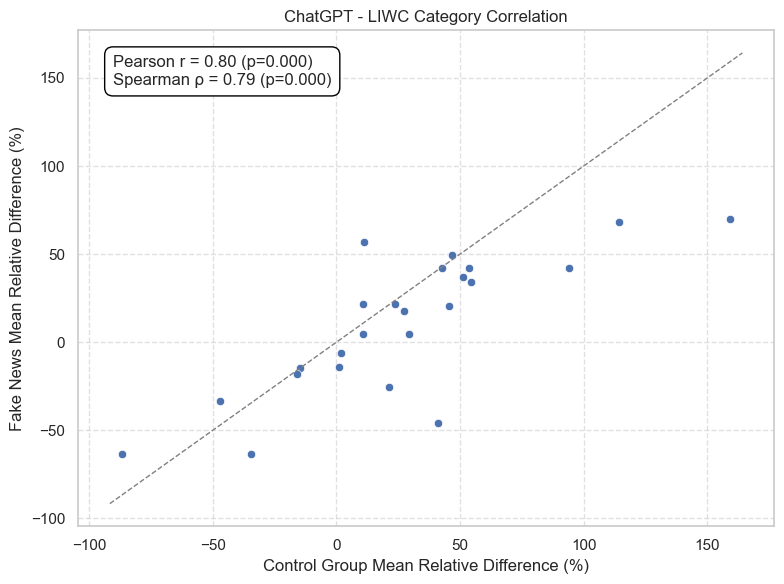

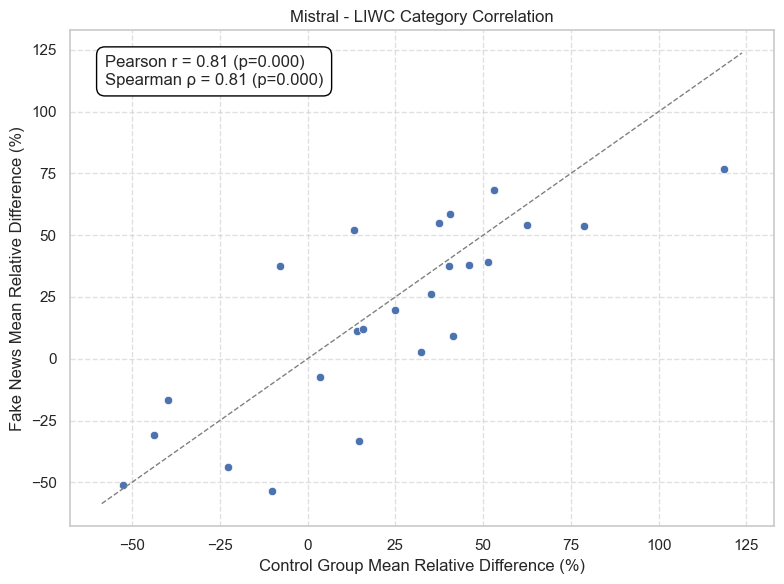

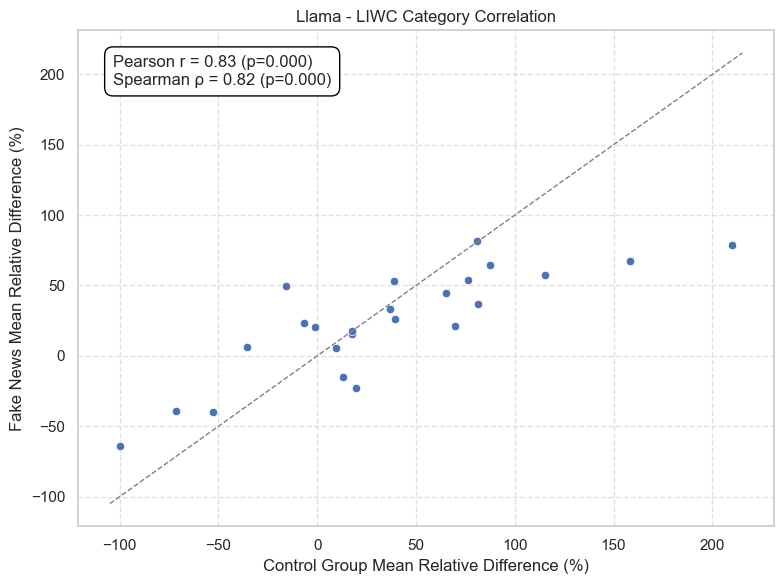

In [261]:
# List of models to evaluate
models = ['gpt-4o_text', 'Mistral_text', 'Llama_text']

# Models Labels
model_labels = {
    'gpt-4o_text': 'ChatGPT',
    'Mistral_text': 'Mistral',
    'Llama_text': 'Llama'
}

# DataFrames containing the mean relative LIWC differences for each category
fake_means = liwc_relative_diff_means_numeric['fake']
control_means = liwc_relative_diff_means_numeric['control']

# Loop through each language model
for model in models:
    # Extract the vector of mean relative differences per LIWC category
    fake_vals = fake_means[model]
    control_vals = control_means[model]

    # Combine into one DataFrame for analysis (one row per LIWC category)
    combined_df = pd.concat(
        [fake_vals, control_vals],
        axis=1,
        keys=['Fake', 'Control']
    ).dropna()  # Drop rows with missing values in either dataset

    # Compute Pearson correlation (linear)
    pearson_corr, pearson_p = pearsonr(combined_df['Fake'], combined_df['Control'])

    # Compute Spearman correlation (monotonic)
    spearman_corr, spearman_p = spearmanr(combined_df['Fake'], combined_df['Control'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Scatter plot
    sns.scatterplot(x='Control', y='Fake', data=combined_df, ax=ax)

    # Diagonal reference line
    lims = [combined_df.min().min() - 5, combined_df.max().max() + 5]
    ax.plot(lims, lims, '--', color='gray', linewidth=1)

    # Labels and title
    ax.set_xlabel('Control Group Mean Relative Difference (%)')
    ax.set_ylabel('Fake News Mean Relative Difference (%)')
    ax.set_title(f'{model_labels[model]} - LIWC Category Correlation')

    # Annotation
    ax.text(
        0.05, 0.95,
        f"Pearson r = {pearson_corr:.2f} (p={pearson_p:.3f})\n"
        f"Spearman ρ = {spearman_corr:.2f} (p={spearman_p:.3f})",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', edgecolor='black', facecolor='white')
    )

    # Grid and layout
    ax.grid(True, linestyle='--', alpha=0.6)
    fig.tight_layout()

    # Save as SVG
    filename = f'liwc_correlation_{model_labels[model].lower()}.svg'
    fig.savefig(filename, format='svg', dpi=1200)

    # Save as PDF
    filename_pdf = f'liwc_correlation_{model_labels[model].lower()}.pdf'
    fig.savefig(filename_pdf, format='pdf')

    # Show plot 
    plt.show()

    # Close figure to free memory
    plt.close(fig)

## 5.2 SAGE - Sparse Additive Generative Model 


The SAGE (Sparse Additive Generative) model was applied to identify the most distinctive words between human-written and LLM-generated texts.

Interpretation of eta values:

- Positive eta: words more characteristic of human texts.

- Negative eta: words more characteristic of LLM-generated texts.

In [269]:
real_data_final_sage = real_data_final_vis.copy()
fake_data_final_sage = fake_data_final_vis.copy() 
control_data_final_sage = control_data_final_vis.copy()

In [270]:
# Load Portuguese stopwords
stopwords_pt = set(stopwords.words('portuguese'))

# Tokenizer: lowercase + preserve hyphenated terms
def tokenize(text):
    return re.findall(r'\b\w+(?:-\w+)*\b', str(text).lower())

# Check if a token or expression is informative
def is_informative(token):
    if token.isnumeric():
        return False
    if token in stopwords_pt:
        return False
    return True 

# Main function to get counts of unigrams, bigrams, and trigrams
def get_counts_from_column(series, min_count=1, threshold=35, remove_stopwords=True):
    texts = series.dropna().tolist()
    tokens_list = [tokenize(text) for text in texts]

    # Train bigram and trigram models on raw tokens
    bigram_phraser = Phraser(Phrases(tokens_list, min_count=min_count, threshold=threshold))
    bigrammed = [bigram_phraser[tokens] for tokens in tokens_list]

    trigram_phraser = Phraser(Phrases(bigrammed, min_count=min_count, threshold=threshold))
    final_ngrams = [trigram_phraser[tokens] for tokens in bigrammed]

    # Flatten and filter tokens
    cleaned_tokens = []
    for tokens in final_ngrams:
        for token in tokens:
            # Optional cleaning: only apply if enabled or token is an n-gram
            if remove_stopwords:
                if is_informative(token):
                    cleaned_tokens.append(token.replace('_', ' '))
            else:
                cleaned_tokens.append(token.replace('_', ' '))

    return Counter(cleaned_tokens)

In [271]:
def plot_sage(df_scores, dataset_name, model_col, top_n=15, save=True):

    # Font rendering improvements for PDF and image sharpness
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['font.family'] = 'Georgia'

    # Custom labels for display
    dataset_labels = {
        "real": "True News",
        "fake": "False News",
        "control": "Control Group"
    }

    model_labels = {
        "gpt-4o_text": "ChatGPT",
        "mistral_text": "Mistral",
        "llama_text": "Llama"
    }

    # Format labels (fallback to raw input if not in dict)
    dataset_label = dataset_labels.get(dataset_name.lower(), dataset_name)
    model_label = model_labels.get(model_col.lower(), model_col)

    # Sort data by absolute SAGE score
    df_sorted = df_scores.reindex(df_scores['sage_score'].abs().sort_values(ascending=False).index)
    top_ai = df_sorted[df_sorted['sage_score'] < 0].sort_values('sage_score').head(top_n).reset_index(drop=True)
    top_human = df_sorted[df_sorted['sage_score'] > 0].sort_values('sage_score', ascending=False).head(top_n).reset_index(drop=True)

    # Figure and layout
    fig, ax = plt.subplots(figsize=(10.5, 0.4 * top_n + 1.2))
    ax.axis('off')
    ax.set_xlim(0, 8.7)
    ax.set_ylim(0, top_n + 1.2)

    # Title
    ax.set_title(f"Dataset: {dataset_label}   |   Model: {model_label}",
                 fontsize=13, weight='bold', pad=18)

    # Column headers
    ax.text(0.5, top_n + 0.5, "LLM Keyword", weight='bold', fontsize=10)
    ax.text(2.2, top_n + 0.5, "SAGE", weight='bold', fontsize=10)
    ax.text(5.2, top_n + 0.5, "Human Keyword", weight='bold', fontsize=10)
    ax.text(7.2, top_n + 0.5, "SAGE", weight='bold', fontsize=10)

    # Normalize for color gradients
    norm_ai = mcolors.Normalize(vmin=min(-top_ai['sage_score']), vmax=max(-top_ai['sage_score']))
    norm_human = mcolors.Normalize(vmin=min(top_human['sage_score']), vmax=max(top_human['sage_score']))
    cmap_ai = cm.get_cmap("Purples")
    cmap_human = cm.get_cmap("Greens")

    # Rows
    for i in range(top_n):
        y = top_n - i
        ax.axhline(y + 0.25, xmin=0.05, xmax=0.95, color='lightgray', linewidth=0.4, zorder=0)

        # AI
        if i < len(top_ai) and top_ai.loc[i, 'word']:
            word_ai = top_ai.loc[i, 'word']
            score_ai = -top_ai.loc[i, 'sage_score']
            color_ai = cmap_ai(norm_ai(score_ai))
            ax.text(0.5, y, word_ai, ha='left', va='center', fontsize=9)
            ax.add_patch(patches.Rectangle((2.2, y - 0.22), 0.4 * score_ai, 0.44, color=color_ai, zorder=1))
            ax.text(2.2 + 0.4 * score_ai + 0.15, y, f"{-score_ai:.2f}", ha='left', va='center',
                    fontsize=9, color='#444', fontfamily='monospace')

        # Human
        if i < len(top_human) and top_human.loc[i, 'word']:
            word_h = top_human.loc[i, 'word']
            score_h = top_human.loc[i, 'sage_score']
            color_human = cmap_human(norm_human(score_h))
            ax.text(5.2, y, word_h, ha='left', va='center', fontsize=9)
            ax.add_patch(patches.Rectangle((7.2, y - 0.22), 0.4 * score_h, 0.44, color=color_human, zorder=1))
            ax.text(7.2 + 0.4 * score_h + 0.15, y, f"{score_h:.2f}", ha='left', va='center',
                    fontsize=9, color='#444', fontfamily='monospace')

    # Save plot 
    if save:
        base = f"sage_tablebars_{dataset_name}_{model_col}"
        fig.savefig(base + ".svg", format='svg', dpi=1200, bbox_inches='tight')
        fig.savefig(base + ".pdf", format='pdf', dpi=1200, bbox_inches='tight')

    plt.show()
    plt.close(fig)

In [272]:
def apply_sage(df, model_col, dataset_name, top_n=10, output_dir="sage_results"):
    # Extract human and model-generated texts
    human_texts = df['Text'].reset_index(drop=True)
    model_texts = df[model_col].reset_index(drop=True)

    # Count word occurrences
    human_counts = get_counts_from_column(human_texts)
    model_counts = get_counts_from_column(model_texts)

    # Combine vocabularies 
    total_counts = human_counts + model_counts
    vocab = list(total_counts.keys())  

    # Construct frequency vectors
    x_human = np.array([human_counts.get(word, 0) for word in vocab])
    x_model = np.array([model_counts.get(word, 0) for word in vocab]) + 1.0  # Avoid log(0)

    # Create log-probability baseline (mu) from model counts
    mu = np.log(x_model) - np.log(x_model.sum())

    # Estimate deviations (eta) from human distribution relative to model baseline
    eta = sage.estimate(x_human, mu)

    # Store results and plot top words
    df_scores = pd.DataFrame({'word': vocab, 'sage_score': eta})
    plot_sage(df_scores, dataset_name, model_col, save=True)

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


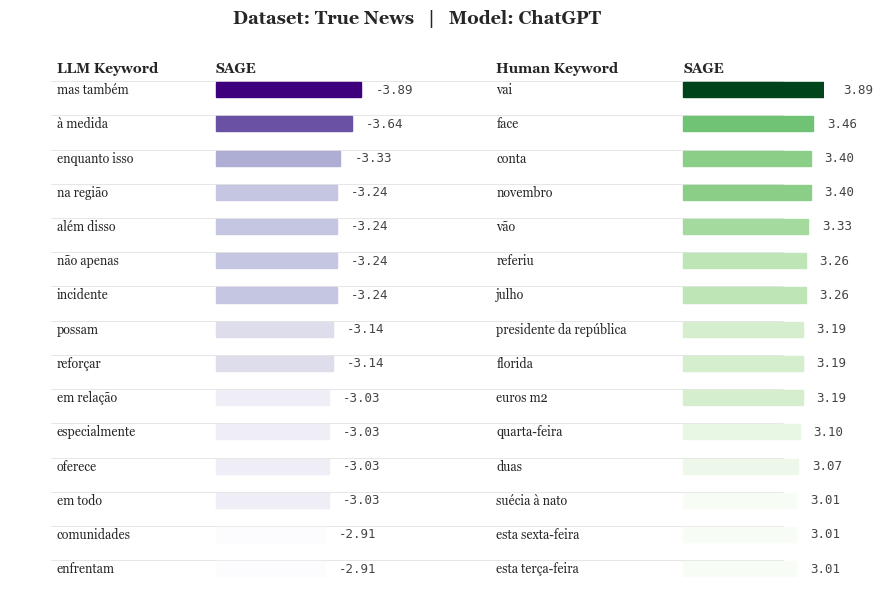

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


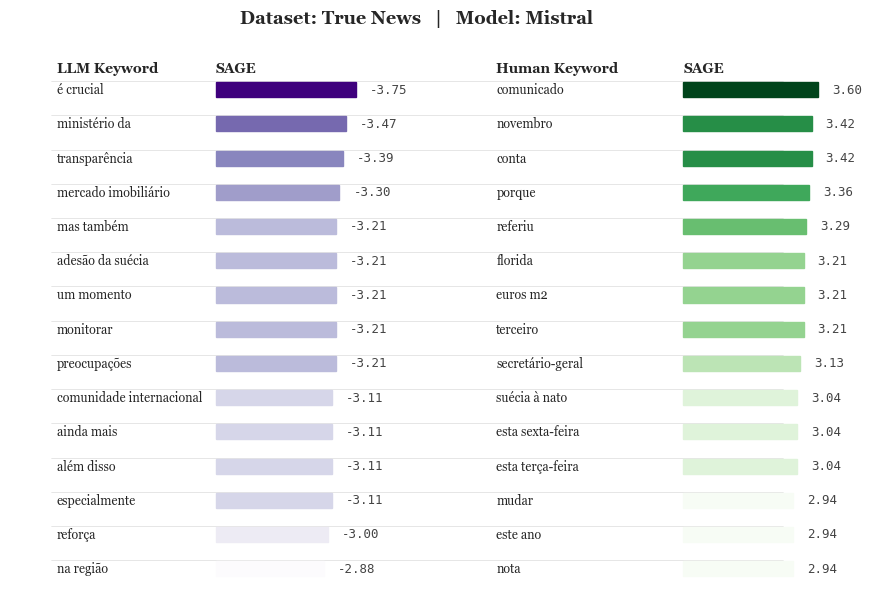

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


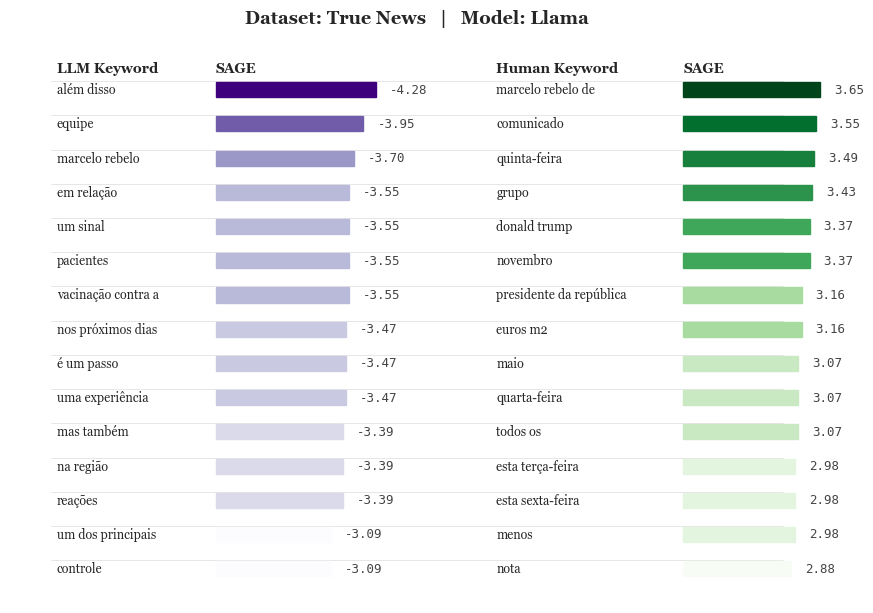

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


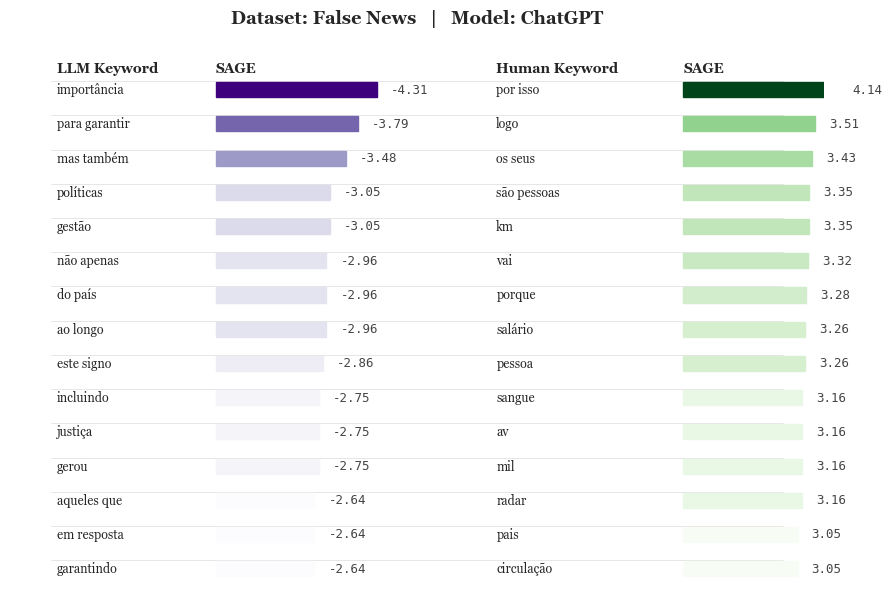

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


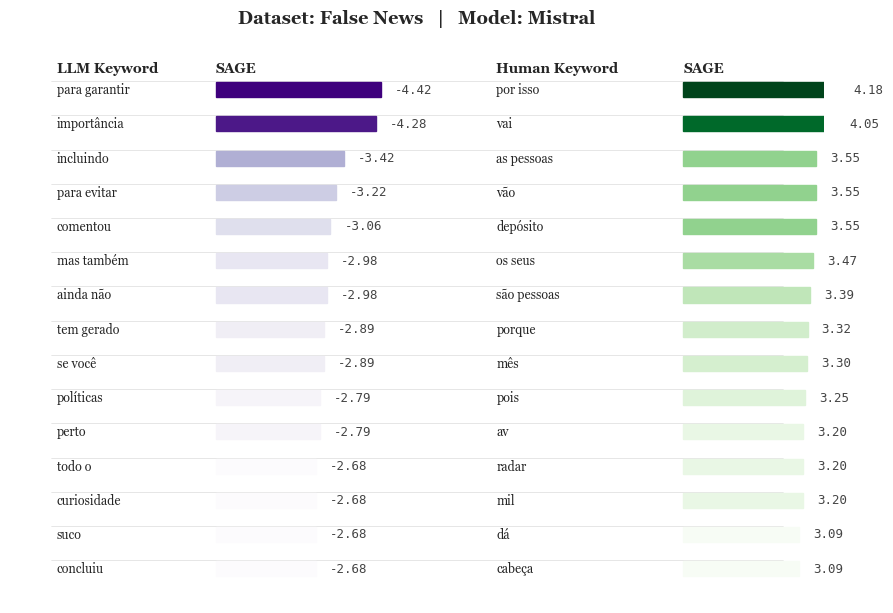

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


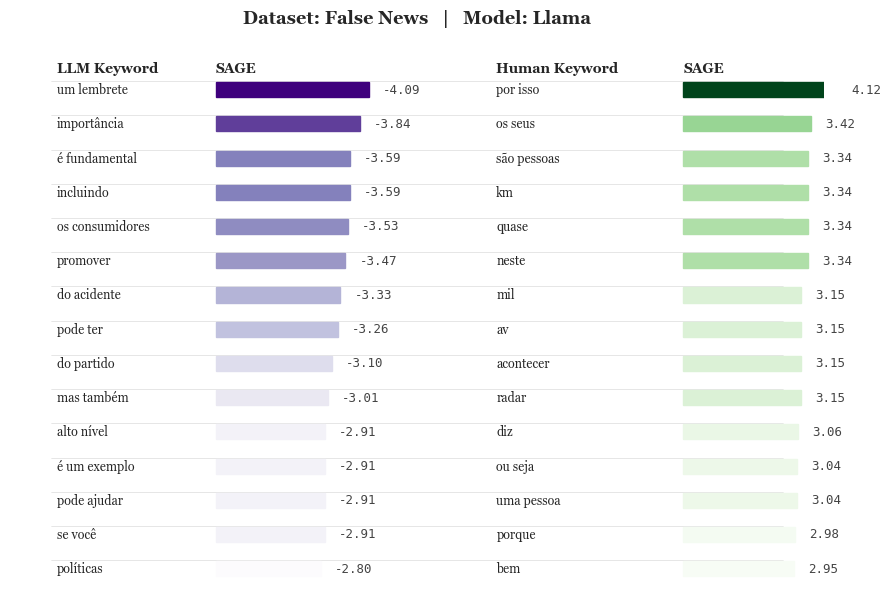

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


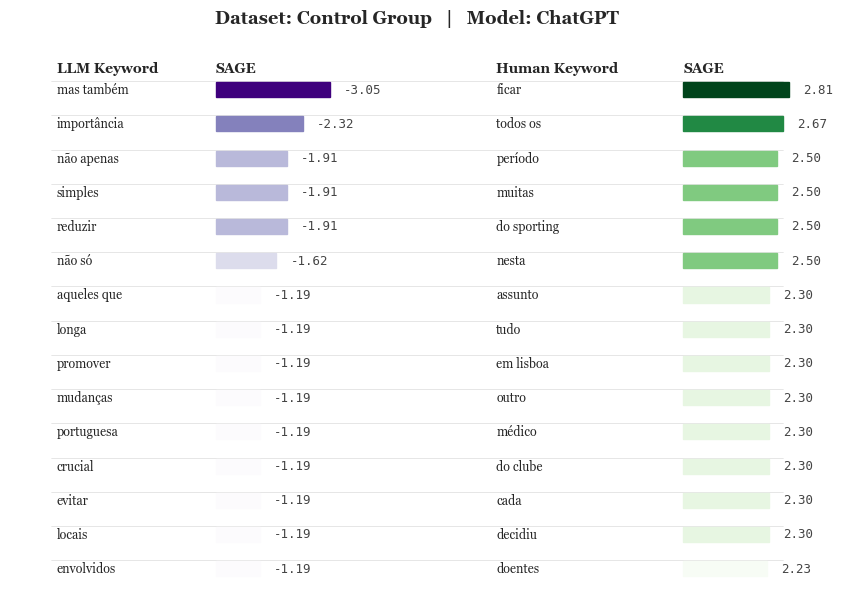

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


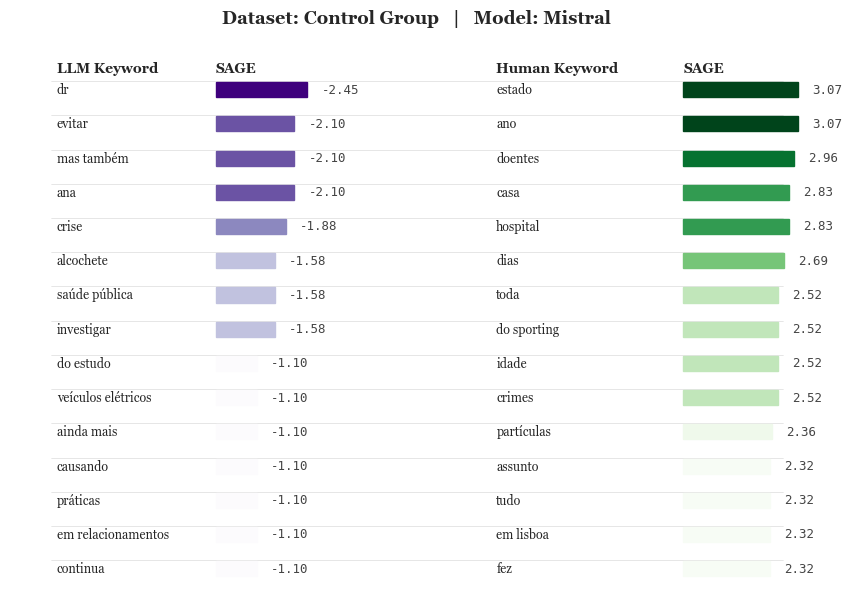

C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_ai = cm.get_cmap("Purples")
C:\Users\flavi\AppData\Local\Temp\ipykernel_672\3837221281.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_human = cm.get_cmap("Greens")


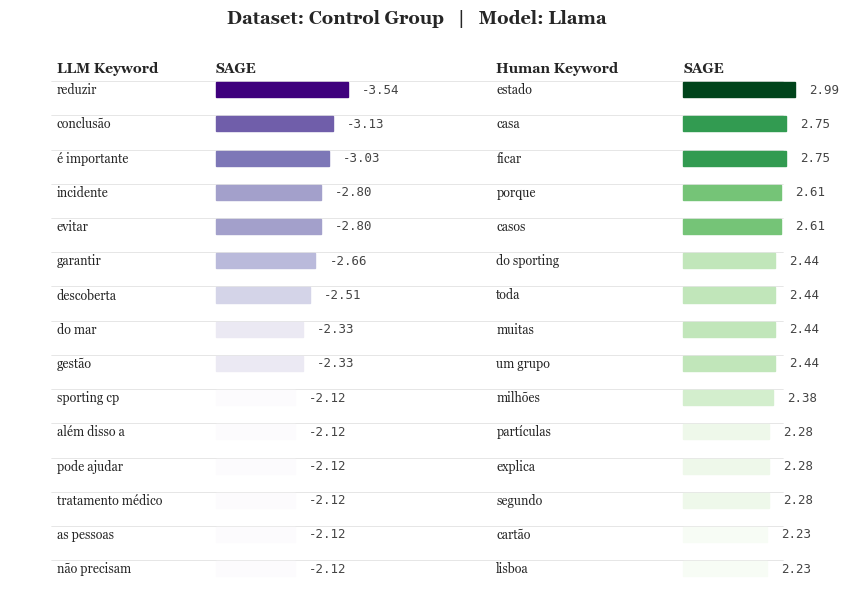

In [273]:
# Dictionary of datasets (real, fake, control)
datasets = {
    'real': real_data_final_sage,
    'fake': fake_data_final_sage,
    'control': control_data_final_sage
}

# List of LLM-generated text columns
models = ['gpt-4o_text', 'Mistral_text', 'Llama_text']

# Apply SAGE for each combination
for dataset_name, df in datasets.items():
    for model_col in models:
        apply_sage(df, model_col, dataset_name, top_n=15)


# <span style="color: #FF69B4;">6. Evaluating Fake News Existing Detection Models on Human vs LLM Content</span>

## 6.1 Applying Existing Detection Models to Human and LLM-Generated News

In [ ]:
# Load Portuguese language model from spaCy
nlp = spacy.load("pt_core_news_lg")

# Load dataset
df = pd.read_excel("Final_dataset_portuguese.xlsx")

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('portuguese'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return " ".join(lemmatized_tokens)

def count_words(text):
    words = word_tokenize(text)
    return len(words)

def count_nouns(text):
    doc = nlp(text)
    noun_count = sum([1 for token in doc if token.pos_ == 'NOUN'])
    return noun_count

def count_verbs(text):
    doc = nlp(text)
    verb_count = sum([1 for token in doc if token.pos_ == 'VERB'])
    return verb_count

def count_adjectives(text):
    doc = nlp(text)
    adj_count = sum([1 for token in doc if token.pos_ == 'ADJ'])
    return adj_count

def count_adverbs(text):
    doc = nlp(text)
    adv_count = sum([1 for token in doc if token.pos_ == 'ADV'])
    return adv_count


In [ ]:
df['text_preprocessed'] = df['Text'].apply(remove_stopwords)
df['text_preprocessed'] = df['text_preprocessed'].apply(lemmatize_text)

df['count_words_text'] = df['text_preprocessed'].apply(count_words)
df['num_nouns_text'] = df['text_preprocessed'].apply(count_nouns)
df['num_verbs_text'] = df['text_preprocessed'].apply(count_verbs)
df['num_adj_text'] = df['text_preprocessed'].apply(count_adjectives)
df['num_adv_text'] = df['text_preprocessed'].apply(count_adverbs)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
sia = SentimentIntensityAnalyzer()

def get_avg_sentiment_score(text):
    return sia.polarity_scores(text)['compound']

def get_pos_sentiment_score(text):
    return sia.polarity_scores(text)['pos']

def get_neu_sentiment_score(text):
    return sia.polarity_scores(text)['neu']

def get_neg_sentiment_score(text):
    return sia.polarity_scores(text)['neg']

In [ ]:
df['sentiment_avg_text'] = df['text_preprocessed'].apply(lambda x: get_avg_sentiment_score(x))

# Concatenate the preprocessed text, title, sentiment, and additional features
df['features'] = df.apply(lambda x: ' '.join([x['text_preprocessed'],
                                              str(x['sentiment_avg_text']),
                                              str(x['count_words_text']), 
                                              str(x['num_nouns_text']),
                                              str(x['num_verbs_text']),
                                              str(x['num_adj_text']),
                                              str(x['num_adv_text'])]), axis=1)

df.to_csv("Final_preprocessed_dataset_portuguese_without_source.csv", index = False)

In [ ]:
# Load dataset
df = pd.read_csv("Final_preprocessed_dataset_portuguese_without_source.csv")

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df['features'])

y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

results_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

xgb_best = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.2,
    max_depth=5,
    n_estimators=300,
    subsample=1,
    random_state=42
)

xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

Model performance on 103 FAKE + 103 REAL human news:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       103
           1       0.96      0.90      0.93       103

    accuracy                           0.93       206
   macro avg       0.93      0.93      0.93       206
weighted avg       0.93      0.93      0.93       206



C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

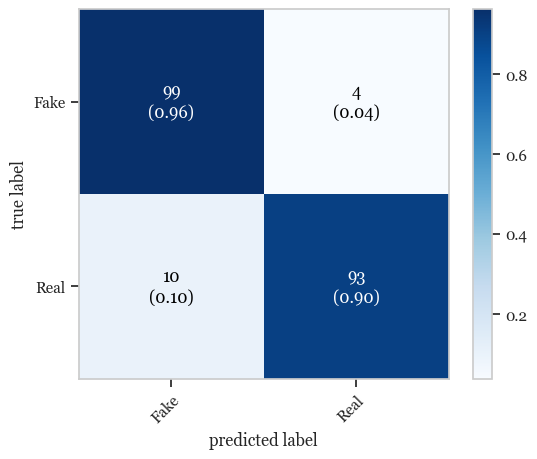

C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

In [ ]:
# Find the indices of fake news (Label = 0) and real news (Label = 1)
fake_indices = np.where(y_test == 0)[0]
real_indices = np.where(y_test == 1)[0]

# Select the first 103 fake and 103 real human news samples
selected_fake = fake_indices[:103]
selected_real = real_indices[:103]

# Concatenate both sets of indices
selected_indices = np.concatenate([selected_fake, selected_real])

# Shuffle the selected indices 
np.random.shuffle(selected_indices)

# Extract a balanced subset of X_test and y_test
X_test_balanced = X_test[selected_indices]
y_test_balanced = y_test.iloc[selected_indices]

# Make predictions using the best XGBoost model
y_pred_balanced = xgb_best.predict(X_test_balanced)

# Evaluate model performance
print("Model performance on 103 FAKE + 103 REAL human news:")
print(classification_report(y_test_balanced, y_pred_balanced))

# Compute confusion matrix
conf_mat_balanced = confusion_matrix(y_test_balanced, y_pred_balanced)

# Plot and save confusion matrix in high quality (PDF + SVG)
save = True
fig, ax = plot_confusion_matrix(conf_mat_balanced, show_normed=True, colorbar=True, class_names=['Fake', 'Real'])

if save:
    base = "confusion_matrix_human_balanced"
    fig.savefig(base + ".pdf", format='pdf', dpi=1200, bbox_inches='tight')
    fig.savefig(base + ".svg", format='svg', dpi=1200, bbox_inches='tight')

plt.show()
plt.close(fig)

# Store the evaluation metrics
accuracy = accuracy_score(y_test_balanced, y_pred_balanced)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_balanced, y_pred_balanced, average='macro')

results_df.loc[2] = ['XGBoost - Human Fake + Real News (103 each)',
                     accuracy,
                     precision,
                     recall,
                     f1_score]

In [ ]:
# Save the model
joblib.dump(xgb_best, "xgb_model_human.pkl")

# Save the vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [ ]:
real_data_final_det= real_data_final_vis.copy() 
fake_data_final_det = fake_data_final_vis.copy()  

In [ ]:
# Select 103 unique random rows from the real and fake datasets
real_sampled_rows = real_data_final_det.sample(n=103, random_state=42)
fake_sampled_rows = fake_data_final_det.sample(n=103, random_state=42)

# For each row, randomly select one model (GPT, Mistral, or Llama)
llm_columns = ['gpt-4o_text', 'Mistral_text', 'Llama_text']

def pick_random_llm_text(row):
    return row[np.random.choice(llm_columns)]

# Apply to real and fake datasets
df_real_llm = real_sampled_rows.apply(pick_random_llm_text, axis=1).to_frame(name='Text')
df_real_llm['Label'] = 1  # Real

df_fake_llm = fake_sampled_rows.apply(pick_random_llm_text, axis=1).to_frame(name='Text')
df_fake_llm['Label'] = 0  # Fake

# Concatenate and shuffle
df_llm_test = pd.concat([df_real_llm, df_fake_llm]).sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
# Load model and vectorizer
xgb_model = joblib.load("xgb_model_human.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

In [ ]:
# Apply the same preprocessing to the dataset with LLM-generated texts
df_llm_test['text_preprocessed'] = df_llm_test['Text'].apply(remove_stopwords)
df_llm_test['text_preprocessed'] = df_llm_test['text_preprocessed'].apply(lemmatize_text)
df_llm_test['count_words_text'] = df_llm_test['text_preprocessed'].apply(count_words)
df_llm_test['num_nouns_text'] = df_llm_test['text_preprocessed'].apply(count_nouns)
df_llm_test['num_verbs_text'] = df_llm_test['text_preprocessed'].apply(count_verbs)
df_llm_test['num_adj_text'] = df_llm_test['text_preprocessed'].apply(count_adjectives)
df_llm_test['num_adv_text'] = df_llm_test['text_preprocessed'].apply(count_adverbs)
df_llm_test['sentiment_avg_text'] = df_llm_test['text_preprocessed'].apply(lambda x: get_avg_sentiment_score(x))

# 3. Concatenate features as done during training
df_llm_test['features'] = df_llm_test.apply(lambda x: ' '.join([
    x['text_preprocessed'],
    str(x['sentiment_avg_text']),
    str(x['count_words_text']),
    str(x['num_nouns_text']),
    str(x['num_verbs_text']),
    str(x['num_adj_text']),
    str(x['num_adv_text']),
]), axis=1)


Model performance on LLM-generated texts (103 fake + 103 real):
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       103
           1       0.71      0.84      0.77       103

    accuracy                           0.75       206
   macro avg       0.76      0.75      0.75       206
weighted avg       0.76      0.75      0.75       206



C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

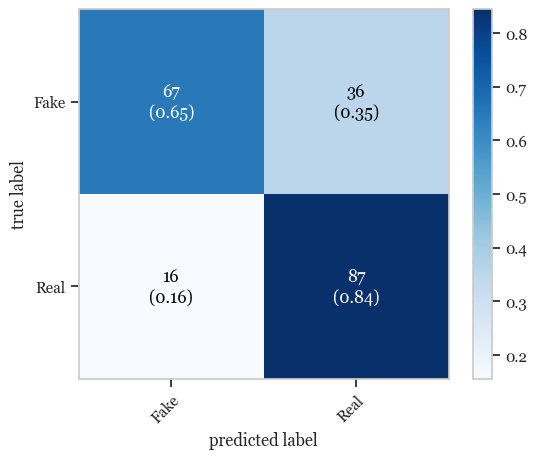

C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

In [ ]:
# Transform with TF-IDF
X_llm = tfidf.transform(df_llm_test['features'])
y_llm = df_llm_test['Label']

# Make prediction
y_pred_llm = xgb_model.predict(X_llm)

# Evaluation
print("Model performance on LLM-generated texts (103 fake + 103 real):")
print(classification_report(y_llm, y_pred_llm))

# Compute confusion matrix
conf_mat_llm = confusion_matrix(y_llm, y_pred_llm)

# Plot confusion matrix and get figure
fig, ax = plot_confusion_matrix(conf_mat_llm, show_normed=True, colorbar=True, class_names=['Fake', 'Real'])

# Save figure in high quality PDF and SVG
base = "confusion_matrix_llms_balanced"
fig.savefig(base + ".pdf", format='pdf', dpi=1200, bbox_inches='tight')
fig.savefig(base + ".svg", format='svg', dpi=1200, bbox_inches='tight')

plt.show()
plt.close(fig)

#  Save metrics
accuracy_llm = accuracy_score(y_llm, y_pred_llm)
precision_llm, recall_llm, f1_llm, _ = precision_recall_fscore_support(y_llm, y_pred_llm, average='macro')

results_df.loc[3] = ['XGBoost - LLM Fake + Real News (103 each)',
                     accuracy_llm,
                     precision_llm,
                     recall_llm,
                     f1_llm]

## 6.2 Statistical Analysis of Model Predictions Using Chi-Square Test

Statistical method used to determine whether there is a significant association between two categorical variables (news origin vs model prediction).

The Chi-squared test calculates what the results would look like if the model's accuracy didn’t depend on the text origin, that is, if human and LLM-generated texts were treated equally. Then, it compares this expectation with the actual results. If the difference is large enough, it means the model's performance is significantly affected by the source of the text.

In [ ]:
# Compute confusion matrices for human-generated and LLM-generated test data (observed)
conf_mat_human = confusion_matrix(y_test_balanced, y_pred_balanced)
conf_mat_llm = confusion_matrix(y_llm, y_pred_llm)

# Calculate number of correct and incorrect predictions for human texts
human_correct = np.trace(conf_mat_human)  # Sum of the diagonal: true positives + true negatives
human_incorrect = conf_mat_human.sum() - human_correct  # All other cases: false positives + false negatives

# Calculate number of correct and incorrect predictions for LLM-generated texts
llm_correct = np.trace(conf_mat_llm)
llm_incorrect = conf_mat_llm.sum() - llm_correct

# Build the contingency table:
# Rows: type of source (Human, LLM)
# Columns: classification outcome (Correct, Incorrect)
contingency_table = np.array([
    [human_correct, human_incorrect],
    [llm_correct, llm_incorrect]
])

print("Contingency Table:")
print(contingency_table)

# Perform the Chi-squared test of independence
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Output test results
print("\nChi-squared Test Results:")
print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(expected)

# Interpret the result based on a significance level of 0.05
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference between the model's performance on Human vs. LLM-generated misinformation (reject H0).")
else:
    print("There is no statistically significant difference between the model's performance on Human vs. LLM-generated misinformation (fail to reject H0).")


Contingency Table:
[[192  14]
 [156  50]]

Chi-squared Test Results:
Chi-squared statistic: 22.6607
P-value: 0.0000
Degrees of freedom: 1
Expected frequencies:
[[174.  32.]
 [174.  32.]]

👉 There is a statistically significant difference between the model's performance on Human vs. LLM-generated misinformation (reject H0).


C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\flavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spars

The test yielded a χ² value of 22.66 with a p-value < 0.001, indicating a statistically significant association between text origin and model performance. Specifically, the model classified human-generated content more accurately than LLM-generated content, suggesting that the nature of the source influences classification success.

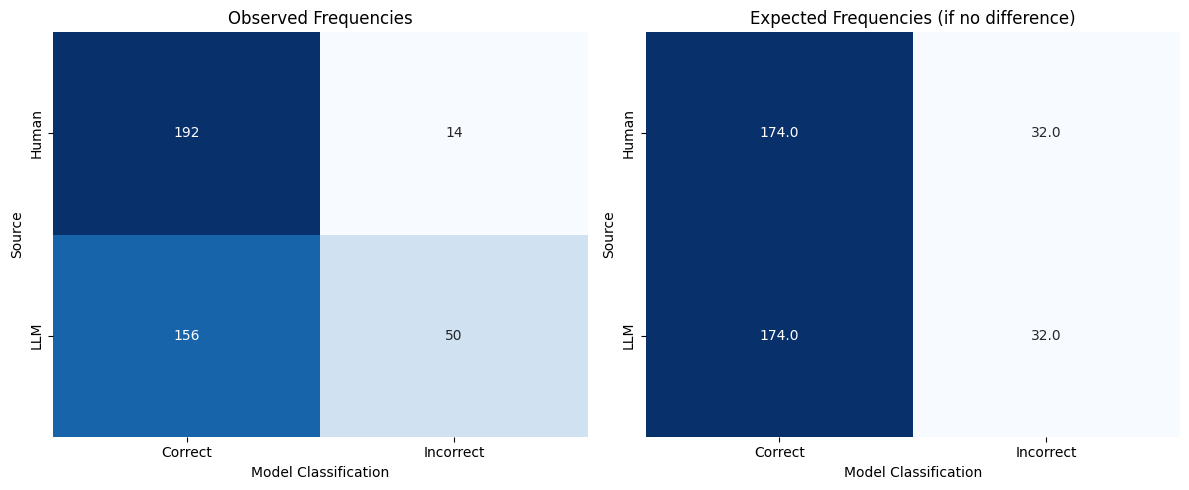

In [ ]:
# Observed and expected frequencies from the chi-squared test
observed = np.array([[192, 14],  # Human: [Correct, Incorrect]
                     [156, 50]]) # LLM: [Correct, Incorrect]

expected = np.array([[174, 32],
                     [174, 32]])

# Convert to pandas DataFrames for visualization
df_observed = pd.DataFrame(observed, columns=["Correct", "Incorrect"], index=["Human", "LLM"])
df_expected = pd.DataFrame(expected, columns=["Correct", "Incorrect"], index=["Human", "LLM"])

# Create side-by-side heatmaps for observed and expected frequencies
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap for observed values
sns.heatmap(df_observed, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Observed Frequencies")
axes[0].set_ylabel("Source")
axes[0].set_xlabel("Model Classification")

# Heatmap for expected values (under the null hypothesis of independence)
sns.heatmap(df_expected, annot=True, fmt=".1f", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title("Expected Frequencies (if no difference)")
axes[1].set_ylabel("Source")
axes[1].set_xlabel("Model Classification")

# Final layout and save to file
plt.tight_layout()
plt.savefig("heatmaps_chi_squared_result.png", dpi=300)
plt.show()